# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [1]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
import inspect
from pathlib import Path
warnings.filterwarnings('ignore')

from dnd_dynamics.analysis import data_loading as dl
from dnd_dynamics.analysis import basic_metrics as basic
from dnd_dynamics.analysis import creativity_metrics as creativity
from dnd_dynamics.analysis import cohesion_metrics as cohesion

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

Anthropic API key loaded
OpenAI API key loaded
Gemini API key loaded
Created plots directory: plots


# Configuration

In [2]:
# === CONFIGURATION ===

# Base campaign names to analyze
CAMPAIGN_BASE_NAMES = [
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',
]

# LLM game filters
LLM_FILTER = {
    'model': ['gpt-4o', 'gemini-1.5-pro', 'claude-3-7-sonnet-latest'],
    'campaign_name': CAMPAIGN_BASE_NAMES,
    'include_player_personalities': [True, False],
    'year': 2025,
    'scratchpad': True,
}

# Category grouping - which metadata fields to group by for aggregation
CATEGORY_FIELDS = ['model', 'include_player_personalities']

# Analysis parameters
MESSAGES_PER_SESSION = 5
FORCE_REFRESH = False

# Output
OUTPUT_DIR = Path('plots')

In [3]:
# === DATA LOADING ===

# Load human campaigns
dfs_human = dl.load_campaigns(
    CAMPAIGN_BASE_NAMES,
    messages_per_session=MESSAGES_PER_SESSION
)

# Load LLM campaigns with filtering
dfs_llm = dl.load_campaigns(
    'llm',
    messages_per_session=MESSAGES_PER_SESSION,
    filter_by=LLM_FILTER
)

# Combine DataFrames
dfs = {**dfs_human, **dfs_llm}

print(f"Loaded {len(dfs_human)} human campaigns, {len(dfs_llm)} LLM campaigns")
print(f"Total: {len(dfs)} campaigns")

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📝 Applying manual character corrections: {'FaeDra': 'Rylei Dreemurr'}
🗑️ Removing single-post characters: ['Sry']
⚠️ Character name conflict: 'Argo' used by players ['Stubbazubba', 'Mutant_vapes27']
✅ Player Stubbazubba: 'Argo' (confirmed correct)
🔄 Player Mutant_vapes27: 'Argo' → 'Dro Coborel'
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori
✅ Corrections completed for campaign: 10391-guardians-of-gridori
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death
⚠️ Character name conflict: 'Finl

Loading campaigns:   0%|          | 0/42 [00:00<?, ?it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708
✅ Corrections completed for campaign: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708


Loading campaigns:   7%|▋         | 3/42 [00:00<00:01, 21.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138
✅ Corrections completed for campaign: 10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449
✅ Corrections completed for campaign: 10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454
✅ Corrections completed for campaign: 10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori_gpt-4o_no_players_scratch_20250814_131744
✅ Corrections completed for

Loading campaigns:  14%|█▍        | 6/42 [00:00<00:01, 21.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_no_players_scratch_20250819_110000
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_no_players_scratch_20250819_110000
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_players_scratch_20250819_132210
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_players_scratch_20250819_132210
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_no_players_scratch_20250818_204449
🗑️ Removing single-post characters: ['Sry']
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_

Loading campaigns:  26%|██▌       | 11/42 [00:00<00:02, 14.13it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scratch_20250818_145631
🗑️ Removing single-post characters: ['Sry']
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scratch_20250818_145631
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_no_players_scratch_20250816_110159
🗑️ Removing single-post characters: ['Sry']
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_no_players_scratch_20250816_110159
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_players_scratch_20250816_125646
🗑️ Removing single-post characters: ['Sry']
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-p

Loading campaigns:  38%|███▊      | 16/42 [00:01<00:01, 15.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death_claude-3-7-sonnet-latest_no_players_scratch_20250818_133738
✅ Corrections completed for campaign: 20049-age-of-death_claude-3-7-sonnet-latest_no_players_scratch_20250818_133738
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death_claude-3-7-sonnet-latest_players_scratch_20250818_120952
✅ Corrections completed for campaign: 20049-age-of-death_claude-3-7-sonnet-latest_players_scratch_20250818_120952
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018
✅ Corrections completed for campaign: 20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death_gemini-1.5-pro_players_scratch_20250818_122503
✅ Corrections completed for campaign: 20049-age-of-d

Loading campaigns:  45%|████▌     | 19/42 [00:01<00:01, 17.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death_gpt-4o_players_scratch_20250816_212424
✅ Corrections completed for campaign: 20049-age-of-death_gpt-4o_players_scratch_20250816_212424
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_no_players_scratch_20250819_153636
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_no_players_scratch_20250819_153636
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_players_scratch_20250818_154911
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_players_scratch_20250818_154911
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_gemini-1.5-pro_no_players_scratch_20250818_160148
✅ Corrections complet

Loading campaigns:  55%|█████▍    | 23/42 [00:01<00:01, 16.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_gemini-1.5-pro_players_scratch_20250818_153052
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent_gemini-1.5-pro_players_scratch_20250818_153052
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_gpt-4o_no_players_scratch_20250816_190300
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent_gpt-4o_no_players_scratch_20250816_190300
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent_gpt-4o_players_scratch_20250816_194054
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent_gpt-4o_players_scratch_20250816_194054
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_no_players_scratch_20250818_141059
✅ Corrections completed for campaign: 742

Loading campaigns:  76%|███████▌  | 32/42 [00:01<00:00, 24.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838
✅ Corrections completed for campaign: 7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign_gemini-1.5-pro_players_scratch_20250818_133539
✅ Corrections completed for campaign: 7426-serpent-isle-private-campaign_gemini-1.5-pro_players_scratch_20250818_133539
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign_gpt-4o_no_players_scratch_20250817_100448
✅ Corrections completed for campaign: 7426-serpent-isle-private-campaign_gpt-4o_no_players_scratch_20250817_100448
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign_gpt-4o_players_scratch_20250817_101144
✅ Co

Loading campaigns:  83%|████████▎ | 35/42 [00:01<00:00, 21.08it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89221-banhaven-academy-year-1_gemini-1.5-pro_players_scratch_20250818_190918
✅ Corrections completed for campaign: 89221-banhaven-academy-year-1_gemini-1.5-pro_players_scratch_20250818_190918
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89221-banhaven-academy-year-1_gpt-4o_no_players_scratch_20250816_183355
✅ Corrections completed for campaign: 89221-banhaven-academy-year-1_gpt-4o_no_players_scratch_20250816_183355
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89221-banhaven-academy-year-1_gpt-4o_players_scratch_20250816_140525
✅ Corrections completed for campaign: 89221-banhaven-academy-year-1_gpt-4o_players_scratch_20250816_140525


Loading campaigns:  90%|█████████ | 38/42 [00:02<00:00, 20.19it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149
✅ Corrections completed for campaign: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211
✅ Corrections completed for campaign: 90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237
✅ Corrections completed for campaign: 90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to ca

Loading campaigns: 100%|██████████| 42/42 [00:02<00:00, 18.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319
✅ Corrections completed for campaign: 90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319
✅ Successfully loaded 42 campaigns
📈 Total messages across all campaigns: 10,211
Loaded 7 human campaigns, 42 LLM campaigns
Total: 49 campaigns


# Calculate game log analyses

In [4]:
# === METRICS CALCULATION ===

basic_metrics = basic.analyze_basic_metrics(dfs, force_refresh=FORCE_REFRESH)

creativity_metrics = creativity.analyze_creativity(dfs, force_refresh=FORCE_REFRESH)

cohesion_metrics = cohesion.analyze_cohesion(
    dfs,
    messages_per_session=MESSAGES_PER_SESSION,
    force_refresh=FORCE_REFRESH
)

📁 Loaded 49 cached basic metrics results
📁 Loaded 49 cached creativity results
📁 Loaded 49 cached cohesion results


# Helper Functions

In [5]:
def plot_histogram(data,
                   colors=None,
                   edgecolor='none',
                   alpha=0.5,
                   colormap='viridis',
                   xlabel=None,
                   bins=None,
                   log_bins=False,
                   log_y=False,
                   figsize=(4, 4),
                   ylabel="Counts",
                   labels=None):
    """
    Plot histogram(s) with colors evenly spaced across a colormap.
    
    Parameters:
    data: Single array/list OR list of arrays/lists to plot as histograms
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    """
    plt.figure(figsize=figsize)

    # Auto-detect if data is a single array or list of arrays
    try:
        if isinstance(data[0], (list, np.ndarray)):
            data_list = data  # Already a list of arrays
        else:
            data_list = [data]  # Single array, wrap it in a list
    except:
        data_list = [data]

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    n_plots = len(clean_data_list)

    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_plots == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_plots - 1)) for i in range(n_plots)]

    # Calculate common bins across all datasets (now NaN-free)
    all_data = np.concatenate(clean_data_list)

    if len(all_data) == 0:
        raise ValueError("All data contains only NaN values")

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50  # Default number of log bins

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50  # Default number of bins

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Plot all histograms with the same bins (NaN-free data)
    for i, dataset in enumerate(clean_data_list):
        if labels is not None:
            label = labels[i]
        else:
            label = None
        plt.hist(dataset,
                 bins=common_bins,
                 color=colors[i],
                 edgecolor=edgecolor,
                 alpha=alpha,
                 label=label)

    # Set axis scales
    if log_bins:
        plt.xscale('log')

    if log_y:
        plt.yscale('log')

    sns.despine()
    plt.ylabel(ylabel)

    if xlabel is not None:
        plt.xlabel(xlabel, clip_on=False)
    # Style axes
    ax = plt.gca()
    ax.tick_params(colors='#4a4a4a', width=0.5)
    ax.spines['left'].set_color('#4a4a4a')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#4a4a4a')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.label.set_color('#4a4a4a')
    ax.yaxis.label.set_color('#4a4a4a')

In [6]:
# === CATEGORIZATION FUNCTIONS ===

def categorize_campaigns(campaign_names, category_fields):
    """
    Categorize campaigns based on metadata fields.

    Args:
        campaign_names: List of campaign names (keys from dfs)
        category_fields: List of metadata fields to use for grouping
                        e.g., ['model', 'include_player_personalities']

    Returns:
        Dict mapping category_name -> list of campaign names
        e.g., {'human': [...], 'model:gpt-4o, include_player_personalities:True': [...]}
    """
    # Load metadata index (relative to tutorials/ directory)
    metadata_index_path = Path('../data/llm-games/metadata_index.json')
    with open(metadata_index_path) as f:
        metadata_index = json.load(f)

    categories = {'human': []}

    for name in campaign_names:
        # Check if it's in metadata_index (LLM game)
        if name in metadata_index:
            metadata = metadata_index[name]

            # Build category key as "field1:value1, field2:value2"
            parts = []
            for field in category_fields:
                value = metadata.get(field)
                if value is not None:
                    parts.append(f"{field}:{value}")

            category_key = ', '.join(parts) if parts else 'llm_other'

            if category_key not in categories:
                categories[category_key] = []
            categories[category_key].append(name)
        else:
            # Human campaign (not in LLM metadata index)
            categories['human'].append(name)

    return categories


def aggregate_by_category(metric_data, campaign_names, categories, category_order=None):
    """
    Aggregate metric data by category.

    Args:
        metric_data: List of metric arrays, one per campaign (in same order as campaign_names)
        campaign_names: List of campaign names corresponding to metric_data
        categories: Dict from categorize_campaigns()
        category_order: Optional list specifying order of categories in output

    Returns:
        Tuple of (aggregated_data, category_order) where aggregated_data is a list of 
        concatenated arrays, one per category
    """
    # Build name -> index mapping
    name_to_idx = {name: i for i, name in enumerate(campaign_names)}

    # Default order: human first, then sorted
    if category_order is None:
        category_order = ['human'] + sorted(k for k in categories.keys() if k != 'human')

    result = []
    for cat in category_order:
        cat_names = categories.get(cat, [])
        if cat_names:
            cat_data = [metric_data[name_to_idx[n]] for n in cat_names if n in name_to_idx]
            result.append(np.concatenate(cat_data) if cat_data else np.array([]))
        else:
            result.append(np.array([]))

    return result, category_order

In [7]:
# === DATA PREPARATION ===

# Get ordered campaign names
campaign_names = list(dfs.keys())

# Categorize campaigns using metadata
categories = categorize_campaigns(campaign_names, CATEGORY_FIELDS)

# Print category summary
print("Campaign categories:")
for cat, names in categories.items():
    print(f"  {cat}: {len(names)} campaigns")

# Build metric lists (in same order as campaign_names)
time_intervals_data = []
post_len_data = []
sbert_post_distances = []
sbert_session_creativity = []
cohesion_session_scores = []

for name in campaign_names:
    # Time intervals
    time_intervals_data.append(
        basic_metrics[name]['time_intervals_overall']['overall']['intervals_data']
    )
    
    # Post lengths
    post_len_data.append(
        basic_metrics[name]['post_lengths_overall']['overall']['word_counts_data']
    )
    
    # Semantic distances (creativity 2)
    sbert_post_distances.append(
        np.array(creativity_metrics[name]['semantic_distances'])
    )
    
    # Session novelty (creativity 1)
    sbert_session_creativity.append(
        np.array(creativity_metrics[name]['session_novelty'][['mean_distance']])
    )
    
    # Cohesion scores
    if cohesion_metrics[name] is not None:
        cohesion_session_scores.append(
            np.array(cohesion_metrics[name]['session_cohesion_scores'])
        )
    else:
        cohesion_session_scores.append(np.array([np.nan]))

Campaign categories:
  human: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:False: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:True: 7 campaigns
  model:gpt-4o, include_player_personalities:False: 7 campaigns
  model:gpt-4o, include_player_personalities:True: 7 campaigns


In [8]:
def plot_comparison_histograms(data,
                               colors=None,
                               edgecolor='none',
                               alpha=0.5,
                               colormap='viridis',
                               xlabel=None,
                               bins=None,
                               log_bins=False,
                               log_y=False,
                               labels=None,
                               figsize=None,
                               ylabel="Counts"):
    """
    Plot comparison histograms with the first dataset appearing in every subplot,
    and each subsequent dataset compared against it in separate vertical subplots.
    
    Parameters:
    data: List of arrays/lists (must have at least 2 datasets)
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    labels (list): Labels for each dataset (default: None)
    figsize (tuple): Figure size (width, height). If None, auto-calculated
    """

    # Validate input
    if not isinstance(data, list) or len(data) < 2:
        raise ValueError("data must be a list with at least 2 datasets")

    # Auto-detect if data contains arrays or single values
    data_list = []
    for dataset in data:
        try:
            if isinstance(dataset[0], (list, np.ndarray)):
                data_list.append(dataset)
            else:
                data_list.append(dataset)
        except:
            data_list.append(dataset)

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    if any(len(dataset) == 0 for dataset in clean_data_list):
        raise ValueError("One or more datasets contain only NaN values")

    n_datasets = len(clean_data_list)
    n_subplots = n_datasets - 1  # Number of comparison subplots

    # Set up figure size
    if figsize is None:
        figsize = (8, 3 * n_subplots)  # 3 inches height per subplot

    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, sharex=True)
    plt.subplots_adjust(hspace=0)
    # Handle case where there's only one comparison (single axis)
    if n_subplots == 1:
        axes = [axes]

    # Set up colors
    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_datasets == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_datasets - 1)) for i in range(n_datasets)]

    # Calculate common bins across all datasets
    all_data = np.concatenate(clean_data_list)

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Reference dataset (first one)
    reference_data = clean_data_list[0]
    reference_color = colors[0]
    reference_label = labels[0] if labels is not None else "Reference"

    # Plot each comparison
    for i in range(n_subplots):
        ax = axes[i]

        # Current comparison dataset (i+1 because we skip the reference)
        comparison_data = clean_data_list[i + 1]
        comparison_color = colors[i + 1]
        comparison_label = labels[
            i + 1] if labels is not None else f"Dataset {i + 1}"

        # Plot reference histogram (same in every subplot)
        ax.hist(reference_data,
                bins=common_bins,
                color=reference_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=reference_label)

        # Plot comparison histogram
        ax.hist(comparison_data,
                bins=common_bins,
                color=comparison_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=comparison_label)

        # Set axis scales
        if log_bins:
            ax.set_xscale('log')

        if log_y:
            ax.set_yscale('log')

        # Style the subplot
        sns.despine(ax=ax)

        # Only add ylabel to the middle subplot
        if i == n_subplots // 2:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")

        # Don't add legend here - can be added outside function if needed

        # Style axes
        ax.tick_params(colors='#4a4a4a', width=0.5, length=2)
        ax.spines['left'].set_color('#4a4a4a')
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_color('#4a4a4a')
        ax.spines['bottom'].set_linewidth(0.5)
        ax.xaxis.label.set_color('#4a4a4a')
        ax.yaxis.label.set_color('#4a4a4a')
        ax.set_facecolor("none")
        ax.minorticks_off()
    # Only add xlabel to the bottom subplot
    if xlabel is not None:
        axes[-1].set_xlabel(xlabel)

    # Adjust layout to prevent overlap
    #plt.tight_layout()

    # Set same y-limits for all subplots
    # Find the maximum y-limit across all subplots
    max_ylim = 0
    for ax in axes:
        current_ylim = ax.get_ylim()[1]
        max_ylim = max(max_ylim, current_ylim)
    # Apply the same y-limit to all subplots
    for ax in axes:
        ax.set_ylim(0, max_ylim)
        ax.set_yticks([0, np.round(max_ylim*.7/10)*10])
    return fig, axes

In [9]:
# === MEAN METRICS PER CAMPAIGN ===

mean_sbert_session_creat = np.zeros(len(sbert_session_creativity))
mean_cohesion_session = np.zeros(len(cohesion_session_scores))
mean_sbert_post_distances = np.zeros(len(sbert_post_distances))

for i in range(len(campaign_names)):
    mean_sbert_session_creat[i] = np.mean(sbert_session_creativity[i])
    mean_cohesion_session[i] = np.mean(cohesion_session_scores[i])
    mean_sbert_post_distances[i] = np.nanmean(sbert_post_distances[i])

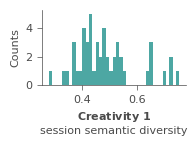

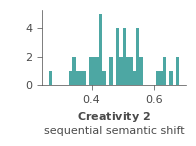

In [10]:
# Single histogram of mean values per campaign
plt.rcParams.update({'font.size': 8})

plot_histogram(mean_sbert_session_creat,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'creativity1.pdf', transparent=True)

plot_histogram(mean_sbert_post_distances,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 2}$' + '\nsequential semantic shift')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'creativity2.pdf', transparent=True)

In [11]:
# === COMBINED HISTOGRAMS (All Data) ===

time_intervals_all = np.concatenate(time_intervals_data)
post_lengths_all = np.concatenate(post_len_data)

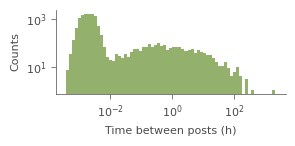

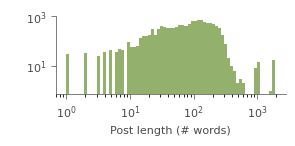

In [12]:
plot_histogram(time_intervals_all,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'time_intervals.pdf', transparent=True)

plot_histogram(post_lengths_all,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()

Aggregated category sizes:
  human: 1821 data points
  model:gemini-1.5-pro, include_player_personalities:False: 1811 data points
  model:gemini-1.5-pro, include_player_personalities:True: 1811 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 1449 data points
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 1518 data points
  model:gpt-4o, include_player_personalities:False: 1811 data points
  model:gpt-4o, include_player_personalities:True: 1811 data points


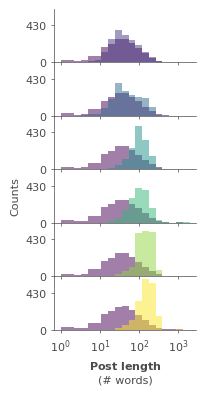

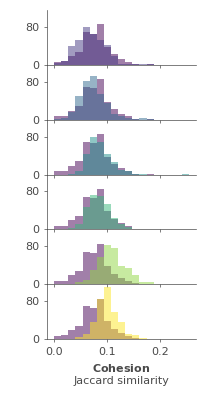

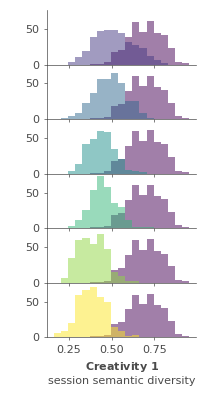

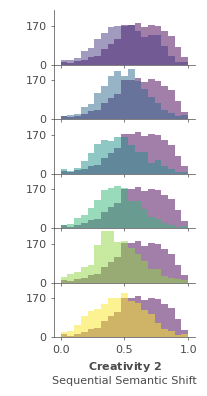

In [13]:
# === VISUALIZATION (Aggregated by Category) ===

# Define category display order (must match format from categorize_campaigns)
CATEGORY_ORDER = [
    'human',
    'model:gemini-1.5-pro, include_player_personalities:False',
    'model:gemini-1.5-pro, include_player_personalities:True',
    'model:claude-3-7-sonnet-latest, include_player_personalities:False',
    'model:claude-3-7-sonnet-latest, include_player_personalities:True',
    'model:gpt-4o, include_player_personalities:False',
    'model:gpt-4o, include_player_personalities:True',
]

# Aggregate by category
post_len_agg, _ = aggregate_by_category(post_len_data, campaign_names, categories, CATEGORY_ORDER)
cohesion_agg, _ = aggregate_by_category(cohesion_session_scores, campaign_names, categories, CATEGORY_ORDER)
creativity_1_agg, _ = aggregate_by_category(sbert_session_creativity, campaign_names, categories, CATEGORY_ORDER)
creativity_2_agg, _ = aggregate_by_category(sbert_post_distances, campaign_names, categories, CATEGORY_ORDER)

# Check category sizes
print("Aggregated category sizes:")
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"  {cat}: {len(post_len_agg[i])} data points")

plt.rcParams.update({'font.size': 8})

# Post length comparison
plot_comparison_histograms(
    post_len_agg,
    bins=20,
    log_bins=True,
    log_y=False,
    xlabel=r'$\mathbf{Post\ length}$' + '\n(# words)',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_len.pdf', transparent=True)

# Cohesion comparison
plot_comparison_histograms(
    cohesion_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Cohesion}$' + '\nJaccard similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_cohesion.pdf', transparent=True)

# Creativity 1 comparison
plot_comparison_histograms(
    creativity_1_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_creativity.pdf', transparent=True)

# Creativity 2 comparison
plot_comparison_histograms(
    creativity_2_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 2}$' + '\nSequential Semantic Shift',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)

# Full Human Dataset Analysis

Analysis of all ~985 human campaigns from the dataset to establish comprehensive baseline patterns.

In [14]:
# === LOAD ALL HUMAN CAMPAIGNS ===

dfs_all_human = dl.load_campaigns(
    'human',
    messages_per_session=MESSAGES_PER_SESSION
)

print(f"Loaded {len(dfs_all_human)} human campaigns")

📂 Loading campaigns from individual files in /Users/annie/Code/Repositories/dnd-dynamics/data/raw-human-games/individual_campaigns
📊 Found 985 campaign files


Loading campaigns:   0%|          | 0/985 [00:00<?, ?it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori
✅ Corrections completed for campaign: 10391-guardians-of-gridori
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10625-wrath-of-ashardalon
⚠️ Character name conflict: 'Dhel' used by players ['dryadgrl13', 'LightSpeed']
✅ Player dryadgrl13: 'Dhel' (confirmed correct)


Loading campaigns:   0%|          | 2/985 [00:00<07:11,  2.28it/s]

🔄 Player LightSpeed: 'Dhel' → 'Menus'
✅ Corrections completed for campaign: 10625-wrath-of-ashardalon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10639-the-crypt-of-the-dreaming-dead
✅ Corrections completed for campaign: 10639-the-crypt-of-the-dreaming-dead


Loading campaigns:   0%|          | 3/985 [00:01<06:47,  2.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10672-whispers-of-dissent
⚠️ Character name conflict: 'Lera' used by players ['DungeonMaya', 'DungeonDad']
✅ Player DungeonMaya: 'Lera' (confirmed correct)
✅ Player DungeonDad: 'Lera' (confirmed correct)
✅ Corrections completed for campaign: 10672-whispers-of-dissent


Loading campaigns:   0%|          | 4/985 [00:02<11:36,  1.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10826-ye-ol-yarn-spun-legend
⚠️ Character name conflict: 'Hjol' used by players ['ArgentTheWise', 'TheGmoat']
🔄 Player ArgentTheWise: 'Hjol' → 'Mythanthar Falynn'
🔄 Player TheGmoat: 'Hjol' → 'Hjolmond'
✅ Corrections completed for campaign: 10826-ye-ol-yarn-spun-legend


Loading campaigns:   1%|          | 5/985 [00:03<14:14,  1.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11146-tomb-of-annihilation-4pbp
✅ Corrections completed for campaign: 11146-tomb-of-annihilation-4pbp


Loading campaigns:   1%|          | 7/985 [00:04<09:03,  1.80it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11153-in-the-shadows-of-a-stone-titan
✅ Corrections completed for campaign: 11153-in-the-shadows-of-a-stone-titan
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11414-classic-crawl-the-lost-city
✅ Corrections completed for campaign: 11414-classic-crawl-the-lost-city


Loading campaigns:   1%|          | 9/985 [00:04<05:26,  2.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11531-legacy-of-the-ascended-ic-thread
✅ Corrections completed for campaign: 11531-legacy-of-the-ascended-ic-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11642-cellar-of-death-group-already-full
⚠️ Character name conflict: 'Helga' used by players ['SentientSpellbook', 'TinForged']
🔄 Player SentientSpellbook: 'Helga' → 'Yllcerys'


Loading campaigns:   1%|▏         | 13/985 [00:05<04:01,  4.03it/s]

✅ Player TinForged: 'Helga' (confirmed correct)
✅ Corrections completed for campaign: 11642-cellar-of-death-group-already-full
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11752-prison-break
✅ Corrections completed for campaign: 11752-prison-break
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11767-goblins-the-nightrot-clan-ballad
✅ Corrections completed for campaign: 11767-goblins-the-nightrot-clan-ballad
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11871-the-land-of-enlightenment-1-0-homebrew
✅ Corrections completed for campaign: 11871-the-land-of-enlightenment-1-0-homebrew
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11878-the-wildlands-of-etheryl
✅ Corrections completed for campaign: 11878-the-wildlands-of-etheryl
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11910-pillagers-of-ixalan-ic
⚠️ Character name confli

Loading campaigns:   2%|▏         | 15/985 [00:06<05:52,  2.75it/s]

🔄 Player Karpmageddon: 'Polly' → 'Grifhook'
✅ Corrections completed for campaign: 11910-pillagers-of-ixalan-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11940-legerdemain-a-little-hocus-pocus
✅ Corrections completed for campaign: 11940-legerdemain-a-little-hocus-pocus


Loading campaigns:   2%|▏         | 17/985 [00:06<04:30,  3.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11998-5e-rise-of-the-runelords-ic-spanish
✅ Corrections completed for campaign: 11998-5e-rise-of-the-runelords-ic-spanish
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12007-the-glory-of-the-coliseum-always-recruiting
🗑️ Removing single-post characters: ['Talmich', 'Kogu', '’ve', 'Vagabon', "Sel'eman", 'Kulum', 'Glacia', 'Zeekrik']
⚠️ Character name conflict: 'Shmitty' used by players ['Keneux', 'Lawdawg']
⚠️ Character name conflict: 'Rothander' used by players ['Hillbilly79', 'Desmond_II']
⚠️ Character name conflict: 'Morthos' used by players ['DarkBlood87', 'FrenchyTheDM']
⚠️ Character name conflict: 'Orileo' used by players ['ThalaiDawncaller', 'TheAnvil']
🔄 Player Keneux: 'Shmitty' → 'Shmitty Jackson'
✅ Player Lawdawg: 'Shmitty' (confirmed correct)
🔄 Player Hillbilly79: 'Rothander' → 'Paren'
✅ Player Desmond_II: 'Rothander' (confirmed correct)
🔄 Player DarkBlood87: 'Mor

Loading campaigns:   2%|▏         | 18/985 [00:12<19:18,  1.20s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12013-tarvyns-world-of-magnificent-wonders-and-oddities
✅ Corrections completed for campaign: 12013-tarvyns-world-of-magnificent-wonders-and-oddities
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12089-the-tavern-casual-rp-socializing
⚠️ Character name conflict: 'Og' used by players ['Necmo', 'featherhalf']
⚠️ Character name conflict: 'Morgan' used by players ['Bandersnatch22', 'NeoMagus']
🔄 Player Necmo: 'Og' → 'Ogoth Kinshield'
🔄 Player featherhalf: 'Og' → 'Gyro'
🔄 Player Bandersnatch22: 'Morgan' → 'Sorrow's Clutch'


Loading campaigns:   2%|▏         | 20/985 [00:14<18:18,  1.14s/it]

✅ Player NeoMagus: 'Morgan' (confirmed correct)
✅ Corrections completed for campaign: 12089-the-tavern-casual-rp-socializing
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12120-a-rough-night
✅ Corrections completed for campaign: 12120-a-rough-night


Loading campaigns:   2%|▏         | 22/985 [00:14<12:33,  1.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12136-plunge-into-the-underdark
✅ Corrections completed for campaign: 12136-plunge-into-the-underdark
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12251-rogue-monsters-in-game-thread
✅ Corrections completed for campaign: 12251-rogue-monsters-in-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12296-atriaxs-return
✅ Corrections completed for campaign: 12296-atriaxs-return


Loading campaigns:   2%|▏         | 24/985 [00:14<08:21,  1.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12394-monster-hunters
✅ Corrections completed for campaign: 12394-monster-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12511-critical-role-demons-and-derolos
⚠️ Character name conflict: 'Calder' used by players ['Saute_Monkey', 'terasques']
✅ Player Saute_Monkey: 'Calder' (confirmed correct)


Loading campaigns:   3%|▎         | 26/985 [00:15<08:03,  1.98it/s]

✅ Player terasques: 'Calder' (confirmed correct)
✅ Corrections completed for campaign: 12511-critical-role-demons-and-derolos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12528-tieflings-of-annihilation
✅ Corrections completed for campaign: 12528-tieflings-of-annihilation


Loading campaigns:   3%|▎         | 27/985 [00:15<07:15,  2.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12554-dungeons-and-jumaji
✅ Corrections completed for campaign: 12554-dungeons-and-jumaji
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📝 Applying manual character corrections: {'FaeDra': 'Rylei Dreemurr'}
🗑️ Removing single-post characters: ['Sry']
⚠️ Character name conflict: 'Argo' used by players ['Stubbazubba', 'Mutant_vapes27']
✅ Player Stubbazubba: 'Argo' (confirmed correct)


Loading campaigns:   3%|▎         | 30/985 [00:17<06:12,  2.56it/s]

🔄 Player Mutant_vapes27: 'Argo' → 'Dro Coborel'
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12783-chosen-homebrew-monster-hunters
✅ Corrections completed for campaign: 12783-chosen-homebrew-monster-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12878-eon-survival-at-sea
✅ Corrections completed for campaign: 12878-eon-survival-at-sea


Loading campaigns:   3%|▎         | 33/985 [00:17<04:39,  3.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13123-the-land-of-woes
✅ Corrections completed for campaign: 13123-the-land-of-woes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13138-dreams-of-dagon-in-game-play
✅ Corrections completed for campaign: 13138-dreams-of-dagon-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13139-dreams-of-dagon-game-discussion
⚠️ Character name conflict: 'Adoy' used by players ['Synthil', 'Kolbitr']
✅ Player Synthil: 'Adoy' (confirmed correct)


Loading campaigns:   3%|▎         | 34/985 [00:18<06:06,  2.59it/s]

✅ Player Kolbitr: 'Adoy' (confirmed correct)
✅ Corrections completed for campaign: 13139-dreams-of-dagon-game-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13174-dragon-of-autumn-icc
⚠️ Character name conflict: 'Geoff' used by players ['Necmo', 'NerdOrNot']
✅ Player Necmo: 'Geoff' (confirmed correct)


Loading campaigns:   4%|▎         | 35/985 [00:19<08:11,  1.93it/s]

🔄 Player NerdOrNot: 'Geoff' → 'Tyrros'
✅ Corrections completed for campaign: 13174-dragon-of-autumn-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13325-lost-magics-epic-of-pre-made-proportions
⚠️ Character name conflict: 'Morgan' used by players ['NeoMagus', 'FrandalSilvereyes']
✅ Player NeoMagus: 'Morgan' (confirmed correct)
🔄 Player FrandalSilvereyes: 'Morgan' → 'Cyrnair Thonrar'
✅ Corrections completed for campaign: 13325-lost-magics-epic-of-pre-made-proportions


Loading campaigns:   4%|▎         | 36/985 [00:21<12:33,  1.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13340-temple-of-ishassara
✅ Corrections completed for campaign: 13340-temple-of-ishassara


Loading campaigns:   4%|▍         | 37/985 [00:21<11:34,  1.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13431-the-fake-one
⚠️ Character name conflict: 'Gar' used by players ['Spiritgoyle', 'DirtyDogP']
✅ Player Spiritgoyle: 'Gar' (confirmed correct)


Loading campaigns:   4%|▍         | 38/985 [00:22<13:29,  1.17it/s]

🔄 Player DirtyDogP: 'Gar' → 'Hob'
✅ Corrections completed for campaign: 13431-the-fake-one
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13445-lost-mine-of-phandelver-revised
🗑️ Removing single-post characters: ['Ivellios Tallwood']
✅ Corrections completed for campaign: 13445-lost-mine-of-phandelver-revised


Loading campaigns:   4%|▍         | 39/985 [00:23<11:21,  1.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13483-princes-of-the-apocalypse
✅ Corrections completed for campaign: 13483-princes-of-the-apocalypse


Loading campaigns:   4%|▍         | 40/985 [00:23<09:12,  1.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13503-glory-or-revenge
✅ Corrections completed for campaign: 13503-glory-or-revenge
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13513-storm-kings-thunder
✅ Corrections completed for campaign: 13513-storm-kings-thunder


Loading campaigns:   4%|▍         | 42/985 [00:23<05:55,  2.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13626-the-dragon-prince
✅ Corrections completed for campaign: 13626-the-dragon-prince
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13844-lost-mine-of-phandelver-kolbitr-dm
✅ Corrections completed for campaign: 13844-lost-mine-of-phandelver-kolbitr-dm


Loading campaigns:   5%|▍         | 46/985 [00:24<03:41,  4.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13875-sorte-nebbiosa-cuori-assenti-ita
✅ Corrections completed for campaign: 13875-sorte-nebbiosa-cuori-assenti-ita
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13920-princes-of-the-apocalypse
🗑️ Removing single-post characters: ['n’t']
✅ Corrections completed for campaign: 13920-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14005-ale-or-nothing-campaign-ended
✅ Corrections completed for campaign: 14005-ale-or-nothing-campaign-ended


Loading campaigns:   5%|▍         | 48/985 [00:24<03:01,  5.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14103-trouble-in-delving
✅ Corrections completed for campaign: 14103-trouble-in-delving
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14168-out-of-the-abyss
✅ Corrections completed for campaign: 14168-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14191-high-times-at-low-tides
✅ Corrections completed for campaign: 14191-high-times-at-low-tides


Loading campaigns:   5%|▌         | 52/985 [00:24<02:09,  7.19it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14243-dead-god-excavation-5pbp
✅ Corrections completed for campaign: 14243-dead-god-excavation-5pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14349-not-another-lost-mine-of-phandelver-campaign
✅ Corrections completed for campaign: 14349-not-another-lost-mine-of-phandelver-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14352-al-legal-lmop-ic
✅ Corrections completed for campaign: 14352-al-legal-lmop-ic


Loading campaigns:   5%|▌         | 54/985 [00:25<02:07,  7.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14377-labyrinth-of-the-goblin-king
🗑️ Removing single-post characters: ['Tyrv']
✅ Corrections completed for campaign: 14377-labyrinth-of-the-goblin-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14630-order-of-medusa-homebrew-campaign
✅ Corrections completed for campaign: 14630-order-of-medusa-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14633-dungeon-divers-unlimited
✅ Corrections completed for campaign: 14633-dungeon-divers-unlimited


Loading campaigns:   6%|▌         | 56/985 [00:25<01:39,  9.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14753-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 14753-hoard-of-the-dragon-queen


Loading campaigns:   6%|▌         | 58/985 [00:25<02:06,  7.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14763-the-sunless-citadel-6pbp
✅ Corrections completed for campaign: 14763-the-sunless-citadel-6pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14765-khazad-dooom-productions-ic
✅ Corrections completed for campaign: 14765-khazad-dooom-productions-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14790-league-of-justice
🗑️ Removing single-post characters: ['’ll']
✅ Corrections completed for campaign: 14790-league-of-justice


Loading campaigns:   6%|▌         | 60/985 [00:25<01:45,  8.74it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14842-legacy-of-the-ascended-2nd-iteration
✅ Corrections completed for campaign: 14842-legacy-of-the-ascended-2nd-iteration
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14881-tomb-of-annihilation
✅ Corrections completed for campaign: 14881-tomb-of-annihilation


Loading campaigns:   6%|▋         | 62/985 [00:26<02:45,  5.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15093-curse-of-strahd
🗑️ Removing single-post characters: ['Ariris Dragonsbane']
⚠️ Character name conflict: 'Patch' used by players ['jimmop', 'Tyrannosary']
✅ Player jimmop: 'Patch' (confirmed correct)
✅ Player Tyrannosary: 'Patch' (confirmed correct)
✅ Corrections completed for campaign: 15093-curse-of-strahd


Loading campaigns:   6%|▋         | 63/985 [00:27<05:21,  2.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15154-new-adventure
✅ Corrections completed for campaign: 15154-new-adventure


Loading campaigns:   6%|▋         | 64/985 [00:28<06:33,  2.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15169-the-windhovers-call
✅ Corrections completed for campaign: 15169-the-windhovers-call


Loading campaigns:   7%|▋         | 67/985 [00:28<03:58,  3.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1522-kobold-fight-club-full-currently
✅ Corrections completed for campaign: 1522-kobold-fight-club-full-currently
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15279-behind-enemy-lines
✅ Corrections completed for campaign: 15279-behind-enemy-lines
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15310-bartys-lost-mine-of-phandelver
✅ Corrections completed for campaign: 15310-bartys-lost-mine-of-phandelver


Loading campaigns:   7%|▋         | 68/985 [00:29<04:52,  3.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15370-lmop-in-game-play
⚠️ Character name conflict: 'Ragna' used by players ['Widowleaf', 'TheSunsFirstborn']
🔄 Player Widowleaf: 'Ragna' → 'Ragana Thunderspike'


Loading campaigns:   7%|▋         | 69/985 [00:30<07:23,  2.07it/s]

✅ Player TheSunsFirstborn: 'Ragna' (confirmed correct)
✅ Corrections completed for campaign: 15370-lmop-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15462-wibwubs-campaign-storm-kings-thunder
✅ Corrections completed for campaign: 15462-wibwubs-campaign-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15526-stellarium-of-the-vinteralf
✅ Corrections completed for campaign: 15526-stellarium-of-the-vinteralf


Loading campaigns:   7%|▋         | 71/985 [00:30<05:11,  2.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15563-dragons-of-despair-dragon-lance
✅ Corrections completed for campaign: 15563-dragons-of-despair-dragon-lance
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15568-fiefdoms-in-a-broken-land
🗑️ Removing single-post characters: ['Aery Ulembe', 'Thokk', '-Kane Redwall-', 'Jeff']
✅ Corrections completed for campaign: 15568-fiefdoms-in-a-broken-land


Loading campaigns:   8%|▊         | 74/985 [00:30<03:38,  4.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15583-ive-fallen-down-and-i-cant-get-back-up
✅ Corrections completed for campaign: 15583-ive-fallen-down-and-i-cant-get-back-up
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15627-pbp-after-apocalypse
✅ Corrections completed for campaign: 15627-pbp-after-apocalypse


Loading campaigns:   8%|▊         | 75/985 [00:31<03:32,  4.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15663-adventurers-never-rests
✅ Corrections completed for campaign: 15663-adventurers-never-rests


Loading campaigns:   8%|▊         | 76/985 [00:31<03:37,  4.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15917-pit-of-vipers-chapter-one
⚠️ Character name conflict: 'Watl' used by players ['Simmon', 'Steedling']
🔄 Player Simmon: 'Watl' → 'Watl Wiggins'
🔄 Player Steedling: 'Watl' → 'Trust'
✅ Corrections completed for campaign: 15917-pit-of-vipers-chapter-one


Loading campaigns:   8%|▊         | 77/985 [00:32<06:51,  2.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15935-sail-on-sailor
⚠️ Character name conflict: 'Rook' used by players ['Necmo', 'Hexblade37']
🔄 Player Necmo: 'Rook' → 'Carolinas'


Loading campaigns:   8%|▊         | 78/985 [00:33<08:58,  1.68it/s]

🔄 Player Hexblade37: 'Rook' → 'Gerruk'
✅ Corrections completed for campaign: 15935-sail-on-sailor
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16126-otora-out-of-character-discussion
⚠️ Character name conflict: 'Carmen' used by players ['Conlaed', 'WhitsEnd']
✅ Player Conlaed: 'Carmen' (confirmed correct)


Loading campaigns:   8%|▊         | 79/985 [00:34<10:21,  1.46it/s]

✅ Player WhitsEnd: 'Carmen' (confirmed correct)
✅ Corrections completed for campaign: 16126-otora-out-of-character-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16137-the-call-of-lon-dia
✅ Corrections completed for campaign: 16137-the-call-of-lon-dia


Loading campaigns:   8%|▊         | 82/985 [00:34<05:09,  2.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16289-spanish-adventures-in-taldorei
✅ Corrections completed for campaign: 16289-spanish-adventures-in-taldorei
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16421-otora-story-thread
✅ Corrections completed for campaign: 16421-otora-story-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16427-clerical-heirs-a-divine-mystery
🗑️ Removing single-post characters: ['Aasimar', 'Arthur']
⚠️ Character name conflict: 'Demoiselle' used by players ['Jack_Joke', 'Rivina']
🔄 Player Jack_Joke: 'Demoiselle' → 'Simeon Grey'


Loading campaigns:   8%|▊         | 83/985 [00:35<08:07,  1.85it/s]

✅ Player Rivina: 'Demoiselle' (confirmed correct)
✅ Corrections completed for campaign: 16427-clerical-heirs-a-divine-mystery
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16526-league-of-improbable-adventurers-chapter-1-of
🗑️ Removing single-post characters: ['Elven Sorcerer']
✅ Corrections completed for campaign: 16526-league-of-improbable-adventurers-chapter-1-of


Loading campaigns:   9%|▊         | 84/985 [00:36<07:04,  2.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16560-lost-in-the-endless-tower-by-pokepaladdy
⚠️ Character name conflict: 'Killian' used by players ['TonyBuckets', 'YoFizz']
✅ Player TonyBuckets: 'Killian' (confirmed correct)
🔄 Player YoFizz: 'Killian' → 'Thursday'
✅ Corrections completed for campaign: 16560-lost-in-the-endless-tower-by-pokepaladdy


Loading campaigns:   9%|▊         | 85/985 [00:37<10:19,  1.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1657-trouble-in-timberbottom
✅ Corrections completed for campaign: 1657-trouble-in-timberbottom
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16614-mightyowls-taldorei-campaign-group-2
✅ Corrections completed for campaign: 16614-mightyowls-taldorei-campaign-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16629-lost-mine-of-phandelver-by-pokepaladdy
✅ Corrections completed for campaign: 16629-lost-mine-of-phandelver-by-pokepaladdy


Loading campaigns:   9%|▉         | 88/985 [00:37<06:12,  2.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16683-mightyowls-taldorei-campaign-group-1
🗑️ Removing single-post characters: ['Wittrun']
✅ Corrections completed for campaign: 16683-mightyowls-taldorei-campaign-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16687-the-shackled-city
✅ Corrections completed for campaign: 16687-the-shackled-city


Loading campaigns:   9%|▉         | 90/985 [00:38<05:30,  2.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16741-the-shade-over-runewarren
✅ Corrections completed for campaign: 16741-the-shade-over-runewarren
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16830-knights-of-the-day-lost-mine-of-phandelver
✅ Corrections completed for campaign: 16830-knights-of-the-day-lost-mine-of-phandelver


Loading campaigns:  10%|▉         | 94/985 [00:39<03:29,  4.25it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16964-one-shot-meeting-in-deepnight-ft-greyhawk
✅ Corrections completed for campaign: 16964-one-shot-meeting-in-deepnight-ft-greyhawk
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16990-dunes-and-dragons-an-egyptian-themed-adventure
✅ Corrections completed for campaign: 16990-dunes-and-dragons-an-egyptian-themed-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17072-an-adventure-of-amazing-proportions-and-mixed
🗑️ Removing single-post characters: ['Vyncent']
✅ Corrections completed for campaign: 17072-an-adventure-of-amazing-proportions-and-mixed


Loading campaigns:  10%|▉         | 96/985 [00:39<02:48,  5.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17175-the-guild-discussion
🗑️ Removing single-post characters: ['Howdy']
✅ Corrections completed for campaign: 17175-the-guild-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17247-spanish-dark-eras-in-eliorien
⚠️ Character name conflict: 'Zan' used by players ['IscalF', 'Theagan']
🔄 Player IscalF: 'Zan' → 'Zanarcot'


Loading campaigns:  10%|▉         | 97/985 [00:40<04:59,  2.97it/s]

🔄 Player Theagan: 'Zan' → 'Galeath'
✅ Corrections completed for campaign: 17247-spanish-dark-eras-in-eliorien
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17274-the-guild-game-thread
✅ Corrections completed for campaign: 17274-the-guild-game-thread


Loading campaigns:  10%|▉         | 98/985 [00:41<07:51,  1.88it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17356-tomb-of-annihilation-boat-party-edition
⚠️ Character name conflict: 'Fenrir' used by players ['Lumas_Ala', 'Nova_Belle']
✅ Player Lumas_Ala: 'Fenrir' (confirmed correct)


Loading campaigns:  10%|█         | 99/985 [00:42<09:54,  1.49it/s]

✅ Player Nova_Belle: 'Fenrir' (confirmed correct)
✅ Corrections completed for campaign: 17356-tomb-of-annihilation-boat-party-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17496-eon-scorched-skies
⚠️ Character name conflict: 'Reigntail' used by players ['BKHusker', 'NeoMagus']
✅ Player BKHusker: 'Reigntail' (confirmed correct)


Loading campaigns:  10%|█         | 100/985 [00:43<11:20,  1.30it/s]

✅ Player NeoMagus: 'Reigntail' (confirmed correct)
✅ Corrections completed for campaign: 17496-eon-scorched-skies
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17613-the-full-dark-stone
✅ Corrections completed for campaign: 17613-the-full-dark-stone


Loading campaigns:  10%|█         | 101/985 [00:43<08:51,  1.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17623-a-journey-across-the-planes
⚠️ Character name conflict: 'Zotar' used by players ['Madclergy', 'Kyleh2486']
✅ Player Madclergy: 'Zotar' (confirmed correct)


Loading campaigns:  10%|█         | 102/985 [00:44<09:25,  1.56it/s]

🔄 Player Kyleh2486: 'Zotar' → 'Ammom'
✅ Corrections completed for campaign: 17623-a-journey-across-the-planes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17747-the-forge-of-fury-7pbp
⚠️ Character name conflict: 'Luthien' used by players ['o_Merlin_o', 'Slytuna']
✅ Player o_Merlin_o: 'Luthien' (confirmed correct)


Loading campaigns:  10%|█         | 103/985 [00:45<11:09,  1.32it/s]

🔄 Player Slytuna: 'Luthien' → 'Thoben'
✅ Corrections completed for campaign: 17747-the-forge-of-fury-7pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17857-lost-mines-of-phandelver-amazing-edition
✅ Corrections completed for campaign: 17857-lost-mines-of-phandelver-amazing-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17970-shepherds-crossing
✅ Corrections completed for campaign: 17970-shepherds-crossing


Loading campaigns:  11%|█         | 106/985 [00:45<05:54,  2.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17972-curse-of-strahd-first-group
✅ Corrections completed for campaign: 17972-curse-of-strahd-first-group
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17982-lost-mine-of-phandelver
⚠️ Character name conflict: 'Leek' used by players ['Wolvesgar', 'mpeloquin']
⚠️ Character name conflict: 'Katerielle' used by players ['Katerielle', 'Giasrhen']
⚠️ Character name conflict: 'Elila' used by players ['Wysperra', 'FleurangeParent']
🔄 Player Wolvesgar: 'Leek' → 'Kitryn'
✅ Player mpeloquin: 'Leek' (confirmed correct)
✅ Player Katerielle: 'Katerielle' (confirmed correct)
✅ Player Giasrhen: 'Katerielle' (confirmed correct)
✅ Player Wysperra: 'Elila' (confirmed correct)
✅ Player FleurangeParent: 'Elila' (confirmed correct)
✅ Corrections completed for campaign: 17982-lost-mine-of-phandelver


Loading campaigns:  11%|█         | 109/985 [00:49<10:22,  1.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18129-from-dusk-till-dawn-modified-sunless-citadel
🗑️ Removing single-post characters: ['Thomas']
✅ Corrections completed for campaign: 18129-from-dusk-till-dawn-modified-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18286-city-of-the-spider-queen-icc
✅ Corrections completed for campaign: 18286-city-of-the-spider-queen-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18301-price-of-misfortune-ended
⚠️ Character name conflict: 'Crassus' used by players ['Sarcasticfury', 'Kyleh2486']
✅ Player Sarcasticfury: 'Crassus' (confirmed correct)


Loading campaigns:  11%|█         | 110/985 [00:50<10:56,  1.33it/s]

🔄 Player Kyleh2486: 'Crassus' → 'Erlan'
✅ Corrections completed for campaign: 18301-price-of-misfortune-ended
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18442-the-bounders-ooc
✅ Corrections completed for campaign: 18442-the-bounders-ooc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18511-platinum-plated-keys
✅ Corrections completed for campaign: 18511-platinum-plated-keys


Loading campaigns:  11%|█▏        | 112/985 [00:50<07:05,  2.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18546-reign-of-villains-game-thread
✅ Corrections completed for campaign: 18546-reign-of-villains-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18613-the-bounders-story
✅ Corrections completed for campaign: 18613-the-bounders-story


Loading campaigns:  12%|█▏        | 114/985 [00:50<05:32,  2.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18713-delian-tomb-iv
⚠️ Character name conflict: 'Vokrul' used by players ['Sturm55', 'Nattieoak']
🔄 Player Sturm55: 'Vokrul' → 'Sturm'


Loading campaigns:  12%|█▏        | 116/985 [00:51<05:54,  2.45it/s]

✅ Player Nattieoak: 'Vokrul' (confirmed correct)
✅ Corrections completed for campaign: 18713-delian-tomb-iv
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18746-journey-unto-chaos
✅ Corrections completed for campaign: 18746-journey-unto-chaos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18865-arsenal-of-the-orc-lord
✅ Corrections completed for campaign: 18865-arsenal-of-the-orc-lord


Loading campaigns:  12%|█▏        | 117/985 [00:51<05:04,  2.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18881-city-of-cresthall
✅ Corrections completed for campaign: 18881-city-of-cresthall


Loading campaigns:  12%|█▏        | 118/985 [00:52<05:53,  2.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18919-dark-dealings-city-of-cresthall
✅ Corrections completed for campaign: 18919-dark-dealings-city-of-cresthall
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19115-the-seven-saints-adventuring-company-group-thread
⚠️ Character name conflict: 'Crispy' used by players ['CrispyDM', 'FrandalSilvereyes']
✅ Player CrispyDM: 'Crispy' (confirmed correct)


Loading campaigns:  12%|█▏        | 120/985 [00:53<06:08,  2.35it/s]

🔄 Player FrandalSilvereyes: 'Crispy' → 'Dar'quilyn Redn'Avir'
✅ Corrections completed for campaign: 19115-the-seven-saints-adventuring-company-group-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19154-a-candle-in-the-dark-in-game-play
✅ Corrections completed for campaign: 19154-a-candle-in-the-dark-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19348-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 19348-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19362-seven-saints-crimson-fang
✅ Corrections completed for campaign: 19362-seven-saints-crimson-fang


Loading campaigns:  13%|█▎        | 124/985 [00:53<03:34,  4.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19364-seven-saints-azure-claw
✅ Corrections completed for campaign: 19364-seven-saints-azure-claw
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19381-of-gunsmoke-and-giants-game-thread
✅ Corrections completed for campaign: 19381-of-gunsmoke-and-giants-game-thread


Loading campaigns:  13%|█▎        | 127/985 [00:54<02:26,  5.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19709-bartys-blood-kin-doom-portals-part-0
✅ Corrections completed for campaign: 19709-bartys-blood-kin-doom-portals-part-0
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19796-long-term-toa
🗑️ Removing single-post characters: ['Devlin']
✅ Corrections completed for campaign: 19796-long-term-toa
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19822-maze-of-the-blue-medusa-9-pbp
✅ Corrections completed for campaign: 19822-maze-of-the-blue-medusa-9-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19837-the-new-frontier-the-twilight-of-an-age
⚠️ Character name conflict: 'Sariya' used by players ['SariyaNightshade', 'Elizar']
✅ Player SariyaNightshade: 'Sariya' (confirmed correct)


Loading campaigns:  13%|█▎        | 129/985 [00:55<03:54,  3.65it/s]

🔄 Player Elizar: 'Sariya' → 'Elizar'
✅ Corrections completed for campaign: 19837-the-new-frontier-the-twilight-of-an-age
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19876-spanish-greyhawk-tales
⚠️ Character name conflict: 'Jen' used by players ['irene_sirius92', 'FairIthilien']
🔄 Player irene_sirius92: 'Jen' → 'Nienna'
✅ Player FairIthilien: 'Jen' (confirmed correct)
✅ Corrections completed for campaign: 19876-spanish-greyhawk-tales


Loading campaigns:  13%|█▎        | 132/985 [00:56<04:53,  2.90it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19899-library-of-worlds-group-1
✅ Corrections completed for campaign: 19899-library-of-worlds-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19902-library-of-worlds-group-2
✅ Corrections completed for campaign: 19902-library-of-worlds-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19917-who-let-the-vamp-out-um-us
✅ Corrections completed for campaign: 19917-who-let-the-vamp-out-um-us


Loading campaigns:  14%|█▎        | 133/985 [00:56<04:51,  2.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19970-princes-of-the-apocalypse
✅ Corrections completed for campaign: 19970-princes-of-the-apocalypse


Loading campaigns:  14%|█▎        | 134/985 [00:57<04:39,  3.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20017-the-wizards-challenge
✅ Corrections completed for campaign: 20017-the-wizards-challenge


Loading campaigns:  14%|█▎        | 135/985 [00:57<04:50,  2.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death
⚠️ Character name conflict: 'Finlan' used by players ['naomigmather', 'Tyrannosary']
🔄 Player naomigmather: 'Finlan' → 'Pizza'


Loading campaigns:  14%|█▍        | 136/985 [00:58<06:39,  2.13it/s]

✅ Player Tyrannosary: 'Finlan' (confirmed correct)
✅ Corrections completed for campaign: 20049-age-of-death
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20096-mires-edge
✅ Corrections completed for campaign: 20096-mires-edge


Loading campaigns:  14%|█▍        | 137/985 [00:58<05:30,  2.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20139-lost-mines-of-phandelver-by-kyleh2486
✅ Corrections completed for campaign: 20139-lost-mines-of-phandelver-by-kyleh2486


Loading campaigns:  14%|█▍        | 139/985 [00:59<05:05,  2.77it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20295-sparlocks-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 20295-sparlocks-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20309-curse-of-strahd-harkers-heroes-adventure
✅ Corrections completed for campaign: 20309-curse-of-strahd-harkers-heroes-adventure


Loading campaigns:  14%|█▍        | 140/985 [00:59<04:05,  3.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20310-curse-of-strahd-van-helsings-vigilantes-adventure
⚠️ Character name conflict: 'Silvana' used by players ['kippskodd', 'Kyleh2486']
✅ Player kippskodd: 'Silvana' (confirmed correct)


Loading campaigns:  14%|█▍        | 141/985 [01:00<06:44,  2.09it/s]

🔄 Player Kyleh2486: 'Silvana' → 'Reed'
✅ Corrections completed for campaign: 20310-curse-of-strahd-van-helsings-vigilantes-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20318-dark-sun-ashes-of-athas-icc
✅ Corrections completed for campaign: 20318-dark-sun-ashes-of-athas-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20496-ragnarok-game
✅ Corrections completed for campaign: 20496-ragnarok-game


Loading campaigns:  15%|█▍        | 144/985 [01:00<03:27,  4.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20547-aerovail-cities-in-the-sky
✅ Corrections completed for campaign: 20547-aerovail-cities-in-the-sky
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20595-kobolds-of-the-sunless-citadel
✅ Corrections completed for campaign: 20595-kobolds-of-the-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2067-a-natural-order
✅ Corrections completed for campaign: 2067-a-natural-order


Loading campaigns:  15%|█▍        | 146/985 [01:00<02:32,  5.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20697-lerus-the-meeting-at-deepnight
✅ Corrections completed for campaign: 20697-lerus-the-meeting-at-deepnight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20753-rising-of-the-accursed-dragon
✅ Corrections completed for campaign: 20753-rising-of-the-accursed-dragon


Loading campaigns:  15%|█▌        | 148/985 [01:01<02:45,  5.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20793-open-pbp-the-rest-in-the-quest
🗑️ Removing single-post characters: ['Feral', 'Kalahari']
⚠️ Character name conflict: 'Arnold' used by players ['Virst', 'Kishu']
⚠️ Character name conflict: 'Flint' used by players ['WoobyDoobyDoo', 'Foalan2003']
⚠️ Character name conflict: 'Ana' used by players ['badpanda', 'Nantook']
🔄 Player Virst: 'Arnold' → 'Sloth'
✅ Player Kishu: 'Arnold' (confirmed correct)
🔄 Player WoobyDoobyDoo: 'Flint' → 'Only-The-Cold'
✅ Player Foalan2003: 'Flint' (confirmed correct)
✅ Player badpanda: 'Ana' (confirmed correct)


Loading campaigns:  15%|█▌        | 149/985 [01:03<09:17,  1.50it/s]

🔄 Player Nantook: 'Ana' → 'Slider'
✅ Corrections completed for campaign: 20793-open-pbp-the-rest-in-the-quest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20841-shadows-of-the-dusk-queen-group-1
✅ Corrections completed for campaign: 20841-shadows-of-the-dusk-queen-group-1


Loading campaigns:  15%|█▌        | 152/985 [01:03<05:23,  2.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20846-bartys-blade-bizarre-doom-portals-part-1a
✅ Corrections completed for campaign: 20846-bartys-blade-bizarre-doom-portals-part-1a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20950-the-war-of-no-end-group-b
✅ Corrections completed for campaign: 20950-the-war-of-no-end-group-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20978-the-shield-of-bahamut
✅ Corrections completed for campaign: 20978-the-shield-of-bahamut


Loading campaigns:  16%|█▌        | 154/985 [01:04<04:18,  3.22it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21057-tyranny-of-dragons-campaign-feanor44-dm
✅ Corrections completed for campaign: 21057-tyranny-of-dragons-campaign-feanor44-dm
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21069-shipwrecked-mini-adventure
✅ Corrections completed for campaign: 21069-shipwrecked-mini-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21089-hoard-of-the-dragon-queen-dm-virst
✅ Corrections completed for campaign: 21089-hoard-of-the-dragon-queen-dm-virst


Loading campaigns:  16%|█▌        | 158/985 [01:04<02:46,  4.96it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21242-waiting-for-adventure
✅ Corrections completed for campaign: 21242-waiting-for-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21281-rescue-at-rivenroar
🗑️ Removing single-post characters: ['Fezzik']
✅ Corrections completed for campaign: 21281-rescue-at-rivenroar
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21305-the-city-of-oakharbour
✅ Corrections completed for campaign: 21305-the-city-of-oakharbour


Loading campaigns:  16%|█▌        | 160/985 [01:04<02:14,  6.13it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21314-the-screams-at-dawn-dm-lerus
✅ Corrections completed for campaign: 21314-the-screams-at-dawn-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2143-codex-anathema-vol-viii-rise-of-the-quori
✅ Corrections completed for campaign: 2143-codex-anathema-vol-viii-rise-of-the-quori
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21737-tomb-of-horrors-desert
✅ Corrections completed for campaign: 21737-tomb-of-horrors-desert


Loading campaigns:  16%|█▋        | 162/985 [01:04<01:57,  7.00it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21780-pbp-crypt-of-the-elf-king
🗑️ Removing single-post characters: ['S éo']
✅ Corrections completed for campaign: 21780-pbp-crypt-of-the-elf-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21956-trial-by-fire
🗑️ Removing single-post characters: ['Taryas Thorngage', 'Sigil']
✅ Corrections completed for campaign: 21956-trial-by-fire


Loading campaigns:  17%|█▋        | 166/985 [01:05<01:37,  8.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21958-void-beyond-the-stars-rebirth
✅ Corrections completed for campaign: 21958-void-beyond-the-stars-rebirth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21967-tomb-of-horrors-swamp
✅ Corrections completed for campaign: 21967-tomb-of-horrors-swamp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22166-a-ilha-pt-pt
⚠️ Character name conflict: 'Não' used by players ['mrtranqui', 'ObiChe']
🔄 Player mrtranqui: 'Não' → 'Scratch'
🔄 Player ObiChe: 'Não' → 'Koordak'
✅ Corrections completed for campaign: 22166-a-ilha-pt-pt
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22250-ddex-01-04-dues-for-the-dead
✅ Corrections completed for campaign: 22250-ddex-01-04-dues-for-the-dead


Loading campaigns:  17%|█▋        | 168/985 [01:06<03:03,  4.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22396-the-chronicles-of-arden-sheercleft
✅ Corrections completed for campaign: 22396-the-chronicles-of-arden-sheercleft


Loading campaigns:  17%|█▋        | 171/985 [01:06<02:57,  4.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22398-curse-of-strahd
✅ Corrections completed for campaign: 22398-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22412-the-sunless-citadel
✅ Corrections completed for campaign: 22412-the-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22461-the-shards-of-sharn-group-thread-by-pokepaladdy
🗑️ Removing single-post characters: ['Tarhorn Laydbek']
⚠️ Character name conflict: 'Boo' used by players ['Oddlot', 'DirtyDogP']
🔄 Player Oddlot: 'Boo' → 'Boosandei Belfrye'


Loading campaigns:  17%|█▋        | 172/985 [01:07<04:42,  2.88it/s]

🔄 Player DirtyDogP: 'Boo' → 'Eleven'
✅ Corrections completed for campaign: 22461-the-shards-of-sharn-group-thread-by-pokepaladdy
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22468-the-gm-o-a-t-s-eberron-the-mark-of-the-betrayed-an
🗑️ Removing single-post characters: ['Carrick', 'Esmé', 'Odmun']
⚠️ Character name conflict: 'Wes' used by players ['JacWalke', 'FrandalSilvereyes']
✅ Player JacWalke: 'Wes' (confirmed correct)


Loading campaigns:  18%|█▊        | 173/985 [01:08<06:33,  2.07it/s]

🔄 Player FrandalSilvereyes: 'Wes' → 'Vrailin'
✅ Corrections completed for campaign: 22468-the-gm-o-a-t-s-eberron-the-mark-of-the-betrayed-an
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22493-felix-and-friends
✅ Corrections completed for campaign: 22493-felix-and-friends
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22524-the-gruesome-tomb-of-horrors-campaign
✅ Corrections completed for campaign: 22524-the-gruesome-tomb-of-horrors-campaign


Loading campaigns:  18%|█▊        | 177/985 [01:09<03:17,  4.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22532-princes-of-the-apocalypse-group-1
✅ Corrections completed for campaign: 22532-princes-of-the-apocalypse-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22648-the-forgotten-forge-an-eberron-adventure-5e
✅ Corrections completed for campaign: 22648-the-forgotten-forge-an-eberron-adventure-5e
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22657-official-out-of-the-abyss
✅ Corrections completed for campaign: 22657-official-out-of-the-abyss


Loading campaigns:  18%|█▊        | 178/985 [01:09<03:13,  4.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22746-curse-of-strahd
⚠️ Character name conflict: 'Thrash' used by players ['WoobyDoobyDoo', 'Wreckzors']
✅ Player WoobyDoobyDoo: 'Thrash' (confirmed correct)
🔄 Player Wreckzors: 'Thrash' → 'Trash'
✅ Corrections completed for campaign: 22746-curse-of-strahd


Loading campaigns:  18%|█▊        | 179/985 [01:10<05:21,  2.51it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22827-what-is-and-what-should-never-be-shepherds-of
✅ Corrections completed for campaign: 22827-what-is-and-what-should-never-be-shepherds-of


Loading campaigns:  18%|█▊        | 180/985 [01:11<06:47,  1.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22830-vashs-undead-nightmare
✅ Corrections completed for campaign: 22830-vashs-undead-nightmare
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22994-tomb-of-annihilation
⚠️ Character name conflict: 'Mel' used by players ['LordShadowthorn', 'Mehmen']
🔄 Player LordShadowthorn: 'Mel' → 'Melanthios'


Loading campaigns:  18%|█▊        | 182/985 [01:12<06:54,  1.94it/s]

🔄 Player Mehmen: 'Mel' → 'Nobody'
✅ Corrections completed for campaign: 22994-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22995-tomb-of-annihilation
✅ Corrections completed for campaign: 22995-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2317-beregost-blues
⚠️ Character name conflict: 'Zina' used by players ['DungeonMaya', 'DJMac']
🔄 Player DungeonMaya: 'Zina' → 'Zina "Kook" Strifelaughter'
🔄 Player DJMac: 'Zina' → 'Argonox Vindaine'
✅ Corrections completed for campaign: 2317-beregost-blues


Loading campaigns:  19%|█▊        | 184/985 [01:13<07:44,  1.73it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23291-out-of-the-abyss
✅ Corrections completed for campaign: 23291-out-of-the-abyss


Loading campaigns:  19%|█▉        | 187/985 [01:14<04:35,  2.90it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23392-reborn
✅ Corrections completed for campaign: 23392-reborn
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23433-the-case-of-the-missing-schema
✅ Corrections completed for campaign: 23433-the-case-of-the-missing-schema
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23445-the-next-leap
✅ Corrections completed for campaign: 23445-the-next-leap


Loading campaigns:  19%|█▉        | 189/985 [01:14<03:56,  3.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23457-indrafatmokos-defiance-in-phlan
✅ Corrections completed for campaign: 23457-indrafatmokos-defiance-in-phlan
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23579-shards-of-sharn-group-a
✅ Corrections completed for campaign: 23579-shards-of-sharn-group-a


Loading campaigns:  19%|█▉        | 190/985 [01:14<03:17,  4.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23580-shards-of-sharn-group-1
✅ Corrections completed for campaign: 23580-shards-of-sharn-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23649-elustran-days
✅ Corrections completed for campaign: 23649-elustran-days


Loading campaigns:  19%|█▉        | 192/985 [01:14<02:43,  4.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23690-lost-mines-of-phandelver-with-dm-ceekay77
⚠️ Character name conflict: 'Anton' used by players ['Jynne', 'Esker']
🔄 Player Jynne: 'Anton' → 'Riverwing'
✅ Player Esker: 'Anton' (confirmed correct)
✅ Corrections completed for campaign: 23690-lost-mines-of-phandelver-with-dm-ceekay77


Loading campaigns:  20%|█▉        | 193/985 [01:16<06:09,  2.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23730-the-tavern
⚠️ Character name conflict: 'Karriz' used by players ['Galthor', 'pokepaladdy']
⚠️ Character name conflict: 'Goliath' used by players ['TimeAlchemist', 'Skorgevondoom']
🔄 Player Galthor: 'Karriz' → 'Thalion'
✅ Player pokepaladdy: 'Karriz' (confirmed correct)
🔄 Player TimeAlchemist: 'Goliath' → 'Keo Dawnbreaker Ikaika'


Loading campaigns:  20%|█▉        | 194/985 [01:18<10:39,  1.24it/s]

🔄 Player Skorgevondoom: 'Goliath' → 'Tark'
✅ Corrections completed for campaign: 23730-the-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23733-the-dead-at-highsun-dm-lerus
✅ Corrections completed for campaign: 23733-the-dead-at-highsun-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23808-anvil-of-gods-main
✅ Corrections completed for campaign: 23808-anvil-of-gods-main


Loading campaigns:  20%|██        | 197/985 [01:18<05:38,  2.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23854-the-rogues-gallery
✅ Corrections completed for campaign: 23854-the-rogues-gallery
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23895-runnerricks-into-the-borderlands
✅ Corrections completed for campaign: 23895-runnerricks-into-the-borderlands


Loading campaigns:  20%|██        | 198/985 [01:18<04:51,  2.70it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23927-masters-of-eothia-1-20
✅ Corrections completed for campaign: 23927-masters-of-eothia-1-20


Loading campaigns:  20%|██        | 200/985 [01:19<03:54,  3.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23933-gamblers-quest
✅ Corrections completed for campaign: 23933-gamblers-quest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23963-dragon-heist-8-pbp-offical-thread
⚠️ Character name conflict: 'Azrael' used by players ['Raiketsu', 'AfroSamurai']
🔄 Player Raiketsu: 'Azrael' → 'Azrael Zifandiel'
🔄 Player AfroSamurai: 'Azrael' → 'FC'
✅ Corrections completed for campaign: 23963-dragon-heist-8-pbp-offical-thread


Loading campaigns:  21%|██        | 202/985 [01:20<05:37,  2.32it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24003-red-skies-in-mourning
✅ Corrections completed for campaign: 24003-red-skies-in-mourning
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2406-void-beyond-the-stars
✅ Corrections completed for campaign: 2406-void-beyond-the-stars


Loading campaigns:  21%|██        | 203/985 [01:20<04:24,  2.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24111-princes-of-the-apocalypse-group-2
✅ Corrections completed for campaign: 24111-princes-of-the-apocalypse-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24119-bittborg-awaits
⚠️ Character name conflict: 'Nox' used by players ['_Epiphany_', 'Nekraen']
🔄 Player _Epiphany_: 'Nox' → 'Emeny Weaver'


Loading campaigns:  21%|██        | 207/985 [01:21<03:29,  3.72it/s]

🔄 Player Nekraen: 'Nox' → 'Renna Harper'
✅ Corrections completed for campaign: 24119-bittborg-awaits
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24232-a-bird-in-the-hand
✅ Corrections completed for campaign: 24232-a-bird-in-the-hand
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24299-end-of-a-campaign
✅ Corrections completed for campaign: 24299-end-of-a-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24305-the-continent-of-avamoore
✅ Corrections completed for campaign: 24305-the-continent-of-avamoore
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24333-the-giants-unrest
⚠️ Character name conflict: 'Vigan' used by players ['ceuk24', 'MindDetective']
✅ Player ceuk24: 'Vigan' (confirmed correct)
🔄 Player MindDetective: 'Vigan' → 'Rixton'
✅ Corrections completed for campaign: 24333-the-giants-unrest


Loading campaigns:  21%|██        | 209/985 [01:23<05:31,  2.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24345-echoes-of-the-past-a-lmop-adventure
✅ Corrections completed for campaign: 24345-echoes-of-the-past-a-lmop-adventure


Loading campaigns:  21%|██▏       | 210/985 [01:23<05:49,  2.22it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24373-continued-table-toppery
✅ Corrections completed for campaign: 24373-continued-table-toppery


Loading campaigns:  22%|██▏       | 213/985 [01:24<04:10,  3.08it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24464-rise-of-the-rough-riders
✅ Corrections completed for campaign: 24464-rise-of-the-rough-riders
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24475-dragon-heist-espanol
🗑️ Removing single-post characters: ['Nombre', 'Todavía']
✅ Corrections completed for campaign: 24475-dragon-heist-espanol
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24536-dragon-heist
✅ Corrections completed for campaign: 24536-dragon-heist


Loading campaigns:  22%|██▏       | 214/985 [01:24<03:35,  3.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24603-blood-scales-game
✅ Corrections completed for campaign: 24603-blood-scales-game


Loading campaigns:  22%|██▏       | 216/985 [01:25<03:36,  3.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24730-once-in-waterdeep-curtain-call
✅ Corrections completed for campaign: 24730-once-in-waterdeep-curtain-call
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24731-once-in-waterdeep-take-a-bow
✅ Corrections completed for campaign: 24731-once-in-waterdeep-take-a-bow


Loading campaigns:  22%|██▏       | 217/985 [01:25<02:59,  4.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24765-lost-notes-of-vasileo
✅ Corrections completed for campaign: 24765-lost-notes-of-vasileo
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24959-very-laid-back-playing-of-hoard-of-the-dragon
🗑️ Removing single-post characters: ['Ahriman', 'Parcet', 'Maximilian']
✅ Corrections completed for campaign: 24959-very-laid-back-playing-of-hoard-of-the-dragon


Loading campaigns:  22%|██▏       | 219/985 [01:25<02:46,  4.61it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24965-bartys-betrayal-at-devilsfall-doom-portals-part-2a
✅ Corrections completed for campaign: 24965-bartys-betrayal-at-devilsfall-doom-portals-part-2a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24972-white-plume-mountain
✅ Corrections completed for campaign: 24972-white-plume-mountain
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25033-waterdeep-dragon-heist
⚠️ Character name conflict: 'Dihek'nir' used by players ['Wreckzors', 'Winenose']
🔄 Player Wreckzors: 'Dihek'nir' → 'E5P10NAG3'


Loading campaigns:  23%|██▎       | 222/985 [01:26<03:53,  3.27it/s]

✅ Player Winenose: 'Dihek'nir' (confirmed correct)
✅ Corrections completed for campaign: 25033-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25098-a-shock-at-evenfeast-dm-lerus
✅ Corrections completed for campaign: 25098-a-shock-at-evenfeast-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25109-lost-mine-of-phandelver-charwoman-gene
✅ Corrections completed for campaign: 25109-lost-mine-of-phandelver-charwoman-gene


Loading campaigns:  23%|██▎       | 224/985 [01:26<02:52,  4.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25374-the-mistarl-an-adventure-in-the-black-maze
✅ Corrections completed for campaign: 25374-the-mistarl-an-adventure-in-the-black-maze


Loading campaigns:  23%|██▎       | 225/985 [01:27<03:10,  3.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25598-a-curse-of-strahds-ic
⚠️ Character name conflict: 'Embir' used by players ['mspencemusic98', 'Sirdi']
✅ Player mspencemusic98: 'Embir' (confirmed correct)
✅ Player Sirdi: 'Embir' (confirmed correct)
✅ Corrections completed for campaign: 25598-a-curse-of-strahds-ic


Loading campaigns:  23%|██▎       | 226/985 [01:28<05:44,  2.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25603-the-lost-ones
✅ Corrections completed for campaign: 25603-the-lost-ones
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25810-tanziers-waterdeep-dragon-heist
✅ Corrections completed for campaign: 25810-tanziers-waterdeep-dragon-heist


Loading campaigns:  23%|██▎       | 230/985 [01:28<03:05,  4.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25856-spelljammer-beyond-evadil-by-pokepaladdy
✅ Corrections completed for campaign: 25856-spelljammer-beyond-evadil-by-pokepaladdy
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25857-tyrants-terrors-1st-edition
✅ Corrections completed for campaign: 25857-tyrants-terrors-1st-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26003-octoberween-cornfield-of-dooom
✅ Corrections completed for campaign: 26003-octoberween-cornfield-of-dooom
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2606-stormphrax-rising-ooc
⚠️ Character name conflict: 'Rammen' used by players ['Barlow', 'ArgentTheWise']
🔄 Player Barlow: 'Rammen' → 'Valen'


Loading campaigns:  24%|██▍       | 234/985 [01:30<03:15,  3.83it/s]

🔄 Player ArgentTheWise: 'Rammen' → 'Rammenchi Frozen Mountain'
✅ Corrections completed for campaign: 2606-stormphrax-rising-ooc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26095-delian-tomb-v
✅ Corrections completed for campaign: 26095-delian-tomb-v
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26188-the-trials-all-four-one
✅ Corrections completed for campaign: 26188-the-trials-all-four-one
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26189-the-trials-natural-chaos
⚠️ Character name conflict: 'Nox' used by players ['EliteHatter', 'Palfatreos']
🔄 Player EliteHatter: 'Nox' → 'Lot'
✅ Player Palfatreos: 'Nox' (confirmed correct)
✅ Corrections completed for campaign: 26189-the-trials-natural-chaos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26292-custom-campaign-halfling-lands
✅ Corrections completed for campaign: 26292-custom-campaign-halfling-lands


Loading campaigns:  24%|██▍       | 237/985 [01:31<03:58,  3.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26310-the-blighted-lands
✅ Corrections completed for campaign: 26310-the-blighted-lands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26313-custom-campaign-cold-cash
✅ Corrections completed for campaign: 26313-custom-campaign-cold-cash


Loading campaigns:  24%|██▍       | 238/985 [01:31<03:38,  3.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26318-storm-kings-thunder-the-gods-respond
✅ Corrections completed for campaign: 26318-storm-kings-thunder-the-gods-respond


Loading campaigns:  24%|██▍       | 239/985 [01:32<04:20,  2.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26320-the-missing-priest
⚠️ Character name conflict: 'Richard' used by players ['AndieLuke', 'Neilysth']
🔄 Player AndieLuke: 'Richard' → 'Got'ta-Go II'


Loading campaigns:  24%|██▍       | 240/985 [01:33<05:54,  2.10it/s]

✅ Player Neilysth: 'Richard' (confirmed correct)
✅ Corrections completed for campaign: 26320-the-missing-priest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26350-terra-open-world
✅ Corrections completed for campaign: 26350-terra-open-world


Loading campaigns:  25%|██▍       | 242/985 [01:33<04:12,  2.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2637-kaladesh-silence-in-peema-ig-rp
✅ Corrections completed for campaign: 2637-kaladesh-silence-in-peema-ig-rp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26462-fergs-waterdeep-dragon-heist
✅ Corrections completed for campaign: 26462-fergs-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26474-rul-from-grotto-to-glory
✅ Corrections completed for campaign: 26474-rul-from-grotto-to-glory


Loading campaigns:  25%|██▍       | 244/985 [01:33<03:08,  3.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26494-urchin-hostels-and-tavern-deeds
⚠️ Character name conflict: 'Chen' used by players ['KerriganNation', 'Longshot5777']
✅ Player KerriganNation: 'Chen' (confirmed correct)


Loading campaigns:  25%|██▍       | 245/985 [01:34<05:12,  2.37it/s]

✅ Player Longshot5777: 'Chen' (confirmed correct)
✅ Corrections completed for campaign: 26494-urchin-hostels-and-tavern-deeds
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26547-out-of-the-abyss
✅ Corrections completed for campaign: 26547-out-of-the-abyss


Loading campaigns:  25%|██▍       | 246/985 [01:35<06:20,  1.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2660-stormphrax-rising-icc
✅ Corrections completed for campaign: 2660-stormphrax-rising-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26628-lost-mine-of-phandelver
✅ Corrections completed for campaign: 26628-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26723-gladiatorium-game-thread-lion-pride
✅ Corrections completed for campaign: 26723-gladiatorium-game-thread-lion-pride


Loading campaigns:  25%|██▌       | 251/985 [01:36<02:56,  4.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26724-gladiatorium-game-thread-the-grim-reapers
✅ Corrections completed for campaign: 26724-gladiatorium-game-thread-the-grim-reapers
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26726-gladiatorium-game-thread-the-blood-sharks
✅ Corrections completed for campaign: 26726-gladiatorium-game-thread-the-blood-sharks
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26786-frontier-city-of-nunkreet
✅ Corrections completed for campaign: 26786-frontier-city-of-nunkreet


Loading campaigns:  26%|██▌       | 252/985 [01:36<04:01,  3.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26831-dungeon-of-the-mad-mage-9-pbp
⚠️ Character name conflict: 'Alessandra' used by players ['o_Merlin_o', 'Cherri']
🔄 Player o_Merlin_o: 'Alessandra' → 'OU812'
✅ Player Cherri: 'Alessandra' (confirmed correct)
✅ Corrections completed for campaign: 26831-dungeon-of-the-mad-mage-9-pbp


Loading campaigns:  26%|██▌       | 253/985 [01:38<06:32,  1.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26832-the-lord-of-sands-private
⚠️ Character name conflict: 'Sage' used by players ['DrowSpellcaster', 'ItchyTriggerFinger']
🔄 Player DrowSpellcaster: 'Sage' → 'Sage Fulkrum'


Loading campaigns:  26%|██▌       | 254/985 [01:38<07:43,  1.58it/s]

✅ Player ItchyTriggerFinger: 'Sage' (confirmed correct)
✅ Corrections completed for campaign: 26832-the-lord-of-sands-private
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26890-the-danger-at-dusk-dm-lerus
✅ Corrections completed for campaign: 26890-the-danger-at-dusk-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26940-the-mystery-of-absoli
✅ Corrections completed for campaign: 26940-the-mystery-of-absoli


Loading campaigns:  26%|██▌       | 258/985 [01:39<03:31,  3.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26984-the-machine
✅ Corrections completed for campaign: 26984-the-machine
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27046-city-of-sorrow
✅ Corrections completed for campaign: 27046-city-of-sorrow
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27074-curse-of-strahd-play-by-post
✅ Corrections completed for campaign: 27074-curse-of-strahd-play-by-post
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27136-cos-ravens-gate
✅ Corrections completed for campaign: 27136-cos-ravens-gate


Loading campaigns:  26%|██▋       | 261/985 [01:39<02:12,  5.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2716-isles-the-famine-game-thread
✅ Corrections completed for campaign: 2716-isles-the-famine-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27164-mortal-grit-gameplay-thread
✅ Corrections completed for campaign: 27164-mortal-grit-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27192-a-new-world-homebrew-pbp
🗑️ Removing single-post characters: ['Brynn', 'Wick', 'Disgusted']
✅ Corrections completed for campaign: 27192-a-new-world-homebrew-pbp


Loading campaigns:  27%|██▋       | 263/985 [01:39<01:52,  6.40it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27198-ooc-out-of-the-abyss-by-kerrec
✅ Corrections completed for campaign: 27198-ooc-out-of-the-abyss-by-kerrec


Loading campaigns:  27%|██▋       | 265/985 [01:40<02:12,  5.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27212-the-theives-of-shakrem
✅ Corrections completed for campaign: 27212-the-theives-of-shakrem
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27297-x-marks-the-spot-an-ixalan-adventure
✅ Corrections completed for campaign: 27297-x-marks-the-spot-an-ixalan-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27339-tomb-of-annihilation
⚠️ Character name conflict: 'Thom' used by players ['Vash_of_York', 'Potato_Castle']
⚠️ Character name conflict: 'Damien' used by players ['RasecAlugard', 'melabam']
🔄 Player Vash_of_York: 'Thom' → 'Lesnalore'
✅ Player Potato_Castle: 'Thom' (confirmed correct)
✅ Player RasecAlugard: 'Damien' (confirmed correct)


Loading campaigns:  27%|██▋       | 267/985 [01:42<05:01,  2.38it/s]

✅ Player melabam: 'Damien' (confirmed correct)
✅ Corrections completed for campaign: 27339-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27371-eternal-warfare-gameplay-thread-always-recruiting
🗑️ Removing single-post characters: ['Pheara', "ma'am"]
⚠️ Character name conflict: 'Quoren' used by players ['kikdij', 'Caobis']
✅ Player kikdij: 'Quoren' (confirmed correct)


Loading campaigns:  27%|██▋       | 268/985 [01:43<06:02,  1.98it/s]

✅ Player Caobis: 'Quoren' (confirmed correct)
✅ Corrections completed for campaign: 27371-eternal-warfare-gameplay-thread-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27393-official-thread-out-of-the-abyss-by-kerrec
⚠️ Character name conflict: 'Tozer' used by players ['AlphaLyrae', 'Jack_Joke']
🔄 Player AlphaLyrae: 'Tozer' → 'Ferry'
✅ Player Jack_Joke: 'Tozer' (confirmed correct)
✅ Corrections completed for campaign: 27393-official-thread-out-of-the-abyss-by-kerrec


Loading campaigns:  27%|██▋       | 269/985 [01:44<08:17,  1.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27445-eberron-omega
✅ Corrections completed for campaign: 27445-eberron-omega


Loading campaigns:  27%|██▋       | 270/985 [01:44<07:12,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27446-eberron-alpha
✅ Corrections completed for campaign: 27446-eberron-alpha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27461-war-of-no-end-gameplay-thread
⚠️ Character name conflict: 'Cross' used by players ['JJWattaker99', 'Caobis']
✅ Player JJWattaker99: 'Cross' (confirmed correct)


Loading campaigns:  28%|██▊       | 272/985 [01:45<06:27,  1.84it/s]

✅ Player Caobis: 'Cross' (confirmed correct)
✅ Corrections completed for campaign: 27461-war-of-no-end-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27482-into-the-mists-cos-by-hanyouslayer
✅ Corrections completed for campaign: 27482-into-the-mists-cos-by-hanyouslayer


Loading campaigns:  28%|██▊       | 273/985 [01:45<05:31,  2.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27511-chapter-one-a-lmop-adventure
✅ Corrections completed for campaign: 27511-chapter-one-a-lmop-adventure


Loading campaigns:  28%|██▊       | 275/985 [01:46<04:57,  2.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27529-the-cottage-on-the-long-road-game-finished
✅ Corrections completed for campaign: 27529-the-cottage-on-the-long-road-game-finished
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27661-dead-in-thay-game-thread
✅ Corrections completed for campaign: 27661-dead-in-thay-game-thread


Loading campaigns:  28%|██▊       | 279/985 [01:47<02:33,  4.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27701-bartys-the-sands-of-ascore-doom-portals-part-2b
✅ Corrections completed for campaign: 27701-bartys-the-sands-of-ascore-doom-portals-part-2b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27764-espanol-historias-perdidas
🗑️ Removing single-post characters: ['del Helm', 'Todavía']
✅ Corrections completed for campaign: 27764-espanol-historias-perdidas
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27834-guilds-of-ravnica-always-recruiting
✅ Corrections completed for campaign: 27834-guilds-of-ravnica-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27889-last-gasp-a-deadly-dungeon-delve
✅ Corrections completed for campaign: 27889-last-gasp-a-deadly-dungeon-delve


Loading campaigns:  29%|██▊       | 283/985 [01:47<01:27,  8.04it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27904-gladiatorium-game-thread-team-a
✅ Corrections completed for campaign: 27904-gladiatorium-game-thread-team-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27905-gladiatorium-game-thread-team-b
✅ Corrections completed for campaign: 27905-gladiatorium-game-thread-team-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27906-gladiatorium-game-thread-team-c
✅ Corrections completed for campaign: 27906-gladiatorium-game-thread-team-c
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27907-gladiatorium-game-thread-the-chimera
✅ Corrections completed for campaign: 27907-gladiatorium-game-thread-the-chimera
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27911-you-as-a-character
⚠️ Character name conflict: 'Rachel' used by players ['Daishain', 'Fatebringer']
⚠️ Character name conflict: 

Loading campaigns:  29%|██▉       | 285/985 [01:49<04:33,  2.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27919-3-5-d-d-character-action-thread
✅ Corrections completed for campaign: 27919-3-5-d-d-character-action-thread


Loading campaigns:  29%|██▉       | 286/985 [01:49<04:11,  2.78it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27921-pathfinder-way-of-the-wicked
✅ Corrections completed for campaign: 27921-pathfinder-way-of-the-wicked


Loading campaigns:  29%|██▉       | 287/985 [01:50<05:03,  2.30it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27955-dark-wings-a-tyranny-of-dragons-game
✅ Corrections completed for campaign: 27955-dark-wings-a-tyranny-of-dragons-game


Loading campaigns:  29%|██▉       | 288/985 [01:50<04:54,  2.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28014-waterdeep-dragon-heist-g3
⚠️ Character name conflict: 'Sim' used by players ['GoetheKatzchen', 'Telmat1']
✅ Player GoetheKatzchen: 'Sim' (confirmed correct)


Loading campaigns:  29%|██▉       | 289/985 [01:51<06:22,  1.82it/s]

✅ Player Telmat1: 'Sim' (confirmed correct)
✅ Corrections completed for campaign: 28014-waterdeep-dragon-heist-g3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28089-hidden-heroes-game
✅ Corrections completed for campaign: 28089-hidden-heroes-game


Loading campaigns:  29%|██▉       | 290/985 [01:51<05:46,  2.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28138-the-king-is-dead-long-live-the-king
✅ Corrections completed for campaign: 28138-the-king-is-dead-long-live-the-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28190-trudvang-wildheart-for-5e
⚠️ Character name conflict: 'Angie' used by players ['TeamPlayer', 'Barrowfell']
✅ Player TeamPlayer: 'Angie' (confirmed correct)
🔄 Player Barrowfell: 'Angie' → 'Healer'
✅ Corrections completed for campaign: 28190-trudvang-wildheart-for-5e


Loading campaigns:  30%|██▉       | 292/985 [01:53<05:57,  1.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28249-the-new-circle-of-eight
✅ Corrections completed for campaign: 28249-the-new-circle-of-eight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28352-necromancers-delusion-homebrew
✅ Corrections completed for campaign: 28352-necromancers-delusion-homebrew


Loading campaigns:  30%|███       | 296/985 [01:54<04:29,  2.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28436-a-thousand-tiny-deaths
✅ Corrections completed for campaign: 28436-a-thousand-tiny-deaths
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2856-adventures-in-faerun
✅ Corrections completed for campaign: 2856-adventures-in-faerun
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28611-waterdeep-dragon-heist-cg
⚠️ Character name conflict: 'Boo' used by players ['Oddlot', 'Xero_Larkspur']
⚠️ Character name conflict: 'Zuldarr' used by players ['Howl', 'Sir_Karnic']
✅ Player Oddlot: 'Boo' (confirmed correct)
🔄 Player Xero_Larkspur: 'Boo' → 'Mercy'
🔄 Player Howl: 'Zuldarr' → 'Summer'


Loading campaigns:  30%|███       | 297/985 [01:55<06:59,  1.64it/s]

✅ Player Sir_Karnic: 'Zuldarr' (confirmed correct)
✅ Corrections completed for campaign: 28611-waterdeep-dragon-heist-cg
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28710-the-little-village-of-brine
🗑️ Removing single-post characters: ['DND']
⚠️ Character name conflict: 'Milo' used by players ['Damien_Dark_Elf', 'Jabthar']
🔄 Player Damien_Dark_Elf: 'Milo' → 'Colonel John Smith'


Loading campaigns:  30%|███       | 298/985 [01:56<07:42,  1.49it/s]

✅ Player Jabthar: 'Milo' (confirmed correct)
✅ Corrections completed for campaign: 28710-the-little-village-of-brine
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28771-dungeons-and-draculas-cos-gameplay-thread
✅ Corrections completed for campaign: 28771-dungeons-and-draculas-cos-gameplay-thread


Loading campaigns:  30%|███       | 299/985 [01:57<06:20,  1.80it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28961-ravnica-city-of-guilds
✅ Corrections completed for campaign: 28961-ravnica-city-of-guilds
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp
✅ Corrections completed for campaign: 2897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp


Loading campaigns:  31%|███       | 301/985 [01:58<07:29,  1.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28975-city-of-splendors-sheepys-dragonheist-gamethread
✅ Corrections completed for campaign: 28975-city-of-splendors-sheepys-dragonheist-gamethread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28977-the-trials-vale-tudo
✅ Corrections completed for campaign: 28977-the-trials-vale-tudo


Loading campaigns:  31%|███       | 304/985 [01:59<04:57,  2.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28983-the-village-of-nowhere-game-thread
✅ Corrections completed for campaign: 28983-the-village-of-nowhere-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29227-homebrew-pbp-the-world-of-zanoliv
🗑️ Removing single-post characters: ['Thoram', 'Grell']
✅ Corrections completed for campaign: 29227-homebrew-pbp-the-world-of-zanoliv


Loading campaigns:  31%|███       | 305/985 [01:59<04:27,  2.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29279-a-dalelands-adventure
✅ Corrections completed for campaign: 29279-a-dalelands-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29283-atlas-open-map
✅ Corrections completed for campaign: 29283-atlas-open-map


Loading campaigns:  31%|███       | 307/985 [01:59<03:20,  3.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29290-descent-to-ascension-a-one-shot-for-20th-level
✅ Corrections completed for campaign: 29290-descent-to-ascension-a-one-shot-for-20th-level
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29418-lost-mines-of-phandelver-with-kryptikk81
✅ Corrections completed for campaign: 29418-lost-mines-of-phandelver-with-kryptikk81


Loading campaigns:  31%|███▏      | 309/985 [02:00<02:48,  4.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29549-no-rest-for-the-dead-in-avlor
✅ Corrections completed for campaign: 29549-no-rest-for-the-dead-in-avlor


Loading campaigns:  32%|███▏      | 311/985 [02:00<02:30,  4.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29669-caer-blaine-campaign
🗑️ Removing single-post characters: ['Zael']
✅ Corrections completed for campaign: 29669-caer-blaine-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29672-the-guardians-of-kinloran-a-homebrew-adventure
⚠️ Character name conflict: 'Jubilant' used by players ['artemisdebunked', 'Wreckzors']
✅ Player artemisdebunked: 'Jubilant' (confirmed correct)
🔄 Player Wreckzors: 'Jubilant' → 'Strife'
✅ Corrections completed for campaign: 29672-the-guardians-of-kinloran-a-homebrew-adventure


Loading campaigns:  32%|███▏      | 312/985 [02:02<05:46,  1.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2989-star-wars-shadows-of-the-old-republic-ig-rp-thread
⚠️ Character name conflict: 'Rem' used by players ['wardsey', 'AlexandreRola']
🔄 Player wardsey: 'Rem' → 'BC-09 HK-0037'


Loading campaigns:  32%|███▏      | 313/985 [02:03<07:05,  1.58it/s]

🔄 Player AlexandreRola: 'Rem' → 'Rem-Jas'
✅ Corrections completed for campaign: 2989-star-wars-shadows-of-the-old-republic-ig-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2995-a-tale-from-the-sea
✅ Corrections completed for campaign: 2995-a-tale-from-the-sea


Loading campaigns:  32%|███▏      | 316/985 [02:03<03:24,  3.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29999-the-burning-dead-gameplay-thread
✅ Corrections completed for campaign: 29999-the-burning-dead-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30061-swamp-temple
✅ Corrections completed for campaign: 30061-swamp-temple
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30235-lyrels-lost-mines-of-phandelver
🗑️ Removing single-post characters: ['Kyanite', 'Ffermwyr']
✅ Corrections completed for campaign: 30235-lyrels-lost-mines-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30255-ultimate-adventure-ooc-thread
🗑️ Removing single-post characters: ['HP']
⚠️ Character name conflict: 'Fang' used by players ['RasecAlugard', 'Baxthon']
✅ Player RasecAlugard: 'Fang' (confirmed correct)


Loading campaigns:  32%|███▏      | 318/985 [02:04<04:20,  2.56it/s]

✅ Player Baxthon: 'Fang' (confirmed correct)
✅ Corrections completed for campaign: 30255-ultimate-adventure-ooc-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3037-primordial-depths-pbp-game
⚠️ Character name conflict: 'Gary' used by players ['skizzerz', 'user-100052051']
🔄 Player skizzerz: 'Gary' → 'Excecian'


Loading campaigns:  32%|███▏      | 319/985 [02:05<05:22,  2.07it/s]

🔄 Player user-100052051: 'Gary' → 'Mjoll'
✅ Corrections completed for campaign: 3037-primordial-depths-pbp-game
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30525-the-blackmire-company-campaign
✅ Corrections completed for campaign: 30525-the-blackmire-company-campaign


Loading campaigns:  33%|███▎      | 323/985 [02:05<02:53,  3.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3053-void-beyond-the-stars-otherside
✅ Corrections completed for campaign: 3053-void-beyond-the-stars-otherside
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30592-bartys-the-lonely-tower-doom-portals-part-3a
🗑️ Removing single-post characters: ['Ivar']
✅ Corrections completed for campaign: 30592-bartys-the-lonely-tower-doom-portals-part-3a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30680-dragons-of-autumn-twilight
✅ Corrections completed for campaign: 30680-dragons-of-autumn-twilight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30723-princes-of-the-apocalypse-10-pbp
⚠️ Character name conflict: 'Carrhae' used by players ['krimp47', 'Sarcasticfury']
🔄 Player krimp47: 'Carrhae' → 'Strife'


Loading campaigns:  33%|███▎      | 324/985 [02:06<04:50,  2.28it/s]

✅ Player Sarcasticfury: 'Carrhae' (confirmed correct)
✅ Corrections completed for campaign: 30723-princes-of-the-apocalypse-10-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30739-coliseum-of-conquest-underground
🗑️ Removing single-post characters: ['Bruenor', 'Eldin']
⚠️ Character name conflict: 'Og' used by players ['HippieWhipper', 'LordShadowthorn', 'BoboBoombang']
⚠️ Character name conflict: 'Scarab' used by players ['OpelGt', 'futuristic_kf']
⚠️ Character name conflict: 'Morthos' used by players ['Mehmen', 'FrenchyTheDM']
⚠️ Character name conflict: 'Toren' used by players ['EliteHatter', 'AnimeSquirrel', 'Brian_Avery']
⚠️ Character name conflict: 'Bill' used by players ['0ld_Man', 'VanderLegion']
🔄 Player HippieWhipper: 'Og' → 'Blue'
🔄 Player LordShadowthorn: 'Og' → 'Roth'
✅ Player BoboBoombang: 'Og' (confirmed correct)
🔄 Player OpelGt: 'Scarab' → 'Sarah'
✅ Player futuristic_kf: 'Scarab' (confirmed correct)
🔄 Player Mehmen: 'Morthos' → 'Gell'

Loading campaigns:  33%|███▎      | 325/985 [02:12<17:07,  1.56s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30752-eternal-warfare-war-party-a
🗑️ Removing single-post characters: ['Leoxian']
✅ Corrections completed for campaign: 30752-eternal-warfare-war-party-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30762-eternal-warfare-war-party-c
⚠️ Character name conflict: 'Kalahari' used by players ['GoodShepherd', 'artemisdebunked']
🔄 Player GoodShepherd: 'Kalahari' → 'Venture'


Loading campaigns:  33%|███▎      | 327/985 [02:13<12:45,  1.16s/it]

✅ Player artemisdebunked: 'Kalahari' (confirmed correct)
✅ Corrections completed for campaign: 30762-eternal-warfare-war-party-c
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30767-eternal-warfare-war-party-e
🗑️ Removing single-post characters: ['LunaticKnight']
✅ Corrections completed for campaign: 30767-eternal-warfare-war-party-e
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30778-lost-mine-of-phandelver-pbp
✅ Corrections completed for campaign: 30778-lost-mine-of-phandelver-pbp


Loading campaigns:  33%|███▎      | 329/985 [02:13<09:01,  1.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30787-imela-the-adventure-begins
⚠️ Character name conflict: 'Zakon' used by players ['cogema', 'loathe']
🔄 Player cogema: 'Zakon' → 'Saryn'


Loading campaigns:  34%|███▎      | 330/985 [02:15<09:40,  1.13it/s]

✅ Player loathe: 'Zakon' (confirmed correct)
✅ Corrections completed for campaign: 30787-imela-the-adventure-begins
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30830-bartys-winters-splendor
✅ Corrections completed for campaign: 30830-bartys-winters-splendor


Loading campaigns:  34%|███▎      | 332/985 [02:15<06:22,  1.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30849-eternal-warfare-war-party-d
✅ Corrections completed for campaign: 30849-eternal-warfare-war-party-d
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30901-secrets-of-sokol-keep-dm-lerus
✅ Corrections completed for campaign: 30901-secrets-of-sokol-keep-dm-lerus


Loading campaigns:  34%|███▍      | 333/985 [02:15<05:29,  1.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30964-waterdeep-camel-heist-2020
✅ Corrections completed for campaign: 30964-waterdeep-camel-heist-2020


Loading campaigns:  34%|███▍      | 334/985 [02:16<07:47,  1.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31052-cave-of-ordeals
⚠️ Character name conflict: 'Felicity' used by players ['JMBeckwith', 'jaydee88']
🔄 Player JMBeckwith: 'Felicity' → 'Stanford Bluehand'


Loading campaigns:  34%|███▍      | 335/985 [02:17<08:32,  1.27it/s]

✅ Player jaydee88: 'Felicity' (confirmed correct)
✅ Corrections completed for campaign: 31052-cave-of-ordeals
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31256-random-dungeon-crawl-group-1
✅ Corrections completed for campaign: 31256-random-dungeon-crawl-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31257-random-dungeon-crawl-group-2
✅ Corrections completed for campaign: 31257-random-dungeon-crawl-group-2


Loading campaigns:  34%|███▍      | 339/985 [02:18<03:42,  2.90it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31258-delian-tomb-vi
✅ Corrections completed for campaign: 31258-delian-tomb-vi
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31332-ultimate-adventure-group-a
✅ Corrections completed for campaign: 31332-ultimate-adventure-group-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31364-sword-coast-rambling
✅ Corrections completed for campaign: 31364-sword-coast-rambling


Loading campaigns:  35%|███▍      | 342/985 [02:19<03:27,  3.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31418-adventures-in-the-hinterlands-game-thread
✅ Corrections completed for campaign: 31418-adventures-in-the-hinterlands-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3146-foul-times-in-ashcaster
✅ Corrections completed for campaign: 3146-foul-times-in-ashcaster
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31494-the-ravens-call-group-a
✅ Corrections completed for campaign: 31494-the-ravens-call-group-a


Loading campaigns:  35%|███▍      | 344/985 [02:19<02:25,  4.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31526-monasteries-monsters-gameplay
⚠️ Character name conflict: 'Saida' used by players ['artemisdebunked', 'Jusblazm', 'PunchSwordArrow']
✅ Player artemisdebunked: 'Saida' (confirmed correct)
🔄 Player Jusblazm: 'Saida' → 'Chatters'


Loading campaigns:  35%|███▌      | 345/985 [02:20<05:03,  2.11it/s]

🔄 Player PunchSwordArrow: 'Saida' → 'Hungry'
✅ Corrections completed for campaign: 31526-monasteries-monsters-gameplay
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31619-parths-adventurer-training
✅ Corrections completed for campaign: 31619-parths-adventurer-training


Loading campaigns:  35%|███▌      | 347/985 [02:21<03:34,  2.97it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31652-maalim-a-land-awakened
✅ Corrections completed for campaign: 31652-maalim-a-land-awakened
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31920-blobbins-adventurer-camp
⚠️ Character name conflict: 'Tordal' used by players ['KingDolly', 'Anteneko']
✅ Player KingDolly: 'Tordal' (confirmed correct)
✅ Player Anteneko: 'Tordal' (confirmed correct)
✅ Corrections completed for campaign: 31920-blobbins-adventurer-camp


Loading campaigns:  35%|███▌      | 348/985 [02:22<06:03,  1.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31923-waterdeep-the-disappearance-of-anna-kelver
✅ Corrections completed for campaign: 31923-waterdeep-the-disappearance-of-anna-kelver


Loading campaigns:  35%|███▌      | 349/985 [02:22<05:05,  2.08it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32032-the-tome-of-atlas-chapter-one
⚠️ Character name conflict: 'Kelric' used by players ['TRS_Red', 'HunterOmega']
⚠️ Character name conflict: 'Misha' used by players ['CrispyDM', 'Cherri']
✅ Player TRS_Red: 'Kelric' (confirmed correct)
🔄 Player HunterOmega: 'Kelric' → 'Phantom'
✅ Player CrispyDM: 'Misha' (confirmed correct)
🔄 Player Cherri: 'Misha' → 'Natasha'
✅ Corrections completed for campaign: 32032-the-tome-of-atlas-chapter-one


Loading campaigns:  36%|███▌      | 350/985 [02:24<09:14,  1.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32204-all-that-glitters
✅ Corrections completed for campaign: 32204-all-that-glitters


Loading campaigns:  36%|███▌      | 351/985 [02:24<07:24,  1.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32229-the-chronicle-campaign-gameplay-pbp
✅ Corrections completed for campaign: 32229-the-chronicle-campaign-gameplay-pbp


Loading campaigns:  36%|███▌      | 353/985 [02:25<04:46,  2.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32247-lost-mines-of-phandelver-off-the-rails-by
✅ Corrections completed for campaign: 32247-lost-mines-of-phandelver-off-the-rails-by
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3225-private-princes-of-the-apocalypse
✅ Corrections completed for campaign: 3225-private-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32262-the-chronicles-of-arden-hunters
✅ Corrections completed for campaign: 32262-the-chronicles-of-arden-hunters


Loading campaigns:  36%|███▌      | 357/985 [02:26<03:23,  3.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32394-storm-kings-thunder
✅ Corrections completed for campaign: 32394-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32395-dawn-of-drowkon-5e-campaign-2-3-more-players
✅ Corrections completed for campaign: 32395-dawn-of-drowkon-5e-campaign-2-3-more-players
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32473-the-culled-of-olber
⚠️ Character name conflict: 'Ackam' used by players ['Dcattarina', 'PhotonMoton']
✅ Player Dcattarina: 'Ackam' (confirmed correct)


Loading campaigns:  36%|███▋      | 358/985 [02:27<04:47,  2.18it/s]

🔄 Player PhotonMoton: 'Ackam' → 'Agency'
✅ Corrections completed for campaign: 32473-the-culled-of-olber
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32476-lost-mine-of-phandelver
⚠️ Character name conflict: 'Jared' used by players ['Fromnibelheim', 'Faeth']
🔄 Player Fromnibelheim: 'Jared' → 'Alteria'


Loading campaigns:  36%|███▋      | 359/985 [02:28<06:09,  1.69it/s]

🔄 Player Faeth: 'Jared' → 'Narissa'
✅ Corrections completed for campaign: 32476-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32478-stormpoint-mountains-a-critical-role-adventure
✅ Corrections completed for campaign: 32478-stormpoint-mountains-a-critical-role-adventure


Loading campaigns:  37%|███▋      | 360/985 [02:28<05:04,  2.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3248-classic-crawl-the-dungeon-under-citadel-adbar
✅ Corrections completed for campaign: 3248-classic-crawl-the-dungeon-under-citadel-adbar
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32521-tales-of-solforanna-epoch-1-ooc-thread
✅ Corrections completed for campaign: 32521-tales-of-solforanna-epoch-1-ooc-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32533-tomb-of-annihilation-a-new-adventure
✅ Corrections completed for campaign: 32533-tomb-of-annihilation-a-new-adventure


Loading campaigns:  37%|███▋      | 363/985 [02:28<03:10,  3.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32535-sex-drugs-and-bardic-roll-mature-pbp-game
✅ Corrections completed for campaign: 32535-sex-drugs-and-bardic-roll-mature-pbp-game


Loading campaigns:  37%|███▋      | 365/985 [02:29<02:39,  3.88it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32576-tomb-of-annihilation
✅ Corrections completed for campaign: 32576-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32692-tales-of-solforanna-epoch-i-campaign-thread
⚠️ Character name conflict: 'Alexia' used by players ['Laserwhit', 'booksbooks3']
🔄 Player Laserwhit: 'Alexia' → 'Arc'


Loading campaigns:  37%|███▋      | 366/985 [02:30<04:34,  2.26it/s]

✅ Player booksbooks3: 'Alexia' (confirmed correct)
✅ Corrections completed for campaign: 32692-tales-of-solforanna-epoch-i-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32704-the-goblins-gambit-crew-1
✅ Corrections completed for campaign: 32704-the-goblins-gambit-crew-1


Loading campaigns:  37%|███▋      | 367/985 [02:30<03:52,  2.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32736-the-horror-below
✅ Corrections completed for campaign: 32736-the-horror-below
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32763-robbys-beast-fighting-fun-times-the-arena-of
⚠️ Character name conflict: 'Smith' used by players ['HorseyHorsey', 'dogfacedad']
✅ Player HorseyHorsey: 'Smith' (confirmed correct)


Loading campaigns:  37%|███▋      | 369/985 [02:31<04:41,  2.19it/s]

🔄 Player dogfacedad: 'Smith' → 'Whipperwheel'
✅ Corrections completed for campaign: 32763-robbys-beast-fighting-fun-times-the-arena-of


Loading campaigns:  38%|███▊      | 370/985 [02:31<04:00,  2.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32814-lost-mines-of-phandelver-chapter-two
✅ Corrections completed for campaign: 32814-lost-mines-of-phandelver-chapter-two
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32833-bartys-they-know-doom-portals-part-3b
✅ Corrections completed for campaign: 32833-bartys-they-know-doom-portals-part-3b


Loading campaigns:  38%|███▊      | 372/985 [02:31<02:47,  3.67it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32837-lost-mine-of-phandelver-story-gm-kikdij
✅ Corrections completed for campaign: 32837-lost-mine-of-phandelver-story-gm-kikdij
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32922-robbys-best-beast-fighting-fun-times-rp-thread-the
✅ Corrections completed for campaign: 32922-robbys-best-beast-fighting-fun-times-rp-thread-the
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3296-storm-kings-thunder-against-the-giants
✅ Corrections completed for campaign: 3296-storm-kings-thunder-against-the-giants


Loading campaigns:  38%|███▊      | 374/985 [02:33<04:55,  2.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33209-the-lost-island
⚠️ Character name conflict: 'Seldor' used by players ['Wreckzors', 'Sarcasticfury']
🔄 Player Wreckzors: 'Seldor' → 'Strife'


Loading campaigns:  38%|███▊      | 375/985 [02:34<05:55,  1.72it/s]

✅ Player Sarcasticfury: 'Seldor' (confirmed correct)
✅ Corrections completed for campaign: 33209-the-lost-island
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33367-looting-and-scavenging-101-with-the-herr-doktor
✅ Corrections completed for campaign: 33367-looting-and-scavenging-101-with-the-herr-doktor


Loading campaigns:  38%|███▊      | 377/985 [02:34<04:04,  2.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33368-on-the-shoulders-of-titans-game-thread
✅ Corrections completed for campaign: 33368-on-the-shoulders-of-titans-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33384-ripples
✅ Corrections completed for campaign: 33384-ripples
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33419-curse-of-strahd
✅ Corrections completed for campaign: 33419-curse-of-strahd


Loading campaigns:  38%|███▊      | 379/985 [02:35<03:59,  2.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33545-the-long-road-dragon-heist-game-thread
✅ Corrections completed for campaign: 33545-the-long-road-dragon-heist-game-thread


Loading campaigns:  39%|███▊      | 380/985 [02:36<04:49,  2.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33569-dumats-institute-of-higher-magic
✅ Corrections completed for campaign: 33569-dumats-institute-of-higher-magic


Loading campaigns:  39%|███▊      | 381/985 [02:36<04:13,  2.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33709-tomb-of-annihilation
✅ Corrections completed for campaign: 33709-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33796-the-ancient-gear-of-eternal-flame
🗑️ Removing single-post characters: ['Mitty', 'Grurim']
⚠️ Character name conflict: 'Namira' used by players ['Critzible', 'd4edroth']
🔄 Player Critzible: 'Namira' → 'Oniestra'


Loading campaigns:  39%|███▉      | 383/985 [02:37<04:21,  2.30it/s]

✅ Player d4edroth: 'Namira' (confirmed correct)
✅ Corrections completed for campaign: 33796-the-ancient-gear-of-eternal-flame
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33881-curse-of-strahd-11-pbp
⚠️ Character name conflict: 'Anborn' used by players ['Sarcasticfury', 'Cherri']
✅ Player Sarcasticfury: 'Anborn' (confirmed correct)
🔄 Player Cherri: 'Anborn' → 'Winter'
✅ Corrections completed for campaign: 33881-curse-of-strahd-11-pbp


Loading campaigns:  39%|███▉      | 387/985 [02:38<03:19,  3.00it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3393-beyond-this-earthly-realm-ic
✅ Corrections completed for campaign: 3393-beyond-this-earthly-realm-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33973-lost-mine-of-phandelver
✅ Corrections completed for campaign: 33973-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33978-westfield-travels
✅ Corrections completed for campaign: 33978-westfield-travels
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34067-hunted
✅ Corrections completed for campaign: 34067-hunted


Loading campaigns:  39%|███▉      | 388/985 [02:39<03:10,  3.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34149-the-prophecy-of-kuyutha
⚠️ Character name conflict: 'Preah' used by players ['Vaynol', 'Hydra1418']
🔄 Player Vaynol: 'Preah' → 'Lucky'


Loading campaigns:  39%|███▉      | 389/985 [02:40<04:18,  2.30it/s]

✅ Player Hydra1418: 'Preah' (confirmed correct)
✅ Corrections completed for campaign: 34149-the-prophecy-of-kuyutha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34220-waterdeep-dungeon-of-the-mad-mage
✅ Corrections completed for campaign: 34220-waterdeep-dungeon-of-the-mad-mage


Loading campaigns:  40%|███▉      | 390/985 [02:40<04:23,  2.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34258-gmoats-eberron-battle-for-the-reaches-an-eberron
✅ Corrections completed for campaign: 34258-gmoats-eberron-battle-for-the-reaches-an-eberron


Loading campaigns:  40%|███▉      | 391/985 [02:41<05:33,  1.78it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34397-waterdeep-dragon-heist-for-friendship
⚠️ Character name conflict: 'Ira' used by players ['DuckKing44', 'FriendlyNeighbourhoodSatan']
⚠️ Character name conflict: 'Gaz' used by players ['WoodBlade', 'Cheapdoc']
🔄 Player DuckKing44: 'Ira' → 'Aegis'
🔄 Player FriendlyNeighbourhoodSatan: 'Ira' → 'Majarra'
🔄 Player WoodBlade: 'Gaz' → 'Game'


Loading campaigns:  40%|███▉      | 392/985 [02:43<08:57,  1.10it/s]

✅ Player Cheapdoc: 'Gaz' (confirmed correct)
✅ Corrections completed for campaign: 34397-waterdeep-dragon-heist-for-friendship
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34405-echos-of-a-burning-crown-forgotten-realms-homebrew
⚠️ Character name conflict: 'Pyro' used by players ['Ooze_Of_Charisma', 'Larger_Ooze_Of_Charisma']
✅ Player Ooze_Of_Charisma: 'Pyro' (confirmed correct)
✅ Player Larger_Ooze_Of_Charisma: 'Pyro' (confirmed correct)
✅ Corrections completed for campaign: 34405-echos-of-a-burning-crown-forgotten-realms-homebrew


Loading campaigns:  40%|███▉      | 393/985 [02:44<09:59,  1.01s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34446-bartys-the-lonely-tower-doom-portals-part-3a
✅ Corrections completed for campaign: 34446-bartys-the-lonely-tower-doom-portals-part-3a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34510-robbys-ultimate-super-awesome-fun-times-in-the
⚠️ Character name conflict: 'Leto' used by players ['kevtr0n', 'Afelia']
✅ Player kevtr0n: 'Leto' (confirmed correct)


Loading campaigns:  40%|████      | 395/985 [02:45<07:48,  1.26it/s]

🔄 Player Afelia: 'Leto' → 'Krwa'
✅ Corrections completed for campaign: 34510-robbys-ultimate-super-awesome-fun-times-in-the
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34651-the-prophecy-of-nazhuatl-beta-playtest
⚠️ Character name conflict: 'Gustav' used by players ['Mehmen', 'Cherri']
✅ Player Mehmen: 'Gustav' (confirmed correct)


Loading campaigns:  40%|████      | 396/985 [02:46<08:04,  1.21it/s]

🔄 Player Cherri: 'Gustav' → 'Era'
✅ Corrections completed for campaign: 34651-the-prophecy-of-nazhuatl-beta-playtest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34666-the-arenaalways-recruiting
⚠️ Character name conflict: 'Nara' used by players ['Keneux', 'futuristic_kf']
⚠️ Character name conflict: 'Ryshard' used by players ['HorseyHorsey', 'vassasunstar']
⚠️ Character name conflict: 'Aliene' used by players ['jigabob', 'MagicianEdition']
✅ Player Keneux: 'Nara' (confirmed correct)
🔄 Player futuristic_kf: 'Nara' → 'Olwen'
🔄 Player HorseyHorsey: 'Ryshard' → '为了你'
✅ Player vassasunstar: 'Ryshard' (confirmed correct)
🔄 Player jigabob: 'Aliene' → 'Zurazall'
🔄 Player MagicianEdition: 'Aliene' → '为了你'
✅ Corrections completed for campaign: 34666-the-arenaalways-recruiting


Loading campaigns:  40%|████      | 397/985 [02:49<13:40,  1.40s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34669-the-three-legged-spiderrp-thread-for-the-arena
⚠️ Character name conflict: 'Gad' used by players ['Mehmen', 'TheAnvil']
✅ Player Mehmen: 'Gad' (confirmed correct)


Loading campaigns:  40%|████      | 398/985 [02:50<12:52,  1.32s/it]

🔄 Player TheAnvil: 'Gad' → 'J-94'
✅ Corrections completed for campaign: 34669-the-three-legged-spiderrp-thread-for-the-arena
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34683-looking-to-join-a-pbp-campaign
⚠️ Character name conflict: 'Vassa' used by players ['WebGambit', 'KestrellKestrell', 'vassasunstar']
✅ Player WebGambit: 'Vassa' (confirmed correct)
✅ Player KestrellKestrell: 'Vassa' (confirmed correct)


Loading campaigns:  41%|████      | 399/985 [02:52<13:00,  1.33s/it]

✅ Player vassasunstar: 'Vassa' (confirmed correct)
✅ Corrections completed for campaign: 34683-looking-to-join-a-pbp-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34856-order-of-medusa-2-0
✅ Corrections completed for campaign: 34856-order-of-medusa-2-0


Loading campaigns:  41%|████      | 400/985 [02:52<09:48,  1.01s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34878-waterdeep-dragon-heist-campaign-thread-dm
✅ Corrections completed for campaign: 34878-waterdeep-dragon-heist-campaign-thread-dm


Loading campaigns:  41%|████      | 402/985 [02:52<06:33,  1.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34897-the-tomb-of-torhild-flametongue
✅ Corrections completed for campaign: 34897-the-tomb-of-torhild-flametongue
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34910-the-streets-of-dunnour-end
⚠️ Character name conflict: 'Cade' used by players ['flamingrockets', 'Elcnyc1978']
🔄 Player flamingrockets: 'Cade' → 'Cade Rainmaker'


Loading campaigns:  41%|████      | 403/985 [02:54<07:46,  1.25it/s]

🔄 Player Elcnyc1978: 'Cade' → 'Elric'
✅ Corrections completed for campaign: 34910-the-streets-of-dunnour-end
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34935-guild-of-guilds
✅ Corrections completed for campaign: 34935-guild-of-guilds


Loading campaigns:  41%|████      | 404/985 [02:54<06:08,  1.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35065-the-long-road-of-the-mage-king-game-thread
⚠️ Character name conflict: 'Tock' used by players ['rkmobius', 'Winenose']
🔄 Player rkmobius: 'Tock' → 'Doggear Brakespine'
✅ Player Winenose: 'Tock' (confirmed correct)
✅ Corrections completed for campaign: 35065-the-long-road-of-the-mage-king-game-thread


Loading campaigns:  41%|████      | 406/985 [02:56<07:30,  1.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35077-wolverinehuskys-private-game-lmop-not-accepting
✅ Corrections completed for campaign: 35077-wolverinehuskys-private-game-lmop-not-accepting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35085-ghosts-of-saltmarsh-12-pbp
✅ Corrections completed for campaign: 35085-ghosts-of-saltmarsh-12-pbp


Loading campaigns:  41%|████▏     | 407/985 [02:57<06:45,  1.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35112-seaths-waterdeep-dragon-heist
✅ Corrections completed for campaign: 35112-seaths-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35134-pbp-lost-mine-of-phandelver-dm-lukehez92
⚠️ Character name conflict: 'Lilith' used by players ['potatocrown', 'Widowleaf']
✅ Player potatocrown: 'Lilith' (confirmed correct)


Loading campaigns:  42%|████▏     | 409/985 [02:58<05:48,  1.65it/s]

🔄 Player Widowleaf: 'Lilith' → 'Blighttree'
✅ Corrections completed for campaign: 35134-pbp-lost-mine-of-phandelver-dm-lukehez92
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35166-rynos-curse-of-strahd
⚠️ Character name conflict: 'Cinna' used by players ['KestrelRae', 'Sinsyxx']
✅ Player KestrelRae: 'Cinna' (confirmed correct)
🔄 Player Sinsyxx: 'Cinna' → 'Trogdor'
✅ Corrections completed for campaign: 35166-rynos-curse-of-strahd


Loading campaigns:  42%|████▏     | 410/985 [02:59<06:59,  1.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35267-tower-of-the-mad-mage
✅ Corrections completed for campaign: 35267-tower-of-the-mad-mage
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35412-treasure-hunt-game-thread
✅ Corrections completed for campaign: 35412-treasure-hunt-game-thread


Loading campaigns:  42%|████▏     | 412/985 [02:59<04:32,  2.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35439-seldom-spring
🗑️ Removing single-post characters: ['Dirk']
⚠️ Character name conflict: 'Maldorn' used by players ['Lerus17', 'acoolnamehere']
⚠️ Character name conflict: 'Anafrey' used by players ['Wreckzors', 'abunny']
🔄 Player Lerus17: 'Maldorn' → 'Icequiver'
🔄 Player acoolnamehere: 'Maldorn' → 'Ebokk'
✅ Player Wreckzors: 'Anafrey' (confirmed correct)
🔄 Player abunny: 'Anafrey' → 'Olleh yerfana'
✅ Corrections completed for campaign: 35439-seldom-spring


Loading campaigns:  42%|████▏     | 413/985 [03:01<08:43,  1.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons
⚠️ Character name conflict: 'Fjolnir' used by players ['Evildrive', 'Gallowscall']
✅ Player Evildrive: 'Fjolnir' (confirmed correct)
🔄 Player Gallowscall: 'Fjolnir' → 'Dirk'
✅ Corrections completed for campaign: 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons


Loading campaigns:  42%|████▏     | 416/985 [03:03<06:15,  1.51it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35460-the-next-leap-planebreaker
✅ Corrections completed for campaign: 35460-the-next-leap-planebreaker
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3570-ooc-a-mountain-tavern
✅ Corrections completed for campaign: 3570-ooc-a-mountain-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35987-survivor-moonshae-isles-season-1
⚠️ Character name conflict: 'LeShanna' used by players ['Galanodel67', 'CasualtyOfMagic']
✅ Player Galanodel67: 'LeShanna' (confirmed correct)
🔄 Player CasualtyOfMagic: 'LeShanna' → 'Stripes'
✅ Corrections completed for campaign: 35987-survivor-moonshae-isles-season-1


Loading campaigns:  42%|████▏     | 417/985 [03:04<07:27,  1.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36009-beyond-the-bitter-shore-forgotten-realms-pirate
✅ Corrections completed for campaign: 36009-beyond-the-bitter-shore-forgotten-realms-pirate


Loading campaigns:  43%|████▎     | 420/985 [03:05<04:12,  2.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3634-ic-the-mountain-tavern
✅ Corrections completed for campaign: 3634-ic-the-mountain-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36361-eberron-tales-alpha
✅ Corrections completed for campaign: 36361-eberron-tales-alpha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36373-adventurers-for-hire-game-thread
✅ Corrections completed for campaign: 36373-adventurers-for-hire-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36503-eidolons-of-eramyth
⚠️ Character name conflict: 'Nyaris' used by players ['skuk', 'Sdclaybrook']
🔄 Player skuk: 'Nyaris' → 'Redemption'


Loading campaigns:  43%|████▎     | 422/985 [03:06<04:28,  2.09it/s]

✅ Player Sdclaybrook: 'Nyaris' (confirmed correct)
✅ Corrections completed for campaign: 36503-eidolons-of-eramyth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36607-power-trip
⚠️ Character name conflict: 'Ilia' used by players ['badpanda', 'WoobyDoobyDoo']
🔄 Player badpanda: 'Ilia' → 'Whispers'


Loading campaigns:  43%|████▎     | 423/985 [03:07<05:28,  1.71it/s]

🔄 Player WoobyDoobyDoo: 'Ilia' → 'Archon'
✅ Corrections completed for campaign: 36607-power-trip
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36667-dungeon-of-the-mad-mage-2
⚠️ Character name conflict: 'Alessandra' used by players ['o_Merlin_o', 'Cherri']
🔄 Player o_Merlin_o: 'Alessandra' → 'OU812'


Loading campaigns:  43%|████▎     | 424/985 [03:08<06:07,  1.53it/s]

🔄 Player Cherri: 'Alessandra' → 'Aless'
✅ Corrections completed for campaign: 36667-dungeon-of-the-mad-mage-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36674-lost-mine-april-2019
✅ Corrections completed for campaign: 36674-lost-mine-april-2019


Loading campaigns:  43%|████▎     | 427/985 [03:08<03:17,  2.83it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36771-the-ex-ravens
✅ Corrections completed for campaign: 36771-the-ex-ravens
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36955-lost-mines-pbp
✅ Corrections completed for campaign: 36955-lost-mines-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37058-waterdeep-dragon-heist-dungeon-of-the-mad-mage-dm
⚠️ Character name conflict: 'Briga' used by players ['Izraal1', 'Izraal']
✅ Player Izraal1: 'Briga' (confirmed correct)
🔄 Player Izraal: 'Briga' → 'Borja'
✅ Corrections completed for campaign: 37058-waterdeep-dragon-heist-dungeon-of-the-mad-mage-dm


Loading campaigns:  44%|████▎     | 429/985 [03:10<05:14,  1.77it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37061-curse-of-strahd-dm-simmyish
✅ Corrections completed for campaign: 37061-curse-of-strahd-dm-simmyish
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37084-from-deilan-tomb-to-lmop-the-adventure-continues
⚠️ Character name conflict: 'Nate' used by players ['SteveThaiBinh', 'KleinDungeons']
✅ Player SteveThaiBinh: 'Nate' (confirmed correct)
🔄 Player KleinDungeons: 'Nate' → 'Shaun'
✅ Corrections completed for campaign: 37084-from-deilan-tomb-to-lmop-the-adventure-continues


Loading campaigns:  44%|████▍     | 432/985 [03:11<04:03,  2.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37137-nhs-dragon-heist-chapter-1
✅ Corrections completed for campaign: 37137-nhs-dragon-heist-chapter-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37242-a-bunny-presents-dungeons-dragons-tomb-of
✅ Corrections completed for campaign: 37242-a-bunny-presents-dungeons-dragons-tomb-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37251-union-game-thread
⚠️ Character name conflict: 'Corti' used by players ['RasecAlugard', 'rilem']
🔄 Player RasecAlugard: 'Corti' → 'Arc'
✅ Player rilem: 'Corti' (confirmed correct)
✅ Corrections completed for campaign: 37251-union-game-thread


Loading campaigns:  44%|████▍     | 434/985 [03:13<04:39,  1.97it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37310-bartys-beyond-fire-rikirta-part-1
✅ Corrections completed for campaign: 37310-bartys-beyond-fire-rikirta-part-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37323-dzenda-the-cracks
✅ Corrections completed for campaign: 37323-dzenda-the-cracks


Loading campaigns:  44%|████▍     | 436/985 [03:13<03:06,  2.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37354-red-larch-heroes
✅ Corrections completed for campaign: 37354-red-larch-heroes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37371-and-now-for-something-completely-different-dm
✅ Corrections completed for campaign: 37371-and-now-for-something-completely-different-dm


Loading campaigns:  44%|████▍     | 437/985 [03:13<02:46,  3.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37396-tftyp-part-1-the-sunless-citadel-dm
✅ Corrections completed for campaign: 37396-tftyp-part-1-the-sunless-citadel-dm


Loading campaigns:  45%|████▍     | 440/985 [03:14<02:37,  3.46it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37427-limbos-pit-pve-always-recruiting
✅ Corrections completed for campaign: 37427-limbos-pit-pve-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37458-white-plume-mountain-13-pbp
✅ Corrections completed for campaign: 37458-white-plume-mountain-13-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37476-grey-hands-barracks-alpha-team-and-wolf-team
⚠️ Character name conflict: 'Xana' used by players ['BlueBayou', 'novaskyr']
⚠️ Character name conflict: 'Seb' used by players ['Rosscobee86', 'Mojake']
⚠️ Character name conflict: 'Idozu' used by players ['Heritage367', 'Woogles']
🔄 Player BlueBayou: 'Xana' → 'Kendil Tras'
🔄 Player novaskyr: 'Xana' → 'Xanaphia'
🔄 Player Rosscobee86: 'Seb' → 'Crash'
🔄 Player Mojake: 'Seb' → 'Sebastien'
🔄 Player Heritage367: 'Idozu' → 'Fruli'


Loading campaigns:  45%|████▍     | 441/985 [03:17<07:56,  1.14it/s]

✅ Player Woogles: 'Idozu' (confirmed correct)
✅ Corrections completed for campaign: 37476-grey-hands-barracks-alpha-team-and-wolf-team
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37489-soldiers-of-vord
✅ Corrections completed for campaign: 37489-soldiers-of-vord
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37492-thieves-of-vord
✅ Corrections completed for campaign: 37492-thieves-of-vord
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37529-the-volcanic-prison
✅ Corrections completed for campaign: 37529-the-volcanic-prison


Loading campaigns:  45%|████▌     | 445/985 [03:17<03:33,  2.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37540-grey-hands-wolf-team
✅ Corrections completed for campaign: 37540-grey-hands-wolf-team
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37541-grey-hands-alpha-team
✅ Corrections completed for campaign: 37541-grey-hands-alpha-team
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37672-curse-of-strahd
✅ Corrections completed for campaign: 37672-curse-of-strahd


Loading campaigns:  46%|████▌     | 449/985 [03:18<01:48,  4.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37851-curse-of-azynfall-rp-thread
✅ Corrections completed for campaign: 37851-curse-of-azynfall-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38096-hunding-of-the-shimmering-sands
✅ Corrections completed for campaign: 38096-hunding-of-the-shimmering-sands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38166-waterdeep-gates-wide-open-dragon-heist
✅ Corrections completed for campaign: 38166-waterdeep-gates-wide-open-dragon-heist


Loading campaigns:  46%|████▌     | 451/985 [03:18<01:50,  4.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38188-one-shot-eotw-the-haunted-cornfield-story
🗑️ Removing single-post characters: ['Grimbeard']
✅ Corrections completed for campaign: 38188-one-shot-eotw-the-haunted-cornfield-story
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38331-bartys-to-catch-a-thief-doom-portals-part-4b
✅ Corrections completed for campaign: 38331-bartys-to-catch-a-thief-doom-portals-part-4b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38344-fate-false-revelation
⚠️ Character name conflict: 'Oz' used by players ['Gimpster', 'Ozelotl']
✅ Player Gimpster: 'Oz' (confirmed correct)
✅ Player Ozelotl: 'Oz' (confirmed correct)
✅ Corrections completed for campaign: 38344-fate-false-revelation


Loading campaigns:  46%|████▌     | 453/985 [03:19<03:00,  2.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38356-never-winter-seldom-spring-a-loose-collection-of
⚠️ Character name conflict: 'Abner' used by players ['skuk', 'cbaer8']
🔄 Player skuk: 'Abner' → 'Redemption Malxis'


Loading campaigns:  46%|████▌     | 454/985 [03:20<04:16,  2.07it/s]

✅ Player cbaer8: 'Abner' (confirmed correct)
✅ Corrections completed for campaign: 38356-never-winter-seldom-spring-a-loose-collection-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38366-the-summit-road-campaign-thread
✅ Corrections completed for campaign: 38366-the-summit-road-campaign-thread


Loading campaigns:  46%|████▋     | 456/985 [03:21<03:56,  2.23it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38519-swifts-storm-kings-thunder
✅ Corrections completed for campaign: 38519-swifts-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38553-alpha-li
✅ Corrections completed for campaign: 38553-alpha-li
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38563-lost-mines-gr-a
✅ Corrections completed for campaign: 38563-lost-mines-gr-a


Loading campaigns:  46%|████▋     | 458/985 [03:22<03:04,  2.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38564-lost-mines-gr-b
⚠️ Character name conflict: 'Cirrus' used by players ['Jameswllorimer', 'Bonedrewsle']
🔄 Player Jameswllorimer: 'Cirrus' → 'Gulari'
🔄 Player Bonedrewsle: 'Cirrus' → 'Cirrus Fujin'
✅ Corrections completed for campaign: 38564-lost-mines-gr-b


Loading campaigns:  47%|████▋     | 460/985 [03:23<03:58,  2.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38572-silver-blades
✅ Corrections completed for campaign: 38572-silver-blades
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38592-b-o-b-princes-of-the-apocalypse
✅ Corrections completed for campaign: 38592-b-o-b-princes-of-the-apocalypse


Loading campaigns:  47%|████▋     | 462/985 [03:23<02:40,  3.25it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38637-dzenda-whispered-tales
✅ Corrections completed for campaign: 38637-dzenda-whispered-tales
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38663-sorvas33-hosting-a-homebrew-lmp
🗑️ Removing single-post characters: ['Franklin']
✅ Corrections completed for campaign: 38663-sorvas33-hosting-a-homebrew-lmp


Loading campaigns:  47%|████▋     | 464/985 [03:24<02:15,  3.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38678-battle-for-comstalia
✅ Corrections completed for campaign: 38678-battle-for-comstalia
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38896-lmop-campaign-dm-novaskyr-group-1
✅ Corrections completed for campaign: 38896-lmop-campaign-dm-novaskyr-group-1


Loading campaigns:  47%|████▋     | 466/985 [03:24<01:39,  5.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38938-karamore-open-world
✅ Corrections completed for campaign: 38938-karamore-open-world
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38950-pbp-out-of-the-abyss-lukehez92
✅ Corrections completed for campaign: 38950-pbp-out-of-the-abyss-lukehez92


Loading campaigns:  48%|████▊     | 468/985 [03:24<01:33,  5.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39107-bartys-the-hidden-war-doom-portals-part-4a
✅ Corrections completed for campaign: 39107-bartys-the-hidden-war-doom-portals-part-4a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39138-daphitras-domain-always-recruiting
⚠️ Character name conflict: 'Kierro' used by players ['Razaril', 'DeltaEdge27']
🔄 Player Razaril: 'Kierro' → 'Raza'


Loading campaigns:  48%|████▊     | 469/985 [03:25<03:23,  2.53it/s]

✅ Player DeltaEdge27: 'Kierro' (confirmed correct)
✅ Corrections completed for campaign: 39138-daphitras-domain-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39216-mathialls-hoard-of-the-dragon-queen-tiamat
✅ Corrections completed for campaign: 39216-mathialls-hoard-of-the-dragon-queen-tiamat
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39273-daphitras-domain-rp-thread
✅ Corrections completed for campaign: 39273-daphitras-domain-rp-thread


Loading campaigns:  48%|████▊     | 471/985 [03:25<02:12,  3.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39562-what-shall-we-do-with-the-drunken-sailor-a
✅ Corrections completed for campaign: 39562-what-shall-we-do-with-the-drunken-sailor-a


Loading campaigns:  48%|████▊     | 472/985 [03:25<02:08,  3.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39692-the-chained-god
🗑️ Removing single-post characters: ['Strahd']
✅ Corrections completed for campaign: 39692-the-chained-god
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39698-fight-the-night-forever-recruiting
⚠️ Character name conflict: 'Sanzor' used by players ['Caobis', 'laa2736']
⚠️ Character name conflict: 'Biri' used by players ['calledThird', 'Orileo']
⚠️ Character name conflict: 'Bernard' used by players ['Mojake', 'Iqqi']
🔄 Player Caobis: 'Sanzor' → 'Plunge'
✅ Player laa2736: 'Sanzor' (confirmed correct)
🔄 Player calledThird: 'Biri' → 'Kosh'
🔄 Player Orileo: 'Biri' → 'Delmiriv'
✅ Player Mojake: 'Bernard' (confirmed correct)


Loading campaigns:  48%|████▊     | 475/985 [03:29<05:10,  1.64it/s]

🔄 Player Iqqi: 'Bernard' → 'Quodithas'
✅ Corrections completed for campaign: 39698-fight-the-night-forever-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39728-lost-mine-of-phandelver-by-allan_mandragoran-g1
✅ Corrections completed for campaign: 39728-lost-mine-of-phandelver-by-allan_mandragoran-g1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39797-magicians-magical-dungeon
✅ Corrections completed for campaign: 39797-magicians-magical-dungeon


Loading campaigns:  49%|████▊     | 478/985 [03:29<02:49,  2.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39799-magicians-magical-dungeon
✅ Corrections completed for campaign: 39799-magicians-magical-dungeon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40074-the-chained-god-ii
✅ Corrections completed for campaign: 40074-the-chained-god-ii
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40080-ghosts-of-saltmarsh
✅ Corrections completed for campaign: 40080-ghosts-of-saltmarsh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40086-the-mystery-of-a-land-called-saero-gameplay-thread
✅ Corrections completed for campaign: 40086-the-mystery-of-a-land-called-saero-gameplay-thread


Loading campaigns:  49%|████▊     | 480/985 [03:29<02:04,  4.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40113-melgons-tales-from-the-yawning-portal
✅ Corrections completed for campaign: 40113-melgons-tales-from-the-yawning-portal
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40216-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 40216-hoard-of-the-dragon-queen


Loading campaigns:  49%|████▉     | 482/985 [03:29<01:43,  4.86it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40298-out-of-the-abyss-full-for-now
⚠️ Character name conflict: 'Bakreag' used by players ['Mojake', 'cornpuffbuddha']
🔄 Player Mojake: 'Bakreag' → 'Cobalt'


Loading campaigns:  49%|████▉     | 484/985 [03:30<02:25,  3.45it/s]

✅ Player cornpuffbuddha: 'Bakreag' (confirmed correct)
✅ Corrections completed for campaign: 40298-out-of-the-abyss-full-for-now
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40421-dnd-5e-druidic-embers
✅ Corrections completed for campaign: 40421-dnd-5e-druidic-embers
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40429-descent-into-avernus-13-pbp
✅ Corrections completed for campaign: 40429-descent-into-avernus-13-pbp


Loading campaigns:  49%|████▉     | 485/985 [03:30<02:33,  3.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40541-dies-the-fire
✅ Corrections completed for campaign: 40541-dies-the-fire


Loading campaigns:  49%|████▉     | 486/985 [03:32<04:33,  1.82it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40561-sunless-citadel
🗑️ Removing single-post characters: ['Sinezira']
✅ Corrections completed for campaign: 40561-sunless-citadel


Loading campaigns:  50%|████▉     | 489/985 [03:32<02:44,  3.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40669-war-boyz
✅ Corrections completed for campaign: 40669-war-boyz
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40670-shadow-hunters
✅ Corrections completed for campaign: 40670-shadow-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40745-curse-of-strahd-gameplay
✅ Corrections completed for campaign: 40745-curse-of-strahd-gameplay


Loading campaigns:  50%|████▉     | 490/985 [03:33<02:32,  3.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40896-balars-tales-from-the-yawning-portal-campaign
⚠️ Character name conflict: 'Cade' used by players ['Orileo', 'AllenMan77']
✅ Player Orileo: 'Cade' (confirmed correct)
🔄 Player AllenMan77: 'Cade' → 'Emark'
✅ Corrections completed for campaign: 40896-balars-tales-from-the-yawning-portal-campaign


Loading campaigns:  50%|████▉     | 491/985 [03:34<05:23,  1.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40975-rhanlois-romp-through-the-sword-coast
✅ Corrections completed for campaign: 40975-rhanlois-romp-through-the-sword-coast


Loading campaigns:  50%|████▉     | 492/985 [03:35<04:57,  1.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41020-mouse-guard-the-last-watch
✅ Corrections completed for campaign: 41020-mouse-guard-the-last-watch
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41126-acquisitions-inc-baldurs-gate-region
✅ Corrections completed for campaign: 41126-acquisitions-inc-baldurs-gate-region


Loading campaigns:  50%|█████     | 494/985 [03:35<03:29,  2.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41173-the-aftermath-coliseum-of-conquest
✅ Corrections completed for campaign: 41173-the-aftermath-coliseum-of-conquest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41326-yet-another-storm-kings-thunder
✅ Corrections completed for campaign: 41326-yet-another-storm-kings-thunder


Loading campaigns:  50%|█████     | 496/985 [03:36<02:49,  2.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41506-road-to-phandalin
🗑️ Removing single-post characters: ['Quincy', 'Wallace', 'Zoe']
⚠️ Character name conflict: 'Zurzg' used by players ['Stormbringer4729', 'Mehmen', 'ceuk24']
🔄 Player Stormbringer4729: 'Zurzg' → 'Margret'
🔄 Player Mehmen: 'Zurzg' → 'Nobody'
✅ Player ceuk24: 'Zurzg' (confirmed correct)
✅ Corrections completed for campaign: 41506-road-to-phandalin


Loading campaigns:  51%|█████     | 498/985 [03:38<04:48,  1.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41577-hoard-of-the-dragon-queen-14-pbp
✅ Corrections completed for campaign: 41577-hoard-of-the-dragon-queen-14-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41817-finders-of-dread
⚠️ Character name conflict: 'Gregor' used by players ['Stormbringer4729', 'Mehmen']
🔄 Player Stormbringer4729: 'Gregor' → 'Tren'


Loading campaigns:  51%|█████     | 499/985 [03:39<05:14,  1.55it/s]

✅ Player Mehmen: 'Gregor' (confirmed correct)
✅ Corrections completed for campaign: 41817-finders-of-dread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41991-curse-of-strahd
🗑️ Removing single-post characters: ['Welroe']
✅ Corrections completed for campaign: 41991-curse-of-strahd


Loading campaigns:  51%|█████     | 502/985 [03:39<02:31,  3.19it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42023-chronicles-of-rul
✅ Corrections completed for campaign: 42023-chronicles-of-rul
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42183-hbc-tears-of-the-fallen-dm-herr-ritterkommandant
✅ Corrections completed for campaign: 42183-hbc-tears-of-the-fallen-dm-herr-ritterkommandant
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42247-pax-humana-playing-thread
⚠️ Character name conflict: 'Donovan' used by players ['MayhemIsEverywhere', 'Bcool']
✅ Player MayhemIsEverywhere: 'Donovan' (confirmed correct)


Loading campaigns:  51%|█████     | 503/985 [03:40<03:57,  2.03it/s]

✅ Player Bcool: 'Donovan' (confirmed correct)
✅ Corrections completed for campaign: 42247-pax-humana-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42373-lost-mine-of-phandelver-by-allan_mandragoran-g2
⚠️ Character name conflict: 'Loraviel' used by players ['Hexblade37', 'Wolfy911']
🔄 Player Hexblade37: 'Loraviel' → 'Surge'


Loading campaigns:  51%|█████     | 504/985 [03:41<05:14,  1.53it/s]

✅ Player Wolfy911: 'Loraviel' (confirmed correct)
✅ Corrections completed for campaign: 42373-lost-mine-of-phandelver-by-allan_mandragoran-g2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42389-swifts-toa
✅ Corrections completed for campaign: 42389-swifts-toa
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42472-lost-mine-of-phandelver-game-1
✅ Corrections completed for campaign: 42472-lost-mine-of-phandelver-game-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42585-above-below
✅ Corrections completed for campaign: 42585-above-below


Loading campaigns:  51%|█████▏    | 507/985 [03:42<03:10,  2.51it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42641-peril-of-the-void-skipper-playing-thread
✅ Corrections completed for campaign: 42641-peril-of-the-void-skipper-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42733-waves-of-peril
🗑️ Removing single-post characters: ['Lucian Aeiide']
✅ Corrections completed for campaign: 42733-waves-of-peril


Loading campaigns:  52%|█████▏    | 509/985 [03:42<02:38,  3.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42751-random-chance
⚠️ Character name conflict: 'Stone' used by players ['Wreckzors', 'cogema']
✅ Player Wreckzors: 'Stone' (confirmed correct)


Loading campaigns:  52%|█████▏    | 510/985 [03:43<03:30,  2.25it/s]

🔄 Player cogema: 'Stone' → 'Hallie'
✅ Corrections completed for campaign: 42751-random-chance
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42814-the-lost-mine-of-phandelver-with-shataikislayer
✅ Corrections completed for campaign: 42814-the-lost-mine-of-phandelver-with-shataikislayer
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42915-the-rise-of-tiamat-15-pbp
✅ Corrections completed for campaign: 42915-the-rise-of-tiamat-15-pbp


Loading campaigns:  52%|█████▏    | 512/985 [03:43<02:32,  3.11it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42941-graxx-arena-test
✅ Corrections completed for campaign: 42941-graxx-arena-test
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42983-hoard-of-the-dragon-queen-2019-20
⚠️ Character name conflict: 'Jalt' used by players ['RebelScum', 'Evlintentions']
🔄 Player RebelScum: 'Jalt' → 'Breena'
✅ Player Evlintentions: 'Jalt' (confirmed correct)
✅ Corrections completed for campaign: 42983-hoard-of-the-dragon-queen-2019-20


Loading campaigns:  52%|█████▏    | 516/985 [03:45<03:04,  2.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43082-waterdeep
✅ Corrections completed for campaign: 43082-waterdeep
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43142-frontier-kingdom-pbp
✅ Corrections completed for campaign: 43142-frontier-kingdom-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43324-the-left-hand
✅ Corrections completed for campaign: 43324-the-left-hand


Loading campaigns:  53%|█████▎    | 518/985 [03:46<02:21,  3.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43428-the-floating-lands-of-goriate
✅ Corrections completed for campaign: 43428-the-floating-lands-of-goriate
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43468-princes-of-the-apocalypse-recruitment
🗑️ Removing single-post characters: ['Sumazura', 'Sunray']
⚠️ Character name conflict: 'Burt' used by players ['Mattan_Braddus', 'Penguini', 'Nunberry']
✅ Player Mattan_Braddus: 'Burt' (confirmed correct)
🔄 Player Penguini: 'Burt' → 'Ruthaldamorf'


Loading campaigns:  53%|█████▎    | 519/985 [03:47<04:41,  1.65it/s]

✅ Player Nunberry: 'Burt' (confirmed correct)
✅ Corrections completed for campaign: 43468-princes-of-the-apocalypse-recruitment
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43518-edgewalkers-campaign-thread
✅ Corrections completed for campaign: 43518-edgewalkers-campaign-thread


Loading campaigns:  53%|█████▎    | 520/985 [03:47<03:58,  1.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43550-the-legends-of-ring-city
✅ Corrections completed for campaign: 43550-the-legends-of-ring-city
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43640-the-paradise-isles-closed-to-new-applications
✅ Corrections completed for campaign: 43640-the-paradise-isles-closed-to-new-applications
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43648-a-city-on-edge
⚠️ Character name conflict: 'Wallace' used by players ['CompacSailor', 'shataikislayer']
🔄 Player CompacSailor: 'Wallace' → 'Tee Jean'


Loading campaigns:  53%|█████▎    | 523/985 [03:49<03:30,  2.20it/s]

✅ Player shataikislayer: 'Wallace' (confirmed correct)
✅ Corrections completed for campaign: 43648-a-city-on-edge
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43652-campaign-the-legends-of-ring-city
✅ Corrections completed for campaign: 43652-campaign-the-legends-of-ring-city
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43725-dragon-of-icespire-peak-phandalin-calls-for-aid
✅ Corrections completed for campaign: 43725-dragon-of-icespire-peak-phandalin-calls-for-aid


Loading campaigns:  53%|█████▎    | 525/985 [03:49<03:05,  2.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43845-hexblades-lost-mine-of-phandelver-main-thread
✅ Corrections completed for campaign: 43845-hexblades-lost-mine-of-phandelver-main-thread


Loading campaigns:  53%|█████▎    | 526/985 [03:50<03:18,  2.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43870-out-of-the-abyss-16-pbp
✅ Corrections completed for campaign: 43870-out-of-the-abyss-16-pbp


Loading campaigns:  54%|█████▎    | 529/985 [03:50<02:15,  3.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43909-lost-mine-of-phandelver
🗑️ Removing single-post characters: ['n’t']
✅ Corrections completed for campaign: 43909-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43981-beresmar-game-thread
✅ Corrections completed for campaign: 43981-beresmar-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43998-the-sunless-citadel-winter-dm-sir_karnic
✅ Corrections completed for campaign: 43998-the-sunless-citadel-winter-dm-sir_karnic


Loading campaigns:  54%|█████▍    | 531/985 [03:50<01:38,  4.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44117-it-starts-in-greenest
✅ Corrections completed for campaign: 44117-it-starts-in-greenest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44171-the-white-gauntlet
✅ Corrections completed for campaign: 44171-the-white-gauntlet
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44357-shadows-over-the-moonsea-dm-lerus
✅ Corrections completed for campaign: 44357-shadows-over-the-moonsea-dm-lerus


Loading campaigns:  54%|█████▍    | 534/985 [03:52<02:02,  3.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44378-evil-campaign-game
✅ Corrections completed for campaign: 44378-evil-campaign-game
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44389-dragon-of-icespire-peak
🗑️ Removing single-post characters: ['Eira Nygard', 'Jorgi']
⚠️ Character name conflict: 'Waltyr' used by players ['Cromusz', 'Mindmadejace']
✅ Player Cromusz: 'Waltyr' (confirmed correct)


Loading campaigns:  54%|█████▍    | 535/985 [03:53<03:11,  2.35it/s]

🔄 Player Mindmadejace: 'Waltyr' → 'Nikolaus'
✅ Corrections completed for campaign: 44389-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44433-sandbox-experimental-game
✅ Corrections completed for campaign: 44433-sandbox-experimental-game


Loading campaigns:  55%|█████▍    | 539/985 [03:53<01:30,  4.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44464-face-of-war-playing-thread
✅ Corrections completed for campaign: 44464-face-of-war-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44516-the-isles-of-myth
✅ Corrections completed for campaign: 44516-the-isles-of-myth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44522-living-taldori-season-1
✅ Corrections completed for campaign: 44522-living-taldori-season-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44575-six-faces-of-death-game-thread
✅ Corrections completed for campaign: 44575-six-faces-of-death-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44832-talaveroth-sub-campaign-1
⚠️ Character name conflict: 'Uther' used by players ['smgkw', 'Jabthar', 'ArthurWells']
✅ Player smgkw: 'Uther' (confirmed correct)
✅ Player Jabthar: 'Uther' (confirmed

Loading campaigns:  55%|█████▍    | 541/985 [03:55<03:11,  2.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44851-talaveroth-sub-campaign2
⚠️ Character name conflict: 'Edeleth' used by players ['Sixfoot10', 'Astalda']
🔄 Player Sixfoot10: 'Edeleth' → 'Peshley'
✅ Player Astalda: 'Edeleth' (confirmed correct)
✅ Corrections completed for campaign: 44851-talaveroth-sub-campaign2


Loading campaigns:  55%|█████▌    | 542/985 [03:56<04:17,  1.72it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44955-chronero-single-player-dnd
✅ Corrections completed for campaign: 44955-chronero-single-player-dnd


Loading campaigns:  55%|█████▌    | 543/985 [03:56<04:12,  1.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45024-into-the-kobold-caves
✅ Corrections completed for campaign: 45024-into-the-kobold-caves
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45064-world-of-the-night-serpent
✅ Corrections completed for campaign: 45064-world-of-the-night-serpent


Loading campaigns:  55%|█████▌    | 545/985 [03:57<03:10,  2.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45104-boats-rocks-ruffians
⚠️ Character name conflict: 'Ravi' used by players ['WoobyDoobyDoo', 'Aveiro_']
🔄 Player WoobyDoobyDoo: 'Ravi' → 'Glommie'


Loading campaigns:  55%|█████▌    | 546/985 [03:58<04:00,  1.83it/s]

🔄 Player Aveiro_: 'Ravi' → 'Saperavi'
✅ Corrections completed for campaign: 45104-boats-rocks-ruffians
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45152-durath-game-thread
🗑️ Removing single-post characters: ['Kara']
⚠️ Character name conflict: 'Yuldra' used by players ['Nunberry', 'Swiftgale']
✅ Player Nunberry: 'Yuldra' (confirmed correct)


Loading campaigns:  56%|█████▌    | 547/985 [03:59<04:42,  1.55it/s]

🔄 Player Swiftgale: 'Yuldra' → 'Endurance'
✅ Corrections completed for campaign: 45152-durath-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45336-adventures-in-esyldien-campaign-thread
⚠️ Character name conflict: 'Nemeia' used by players ['Cromusz', 'PlaqueInquisitor']
✅ Player Cromusz: 'Nemeia' (confirmed correct)
🔄 Player PlaqueInquisitor: 'Nemeia' → '9'
✅ Corrections completed for campaign: 45336-adventures-in-esyldien-campaign-thread


Loading campaigns:  56%|█████▌    | 550/985 [04:00<03:47,  1.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45502-delian-tomb-8
✅ Corrections completed for campaign: 45502-delian-tomb-8
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45563-bartys-defiance-in-phlan-ddex1-1
✅ Corrections completed for campaign: 45563-bartys-defiance-in-phlan-ddex1-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45634-welcome-to-the-jungle
✅ Corrections completed for campaign: 45634-welcome-to-the-jungle


Loading campaigns:  56%|█████▌    | 551/985 [04:01<03:37,  1.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45750-lost-mine-of-phandalin
✅ Corrections completed for campaign: 45750-lost-mine-of-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45758-curse-of-strahd
🗑️ Removing single-post characters: ['Skype']
✅ Corrections completed for campaign: 45758-curse-of-strahd


Loading campaigns:  56%|█████▌    | 554/985 [04:01<02:23,  3.00it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45762-reboot-the-universe
✅ Corrections completed for campaign: 45762-reboot-the-universe
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45821-the-twin-doves-meet
🗑️ Removing single-post characters: ['Alton']
⚠️ Character name conflict: 'Hoyle' used by players ['Stormbringer4729', 'Trazzm']
🔄 Player Stormbringer4729: 'Hoyle' → 'Irene'


Loading campaigns:  56%|█████▋    | 555/985 [04:02<03:31,  2.03it/s]

✅ Player Trazzm: 'Hoyle' (confirmed correct)
✅ Corrections completed for campaign: 45821-the-twin-doves-meet
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45862-urbens-skt
✅ Corrections completed for campaign: 45862-urbens-skt


Loading campaigns:  56%|█████▋    | 556/985 [04:03<03:19,  2.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45892-talaveroth-sub-campaign-3
✅ Corrections completed for campaign: 45892-talaveroth-sub-campaign-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45969-death-house-a-halloween-one-shot-by-dm
✅ Corrections completed for campaign: 45969-death-house-a-halloween-one-shot-by-dm


Loading campaigns:  57%|█████▋    | 559/985 [04:03<01:53,  3.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45981-mbs-rise-of-tiamat-campaign-thread
✅ Corrections completed for campaign: 45981-mbs-rise-of-tiamat-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46083-waterdeep-dragon-heist
✅ Corrections completed for campaign: 46083-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46191-the-masterminds-mirror
✅ Corrections completed for campaign: 46191-the-masterminds-mirror


Loading campaigns:  57%|█████▋    | 561/985 [04:03<01:18,  5.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46219-dragon-of-icespire-peak
⚠️ Character name conflict: 'Gronk' used by players ['Dean_Laxer', 'Sidewinder51']
🔄 Player Dean_Laxer: 'Gronk' → 'One'


Loading campaigns:  57%|█████▋    | 564/985 [04:04<01:44,  4.05it/s]

✅ Player Sidewinder51: 'Gronk' (confirmed correct)
✅ Corrections completed for campaign: 46219-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46432-tales-of-a-not-so-good-party-ch-1-once-upon-a
✅ Corrections completed for campaign: 46432-tales-of-a-not-so-good-party-ch-1-once-upon-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46497-the-dark-realm
✅ Corrections completed for campaign: 46497-the-dark-realm
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46702-loathes-lmop-campaign-2-pbp
✅ Corrections completed for campaign: 46702-loathes-lmop-campaign-2-pbp


Loading campaigns:  57%|█████▋    | 566/985 [04:05<01:21,  5.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46776-bartys-the-whispered-word-doom-portals-part-5
✅ Corrections completed for campaign: 46776-bartys-the-whispered-word-doom-portals-part-5
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46960-eberron-forgotten-relics-17-pbp
✅ Corrections completed for campaign: 46960-eberron-forgotten-relics-17-pbp


Loading campaigns:  58%|█████▊    | 567/985 [04:05<01:16,  5.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47061-engelian-adventures
✅ Corrections completed for campaign: 47061-engelian-adventures


Loading campaigns:  58%|█████▊    | 568/985 [04:05<01:34,  4.40it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47319-dragon-of-icespire-peak
✅ Corrections completed for campaign: 47319-dragon-of-icespire-peak


Loading campaigns:  58%|█████▊    | 569/985 [04:05<01:37,  4.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47447-ruhkiams-lost-mine-of-phandelver
✅ Corrections completed for campaign: 47447-ruhkiams-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47510-the-joys-of-balance-holden-heights-and-beyond
✅ Corrections completed for campaign: 47510-the-joys-of-balance-holden-heights-and-beyond


Loading campaigns:  58%|█████▊    | 571/985 [04:06<01:23,  4.96it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47787-zorgs-lost-souls
✅ Corrections completed for campaign: 47787-zorgs-lost-souls


Loading campaigns:  58%|█████▊    | 572/985 [04:06<02:03,  3.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47881-the-wild-and-the-worm-main-story-thread
✅ Corrections completed for campaign: 47881-the-wild-and-the-worm-main-story-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47916-engelian-adventures-2
✅ Corrections completed for campaign: 47916-engelian-adventures-2


Loading campaigns:  58%|█████▊    | 575/985 [04:07<01:42,  3.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47955-ghosts-of-saltmarsh-with-kryptikk81
✅ Corrections completed for campaign: 47955-ghosts-of-saltmarsh-with-kryptikk81
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 4804-the-lost-mine-of-phandelver
✅ Corrections completed for campaign: 4804-the-lost-mine-of-phandelver


Loading campaigns:  59%|█████▊    | 577/985 [04:07<01:13,  5.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48060-the-darkness-comes
✅ Corrections completed for campaign: 48060-the-darkness-comes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48077-pizazzs-tomb-of-annihilation
✅ Corrections completed for campaign: 48077-pizazzs-tomb-of-annihilation


Loading campaigns:  59%|█████▉    | 579/985 [04:08<01:40,  4.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48186-bane-of-kerakys-siu-pbp
✅ Corrections completed for campaign: 48186-bane-of-kerakys-siu-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48199-flow-of-districts
✅ Corrections completed for campaign: 48199-flow-of-districts
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48343-scattered-gods
✅ Corrections completed for campaign: 48343-scattered-gods


Loading campaigns:  59%|█████▉    | 581/985 [04:08<01:18,  5.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48356-the-conspiracy-of-the-three-collectors
✅ Corrections completed for campaign: 48356-the-conspiracy-of-the-three-collectors
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48378-a-quest-of-wyrms-campaign-thread
✅ Corrections completed for campaign: 48378-a-quest-of-wyrms-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48425-gallia-campaign-1
⚠️ Character name conflict: 'Misty' used by players ['WhiteByakko', 'DragonDenn']
🔄 Player WhiteByakko: 'Misty' → 'O'alana'
✅ Player DragonDenn: 'Misty' (confirmed correct)
✅ Corrections completed for campaign: 48425-gallia-campaign-1


Loading campaigns:  59%|█████▉    | 585/985 [04:10<02:10,  3.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48451-company-of-the-dragon-salt-marsh-team-3
✅ Corrections completed for campaign: 48451-company-of-the-dragon-salt-marsh-team-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48467-heroes-of-the-realms
✅ Corrections completed for campaign: 48467-heroes-of-the-realms
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48477-company-of-the-dragon-phandalin-team-1
⚠️ Character name conflict: 'Fyste' used by players ['Shodai_Kishi', 'Astalda']
✅ Player Shodai_Kishi: 'Fyste' (confirmed correct)
🔄 Player Astalda: 'Fyste' → 'Last Tree Standing'
✅ Corrections completed for campaign: 48477-company-of-the-dragon-phandalin-team-1


Loading campaigns:  60%|█████▉    | 587/985 [04:12<03:46,  1.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48479-company-of-the-dragon-waterdeep-franchise-team-2
✅ Corrections completed for campaign: 48479-company-of-the-dragon-waterdeep-franchise-team-2


Loading campaigns:  60%|█████▉    | 588/985 [04:12<03:34,  1.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48484-company-of-the-dragon-baldurs-gate-team-4
✅ Corrections completed for campaign: 48484-company-of-the-dragon-baldurs-gate-team-4


Loading campaigns:  60%|██████    | 591/985 [04:13<02:08,  3.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48581-out-of-the-abyss-play-by-post
✅ Corrections completed for campaign: 48581-out-of-the-abyss-play-by-post
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48634-mbs-out-of-the-abyss
✅ Corrections completed for campaign: 48634-mbs-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48669-lost-mine-of-phandelver
⚠️ Character name conflict: 'Garet' used by players ['AshDrunbar', 'BirdCopp']
✅ Player AshDrunbar: 'Garet' (confirmed correct)
✅ Player BirdCopp: 'Garet' (confirmed correct)
✅ Corrections completed for campaign: 48669-lost-mine-of-phandelver


Loading campaigns:  60%|██████    | 592/985 [04:14<03:13,  2.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48891-the-land-of-sand-and-honey-pbp
✅ Corrections completed for campaign: 48891-the-land-of-sand-and-honey-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48897-company-of-the-dragon-mobile-franchise
✅ Corrections completed for campaign: 48897-company-of-the-dragon-mobile-franchise


Loading campaigns:  60%|██████    | 594/985 [04:14<02:23,  2.73it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48920-the-journeys-through-narthryal
✅ Corrections completed for campaign: 48920-the-journeys-through-narthryal


Loading campaigns:  60%|██████    | 595/985 [04:14<02:11,  2.97it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48962-dragons-awakening-gameplay-thread
✅ Corrections completed for campaign: 48962-dragons-awakening-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49079-beyond-cragmaw
⚠️ Character name conflict: 'Naivara' used by players ['BinksiusMaximus', 'BrandywiseBattlebane']
⚠️ Character name conflict: 'Swift' used by players ['Lady_Swiftarrow', 'WendigosBastard']
🔄 Player BinksiusMaximus: 'Naivara' → 'Naivara Moonwhisper'
🔄 Player BrandywiseBattlebane: 'Naivara' → 'Brandywine Brutebane'
✅ Player Lady_Swiftarrow: 'Swift' (confirmed correct)


Loading campaigns:  61%|██████    | 597/985 [04:17<04:03,  1.59it/s]

🔄 Player WendigosBastard: 'Swift' → 'Candle'
✅ Corrections completed for campaign: 49079-beyond-cragmaw
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49079-the-road-to-phandalin
⚠️ Character name conflict: 'Naivara' used by players ['BinksiusMaximus', 'BrandywiseBattlebane']
⚠️ Character name conflict: 'Swift' used by players ['Lady_Swiftarrow', 'WendigosBastard']
🔄 Player BinksiusMaximus: 'Naivara' → 'Naivara Moonwhisper'
🔄 Player BrandywiseBattlebane: 'Naivara' → 'Brandywine Brutebane'
✅ Player Lady_Swiftarrow: 'Swift' (confirmed correct)


Loading campaigns:  61%|██████    | 598/985 [04:19<06:09,  1.05it/s]

🔄 Player WendigosBastard: 'Swift' → 'Candle'
✅ Corrections completed for campaign: 49079-the-road-to-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49246-baldurs-gate-group-a
⚠️ Character name conflict: 'Gerrard' used by players ['Scott_R_Simmons', 'SheepsSong']
✅ Player Scott_R_Simmons: 'Gerrard' (confirmed correct)


Loading campaigns:  61%|██████    | 599/985 [04:20<06:24,  1.01it/s]

🔄 Player SheepsSong: 'Gerrard' → 'Eleonora'
✅ Corrections completed for campaign: 49246-baldurs-gate-group-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49247-baldurs-gate-group-b
✅ Corrections completed for campaign: 49247-baldurs-gate-group-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49410-the-exploits-of-misfit-company
✅ Corrections completed for campaign: 49410-the-exploits-of-misfit-company


Loading campaigns:  61%|██████    | 601/985 [04:21<04:53,  1.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49412-v-tm-5th-edition
✅ Corrections completed for campaign: 49412-v-tm-5th-edition


Loading campaigns:  61%|██████▏   | 604/985 [04:21<02:44,  2.32it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49520-delian-tomb-9
✅ Corrections completed for campaign: 49520-delian-tomb-9
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49525-war-of-the-green
✅ Corrections completed for campaign: 49525-war-of-the-green
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49616-the-tale-of-the-pumpkin-king
✅ Corrections completed for campaign: 49616-the-tale-of-the-pumpkin-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49740-baldurs-gate-descent-into-avernus-by-pokepaladdy
✅ Corrections completed for campaign: 49740-baldurs-gate-descent-into-avernus-by-pokepaladdy


Loading campaigns:  62%|██████▏   | 606/985 [04:21<01:58,  3.19it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49756-pizazzs-ravenloft
✅ Corrections completed for campaign: 49756-pizazzs-ravenloft


Loading campaigns:  62%|██████▏   | 607/985 [04:22<02:32,  2.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49789-dungeon-of-the-mad-mage
✅ Corrections completed for campaign: 49789-dungeon-of-the-mad-mage
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49809-the-odyssey-of-perzys-perseus-game-thread
⚠️ Character name conflict: 'Gotemash' used by players ['cbaer8', 'Smendrick']
✅ Player cbaer8: 'Gotemash' (confirmed correct)


Loading campaigns:  62%|██████▏   | 609/985 [04:23<02:55,  2.14it/s]

✅ Player Smendrick: 'Gotemash' (confirmed correct)
✅ Corrections completed for campaign: 49809-the-odyssey-of-perzys-perseus-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49951-dragon-of-icespire-peak-trustlife-co
⚠️ Character name conflict: 'Gorarel' used by players ['InfraVioletArgonaut', 'Hammerstein']
✅ Player InfraVioletArgonaut: 'Gorarel' (confirmed correct)


Loading campaigns:  62%|██████▏   | 610/985 [04:24<03:30,  1.78it/s]

🔄 Player Hammerstein: 'Gorarel' → 'Gramm'
✅ Corrections completed for campaign: 49951-dragon-of-icespire-peak-trustlife-co
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50204-lost-mines-of-phandelver
✅ Corrections completed for campaign: 50204-lost-mines-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50210-descent-into-avernus-test-drive
⚠️ Character name conflict: 'Adray' used by players ['Bduds2006', 'Astalda']
⚠️ Character name conflict: 'Polly' used by players ['Kaemgen', 'gosset92']
✅ Player Bduds2006: 'Adray' (confirmed correct)
🔄 Player Astalda: 'Adray' → 'Choir'
✅ Player Kaemgen: 'Polly' (confirmed correct)
✅ Player gosset92: 'Polly' (confirmed correct)
✅ Corrections completed for campaign: 50210-descent-into-avernus-test-drive


Loading campaigns:  62%|██████▏   | 612/985 [04:27<05:47,  1.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50294-the-bfoagwgh
⚠️ Character name conflict: 'Tallanvor' used by players ['BeerIsGood4', 'LionnDubh']
✅ Player BeerIsGood4: 'Tallanvor' (confirmed correct)


Loading campaigns:  62%|██████▏   | 613/985 [04:29<06:16,  1.01s/it]

🔄 Player LionnDubh: 'Tallanvor' → 'Daveak'
✅ Corrections completed for campaign: 50294-the-bfoagwgh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50375-the-inferno-bg-dia
✅ Corrections completed for campaign: 50375-the-inferno-bg-dia


Loading campaigns:  62%|██████▏   | 615/985 [04:29<04:01,  1.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50445-what-lurks-below-an-eberron-campaign
✅ Corrections completed for campaign: 50445-what-lurks-below-an-eberron-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50652-lost-mine-of-phandelver-a-sword-coast-adventure
⚠️ Character name conflict: 'Grum' used by players ['Kataklismik1', 'Xarboth']
🔄 Player Kataklismik1: 'Grum' → 'Squelch'
✅ Player Xarboth: 'Grum' (confirmed correct)
✅ Corrections completed for campaign: 50652-lost-mine-of-phandelver-a-sword-coast-adventure


Loading campaigns:  63%|██████▎   | 616/985 [04:30<04:48,  1.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50686-the-land-of-the-five-mage-kings
✅ Corrections completed for campaign: 50686-the-land-of-the-five-mage-kings
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50739-bobahendrixs-toa
✅ Corrections completed for campaign: 50739-bobahendrixs-toa


Loading campaigns:  63%|██████▎   | 618/985 [04:30<03:23,  1.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50846-the-lost-tower-of-abernath-the-infernal-solo-plus
⚠️ Character name conflict: 'Tez' used by players ['Purplecoop', 'LeviTATOR']
🔄 Player Purplecoop: 'Tez' → 'Svirnivel'


Loading campaigns:  63%|██████▎   | 619/985 [04:32<04:07,  1.48it/s]

✅ Player LeviTATOR: 'Tez' (confirmed correct)
✅ Corrections completed for campaign: 50846-the-lost-tower-of-abernath-the-infernal-solo-plus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50910-tales-from-the-loop
✅ Corrections completed for campaign: 50910-tales-from-the-loop
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50966-princes-of-the-apocalypse
⚠️ Character name conflict: 'Tangle' used by players ['NathanPizazz', 'DragonDenn']
✅ Player NathanPizazz: 'Tangle' (confirmed correct)


Loading campaigns:  63%|██████▎   | 621/985 [04:32<03:36,  1.68it/s]

🔄 Player DragonDenn: 'Tangle' → 'Sparks'
✅ Corrections completed for campaign: 50966-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51091-crypt-of-vynirren-pbp-homebrew-campaign
⚠️ Character name conflict: 'Jorel' used by players ['Ismenow', 'nschrock']
⚠️ Character name conflict: 'Aldin' used by players ['Whitehart79', 'acoolnamehere']
✅ Player Ismenow: 'Jorel' (confirmed correct)
🔄 Player nschrock: 'Jorel' → 'Jack'
✅ Player Whitehart79: 'Aldin' (confirmed correct)


Loading campaigns:  63%|██████▎   | 622/985 [04:35<05:29,  1.10it/s]

🔄 Player acoolnamehere: 'Aldin' → 'Smoke'
✅ Corrections completed for campaign: 51091-crypt-of-vynirren-pbp-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51211-isle-of-dread-session-0
✅ Corrections completed for campaign: 51211-isle-of-dread-session-0


Loading campaigns:  63%|██████▎   | 624/985 [04:35<03:34,  1.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51280-curse-of-strahd-again-closed
✅ Corrections completed for campaign: 51280-curse-of-strahd-again-closed
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51355-the-valley-of-ends
✅ Corrections completed for campaign: 51355-the-valley-of-ends


Loading campaigns:  64%|██████▎   | 626/985 [04:36<03:03,  1.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51502-light-bringer
✅ Corrections completed for campaign: 51502-light-bringer
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51542-the-lost-laboratory-of-kwalish-gameplay-thread
✅ Corrections completed for campaign: 51542-the-lost-laboratory-of-kwalish-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51739-job-thornwood-and-beyond
✅ Corrections completed for campaign: 51739-job-thornwood-and-beyond


Loading campaigns:  64%|██████▍   | 629/985 [04:36<01:44,  3.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51940-grim-hollow
✅ Corrections completed for campaign: 51940-grim-hollow
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52038-dungeon-of-rick-edness-campaign-thread
✅ Corrections completed for campaign: 52038-dungeon-of-rick-edness-campaign-thread


Loading campaigns:  64%|██████▍   | 631/985 [04:36<01:21,  4.35it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52039-keep-on-the-shadowfell
✅ Corrections completed for campaign: 52039-keep-on-the-shadowfell
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52041-a-machines-ambition-start-to-an-adventure
✅ Corrections completed for campaign: 52041-a-machines-ambition-start-to-an-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52157-tomb-of-annihilation
🗑️ Removing single-post characters: ['Trienna', 'Astiax', 'Agni', 'Sybil']
✅ Corrections completed for campaign: 52157-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52330-dreams-into-journey
⚠️ Character name conflict: 'Kysdiane' used by players ['The_Mathemagician', 'ThalaiDawncaller']
✅ Player The_Mathemagician: 'Kysdiane' (confirmed correct)
🔄 Player ThalaiDawncaller: 'Kysdiane' → 'Avia'
✅ Corrections completed for campaign: 52330-dreams-int

Loading campaigns:  64%|██████▍   | 634/985 [04:37<01:55,  3.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52415-aspiring-heroes-of-faerun
⚠️ Character name conflict: 'Krackle' used by players ['Wreckzors', 'ccherrera']
✅ Player Wreckzors: 'Krackle' (confirmed correct)
✅ Player ccherrera: 'Krackle' (confirmed correct)
✅ Corrections completed for campaign: 52415-aspiring-heroes-of-faerun


Loading campaigns:  64%|██████▍   | 635/985 [04:39<03:08,  1.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52479-clifftop-adventurers-guild
🗑️ Removing single-post characters: ['Garrick', 'S.B. Magee']
⚠️ Character name conflict: 'Brozznan' used by players ['Kyleh2486', 'InkAndEstrel']
🔄 Player Kyleh2486: 'Brozznan' → 'Brozznan Kane'


Loading campaigns:  65%|██████▍   | 636/985 [04:40<03:44,  1.55it/s]

🔄 Player InkAndEstrel: 'Brozznan' → 'Nicola Leguin'
✅ Corrections completed for campaign: 52479-clifftop-adventurers-guild
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52589-delve-into-yarkuun-draal-one-shot
✅ Corrections completed for campaign: 52589-delve-into-yarkuun-draal-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52620-fortunes-founders-an-eberron-tale
✅ Corrections completed for campaign: 52620-fortunes-founders-an-eberron-tale


Loading campaigns:  65%|██████▍   | 640/985 [04:40<01:52,  3.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52666-undead-in-skyraker-one-shot
✅ Corrections completed for campaign: 52666-undead-in-skyraker-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52694-tales-from-the-yawning-portal-a-series-of
✅ Corrections completed for campaign: 52694-tales-from-the-yawning-portal-a-series-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53032-lost-land-of-rornav
🗑️ Removing single-post characters: ["V'rekh", 'Abbot', 'Elquin', 'Iron Gut', 'Anyll']
✅ Corrections completed for campaign: 53032-lost-land-of-rornav


Loading campaigns:  65%|██████▌   | 641/985 [04:41<01:39,  3.46it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53037-city-of-eyes
⚠️ Character name conflict: 'Al' used by players ['BlueBayou', 'YoFizz']
🔄 Player BlueBayou: 'Al' → 'Al-Ashari'
🔄 Player YoFizz: 'Al' → 'Thursday'
✅ Corrections completed for campaign: 53037-city-of-eyes


Loading campaigns:  65%|██████▌   | 644/985 [04:42<01:53,  3.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53123-fiendfall-scouting
✅ Corrections completed for campaign: 53123-fiendfall-scouting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53163-stuntbunglers-lost-mines-of-phandelver
✅ Corrections completed for campaign: 53163-stuntbunglers-lost-mines-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53274-murder-mansion-2019-2020-game-thread
✅ Corrections completed for campaign: 53274-murder-mansion-2019-2020-game-thread


Loading campaigns:  66%|██████▌   | 647/985 [04:42<01:11,  4.74it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5334-adventures-in-emia-finished
✅ Corrections completed for campaign: 5334-adventures-in-emia-finished
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53342-core-city-a-play-by-post-adventure
✅ Corrections completed for campaign: 53342-core-city-a-play-by-post-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53512-dragondenns-ravnica
✅ Corrections completed for campaign: 53512-dragondenns-ravnica


Loading campaigns:  66%|██████▌   | 649/985 [04:42<00:53,  6.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53772-shadows-upon-the-lowlands
✅ Corrections completed for campaign: 53772-shadows-upon-the-lowlands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53806-lets-build-a-town
✅ Corrections completed for campaign: 53806-lets-build-a-town
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53907-tyranny-of-dragons-al
⚠️ Character name conflict: 'Kod' used by players ['Nockturen', 'GeneralSanspants', 'CashlessRegent']
🔄 Player Nockturen: 'Kod' → 'Plåcĕ'
🔄 Player GeneralSanspants: 'Kod' → 'Strun'
🔄 Player CashlessRegent: 'Kod' → 'Potato'
✅ Corrections completed for campaign: 53907-tyranny-of-dragons-al


Loading campaigns:  66%|██████▌   | 651/985 [04:44<02:16,  2.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53999-waterdeep-dragon-heist
✅ Corrections completed for campaign: 53999-waterdeep-dragon-heist


Loading campaigns:  66%|██████▌   | 652/985 [04:45<02:44,  2.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54005-ghosts-of-saltmarsh-cbaer8-campaign-thread
✅ Corrections completed for campaign: 54005-ghosts-of-saltmarsh-cbaer8-campaign-thread


Loading campaigns:  66%|██████▋   | 653/985 [04:46<02:46,  1.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54021-the-lost-dungeon-of-rickedness
🗑️ Removing single-post characters: ['D&D', 'Llamar', 'PbP']
✅ Corrections completed for campaign: 54021-the-lost-dungeon-of-rickedness
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54108-monster-misfits-rp-thread
✅ Corrections completed for campaign: 54108-monster-misfits-rp-thread


Loading campaigns:  67%|██████▋   | 656/985 [04:46<01:47,  3.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54167-ghost-of-saltmarsh-play-by-post-sheenmccleans
✅ Corrections completed for campaign: 54167-ghost-of-saltmarsh-play-by-post-sheenmccleans
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54277-bartys-beyond-frost-rikirta-part-2
✅ Corrections completed for campaign: 54277-bartys-beyond-frost-rikirta-part-2


Loading campaigns:  67%|██████▋   | 658/985 [04:46<01:29,  3.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54402-ethrahal-campaign
✅ Corrections completed for campaign: 54402-ethrahal-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54435-welcome-to-phandalin
✅ Corrections completed for campaign: 54435-welcome-to-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54455-the-adventures-in-odaigo
✅ Corrections completed for campaign: 54455-the-adventures-in-odaigo


Loading campaigns:  67%|██████▋   | 660/985 [04:47<01:15,  4.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54502-darkness-on-the-horizon
⚠️ Character name conflict: 'Kront'al' used by players ['Krivoi_Rog', 'ArtificeMeal']
✅ Player Krivoi_Rog: 'Kront'al' (confirmed correct)


Loading campaigns:  67%|██████▋   | 661/985 [04:48<02:17,  2.36it/s]

🔄 Player ArtificeMeal: 'Kront'al' → 'Snilloc'
✅ Corrections completed for campaign: 54502-darkness-on-the-horizon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54570-a-mishap-of-ill-portent
✅ Corrections completed for campaign: 54570-a-mishap-of-ill-portent
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54613-the-phenomenal-mines-of-phandelver-game-thread
✅ Corrections completed for campaign: 54613-the-phenomenal-mines-of-phandelver-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5468-gods-will-be-watching-shroud-over-corvindale-ig
⚠️ Character name conflict: 'Lia' used by players ['Matthias_von_Schwarzwald', 'QuestWulf']
🔄 Player Matthias_von_Schwarzwald: 'Lia' → 'Chaos'


Loading campaigns:  67%|██████▋   | 664/985 [04:49<02:10,  2.46it/s]

🔄 Player QuestWulf: 'Lia' → 'Lia Galanodel'
✅ Corrections completed for campaign: 5468-gods-will-be-watching-shroud-over-corvindale-ig
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54784-war-in-hell
✅ Corrections completed for campaign: 54784-war-in-hell
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54838-tower-of-heaven
⚠️ Character name conflict: 'Orina' used by players ['Enkida', 'Bobahendrix']
✅ Player Enkida: 'Orina' (confirmed correct)
🔄 Player Bobahendrix: 'Orina' → 'Jogissa'
✅ Corrections completed for campaign: 54838-tower-of-heaven


Loading campaigns:  68%|██████▊   | 667/985 [04:50<02:10,  2.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54964-tales-of-talamh-homebrew-5th-edition-adventure-vol
✅ Corrections completed for campaign: 54964-tales-of-talamh-homebrew-5th-edition-adventure-vol
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55112-realm-of-ethvar-rp-thread
✅ Corrections completed for campaign: 55112-realm-of-ethvar-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5513-out-of-the-abyss-play-by-post-d-d-beyond
✅ Corrections completed for campaign: 5513-out-of-the-abyss-play-by-post-d-d-beyond


Loading campaigns:  68%|██████▊   | 671/985 [04:51<01:28,  3.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55135-in-search-of-molly-mcguffin
✅ Corrections completed for campaign: 55135-in-search-of-molly-mcguffin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55153-waterdeep-dragon-heist
✅ Corrections completed for campaign: 55153-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55207-rise-of-tiamat-pbp
✅ Corrections completed for campaign: 55207-rise-of-tiamat-pbp


Loading campaigns:  68%|██████▊   | 674/985 [04:51<00:57,  5.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55232-borkdoys-waterdeep-dragon-heist
✅ Corrections completed for campaign: 55232-borkdoys-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55264-skull-shackles-a-5e-adaptation
✅ Corrections completed for campaign: 55264-skull-shackles-a-5e-adaptation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5527-divisions-ic
✅ Corrections completed for campaign: 5527-divisions-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55466-homebrew-out-of-the-abyss-campaign
✅ Corrections completed for campaign: 55466-homebrew-out-of-the-abyss-campaign


Loading campaigns:  69%|██████▉   | 678/985 [04:52<00:37,  8.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55487-aspotes-gem-campaign
✅ Corrections completed for campaign: 55487-aspotes-gem-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55493-journey-to-escheron-campaign
✅ Corrections completed for campaign: 55493-journey-to-escheron-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55572-voyage-of-the-windhook-campaign
✅ Corrections completed for campaign: 55572-voyage-of-the-windhook-campaign


Loading campaigns:  69%|██████▉   | 682/985 [04:52<00:35,  8.61it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55585-dungeons-and-dragonball-pbp
✅ Corrections completed for campaign: 55585-dungeons-and-dragonball-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55653-harthwaite-campaign
✅ Corrections completed for campaign: 55653-harthwaite-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55736-a-scholarly-schism
✅ Corrections completed for campaign: 55736-a-scholarly-schism
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55948-its-the-end-of-the-world-as-we-know-it
⚠️ Character name conflict: 'Lem' used by players ['Mingofaust', 'rkmobius']
🔄 Player Mingofaust: 'Lem' → 'Thistle'
🔄 Player rkmobius: 'Lem' → 'Lemmy'
✅ Corrections completed for campaign: 55948-its-the-end-of-the-world-as-we-know-it
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56199-meanwhile-in-the-westwoods
✅ Co

Loading campaigns:  70%|██████▉   | 686/985 [04:55<01:34,  3.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56218-s-dragon-of-icespire-peak
✅ Corrections completed for campaign: 56218-s-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56244-curse-of-strahd-jurney-beyond-the-mist
✅ Corrections completed for campaign: 56244-curse-of-strahd-jurney-beyond-the-mist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56274-n-dragon-of-icespire-peak
✅ Corrections completed for campaign: 56274-n-dragon-of-icespire-peak


Loading campaigns:  70%|██████▉   | 688/985 [04:55<01:11,  4.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56331-volume-1
✅ Corrections completed for campaign: 56331-volume-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56428-the-corrupted-orclands
✅ Corrections completed for campaign: 56428-the-corrupted-orclands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56578-tomb-of-annihilation
✅ Corrections completed for campaign: 56578-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 56618-spelljammer
⚠️ Character name conflict: 'Sana' used by players ['RasecAlugard', 'booksbooks3']
🔄 Player RasecAlugard: 'Sana' → 'Avian'


Loading campaigns:  70%|███████   | 691/985 [04:56<01:29,  3.28it/s]

✅ Player booksbooks3: 'Sana' (confirmed correct)
✅ Corrections completed for campaign: 56618-spelljammer
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5682-the-sunless-citadel-and-more-d-d-beyond-roll20
🗑️ Removing single-post characters: ['Eldritch Knight']
⚠️ Character name conflict: 'Elemoth' used by players ['AsbestosPenguin', 'Arcel']
⚠️ Character name conflict: 'Flame' used by players ['MrAlienLlama', 'Chubchilla']
🔄 Player AsbestosPenguin: 'Elemoth' → 'Torment'
✅ Player Arcel: 'Elemoth' (confirmed correct)
🔄 Player MrAlienLlama: 'Flame' → 'Shadow'


Loading campaigns:  70%|███████   | 692/985 [04:58<02:55,  1.67it/s]

🔄 Player Chubchilla: 'Flame' → 'Shadow'
✅ Corrections completed for campaign: 5682-the-sunless-citadel-and-more-d-d-beyond-roll20
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57087-dragondenns-to-the-end-of-time
✅ Corrections completed for campaign: 57087-dragondenns-to-the-end-of-time
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57344-bartys-secrets-of-sokol-keep-ddex1-2
✅ Corrections completed for campaign: 57344-bartys-secrets-of-sokol-keep-ddex1-2


Loading campaigns:  71%|███████   | 695/985 [04:59<01:56,  2.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57374-bartys-the-islands-of-insanity-doom-portals-part-6
✅ Corrections completed for campaign: 57374-bartys-the-islands-of-insanity-doom-portals-part-6
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57389-aftermath-of-the-war
✅ Corrections completed for campaign: 57389-aftermath-of-the-war


Loading campaigns:  71%|███████   | 697/985 [04:59<01:24,  3.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57498-the-wilcox-experiment-finished
✅ Corrections completed for campaign: 57498-the-wilcox-experiment-finished
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57520-homebrew-lost-continent-of-theviranne-game-thread
✅ Corrections completed for campaign: 57520-homebrew-lost-continent-of-theviranne-game-thread


Loading campaigns:  71%|███████   | 698/985 [04:59<01:41,  2.83it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5774-mistbusters-a-curse-of-strahd-pbp
⚠️ Character name conflict: 'George' used by players ['Finny', 'Matthias_von_Schwarzwald']
🔄 Player Finny: 'George' → 'Grim'
✅ Player Matthias_von_Schwarzwald: 'George' (confirmed correct)
✅ Corrections completed for campaign: 5774-mistbusters-a-curse-of-strahd-pbp


Loading campaigns:  71%|███████   | 700/985 [05:01<02:18,  2.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57813-embers-in-the-dark
✅ Corrections completed for campaign: 57813-embers-in-the-dark
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57866-dragondenns-epic-campaign
✅ Corrections completed for campaign: 57866-dragondenns-epic-campaign


Loading campaigns:  71%|███████   | 701/985 [05:01<01:48,  2.61it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57927-playtesters-5e-carrion-crown
✅ Corrections completed for campaign: 57927-playtesters-5e-carrion-crown
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 57979-the-race-for-frostbite-peak
🗑️ Removing single-post characters: ['Cat God']
✅ Corrections completed for campaign: 57979-the-race-for-frostbite-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58017-a-clockwork-plague
✅ Corrections completed for campaign: 58017-a-clockwork-plague


Loading campaigns:  71%|███████▏  | 704/985 [05:01<01:03,  4.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58130-dragondenns-epic-tyranny-of-dragons
⚠️ Character name conflict: 'Zelroch' used by players ['Ismenow', 'Jonpawl']
🔄 Player Ismenow: 'Zelroch' → 'Art'


Loading campaigns:  72%|███████▏  | 705/985 [05:02<01:52,  2.50it/s]

✅ Player Jonpawl: 'Zelroch' (confirmed correct)
✅ Corrections completed for campaign: 58130-dragondenns-epic-tyranny-of-dragons
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58225-a-scholarly-schism
✅ Corrections completed for campaign: 58225-a-scholarly-schism
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5836-the-avatar-of-merrshaulk
⚠️ Character name conflict: 'Grigor' used by players ['AcerakTheEternal', 'Winenose']
✅ Player AcerakTheEternal: 'Grigor' (confirmed correct)


Loading campaigns:  72%|███████▏  | 707/985 [05:03<02:04,  2.24it/s]

🔄 Player Winenose: 'Grigor' → 'Rat'
✅ Corrections completed for campaign: 5836-the-avatar-of-merrshaulk
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5838-the-cataclysm-of-the-week-club-ic
✅ Corrections completed for campaign: 5838-the-cataclysm-of-the-week-club-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58390-eberron-sharns-misfits
✅ Corrections completed for campaign: 58390-eberron-sharns-misfits


Loading campaigns:  72%|███████▏  | 710/985 [05:04<01:27,  3.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58421-darthdrizzts-curse-of-strahd
✅ Corrections completed for campaign: 58421-darthdrizzts-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58487-into-the-fire-ic
✅ Corrections completed for campaign: 58487-into-the-fire-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5853-tyranny-of-dragons
✅ Corrections completed for campaign: 5853-tyranny-of-dragons


Loading campaigns:  72%|███████▏  | 712/985 [05:04<01:14,  3.68it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58581-denison-dragon-heist
⚠️ Character name conflict: 'Arthur' used by players ['Grider', 'BillyBell', 'Deadmearcat']
🔄 Player Grider: 'Arthur' → 'Cloud in the Mountain'
✅ Player BillyBell: 'Arthur' (confirmed correct)
✅ Player Deadmearcat: 'Arthur' (confirmed correct)
✅ Corrections completed for campaign: 58581-denison-dragon-heist


Loading campaigns:  72%|███████▏  | 713/985 [05:06<02:29,  1.82it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58581-undermountain-acquisitions
⚠️ Character name conflict: 'Arthur' used by players ['Grider', 'BillyBell', 'Deadmearcat']
🔄 Player Grider: 'Arthur' → 'Cloud in the Mountain'
✅ Player BillyBell: 'Arthur' (confirmed correct)
✅ Player Deadmearcat: 'Arthur' (confirmed correct)
✅ Corrections completed for campaign: 58581-undermountain-acquisitions


Loading campaigns:  73%|███████▎  | 716/985 [05:08<02:18,  1.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 58722-the-treasure-of-magister-yama
✅ Corrections completed for campaign: 58722-the-treasure-of-magister-yama
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59261-the-problem-with-plagues
✅ Corrections completed for campaign: 59261-the-problem-with-plagues
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59332-hunt-for-the-thessalhydra
✅ Corrections completed for campaign: 59332-hunt-for-the-thessalhydra
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59387-escape-from-elturel
✅ Corrections completed for campaign: 59387-escape-from-elturel


Loading campaigns:  73%|███████▎  | 718/985 [05:08<01:45,  2.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59817-dragon-of-icespire-peak-campaign-thread
✅ Corrections completed for campaign: 59817-dragon-of-icespire-peak-campaign-thread


Loading campaigns:  73%|███████▎  | 719/985 [05:08<01:43,  2.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59820-quest-for-the-shunned-city-group-1
⚠️ Character name conflict: 'Benagol' used by players ['ecarnicom', 'dndpro100']
✅ Player ecarnicom: 'Benagol' (confirmed correct)


Loading campaigns:  73%|███████▎  | 720/985 [05:09<02:20,  1.89it/s]

✅ Player dndpro100: 'Benagol' (confirmed correct)
✅ Corrections completed for campaign: 59820-quest-for-the-shunned-city-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 59885-quest-for-the-shunned-city-group-2
✅ Corrections completed for campaign: 59885-quest-for-the-shunned-city-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60066-lost-mine-of-phandelver-campaign-thread
✅ Corrections completed for campaign: 60066-lost-mine-of-phandelver-campaign-thread


Loading campaigns:  74%|███████▎  | 724/985 [05:11<01:56,  2.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60194-boats-rocks-ruffians-shimmercairn-shenanigans
✅ Corrections completed for campaign: 60194-boats-rocks-ruffians-shimmercairn-shenanigans
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60239-the-stuff-of-heroes
✅ Corrections completed for campaign: 60239-the-stuff-of-heroes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60365-tales-from-the-yawning-portal-from-the-seven
✅ Corrections completed for campaign: 60365-tales-from-the-yawning-portal-from-the-seven
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60424-eberron-the-crimson-blade
⚠️ Character name conflict: 'Ambre' used by players ['Stormbringer4729', 'BaconExpert982']
🔄 Player Stormbringer4729: 'Ambre' → 'Fizzelbit'


Loading campaigns:  74%|███████▎  | 726/985 [05:12<02:00,  2.15it/s]

✅ Player BaconExpert982: 'Ambre' (confirmed correct)
✅ Corrections completed for campaign: 60424-eberron-the-crimson-blade
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60542-yeet-or-be-yeeted-campaign-thread
✅ Corrections completed for campaign: 60542-yeet-or-be-yeeted-campaign-thread


Loading campaigns:  74%|███████▍  | 727/985 [05:12<01:42,  2.51it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60545-lost-mines-of-orlane
⚠️ Character name conflict: 'Doc' used by players ['blount_w1', 'TonashDrahow']
⚠️ Character name conflict: 'Yed' used by players ['YuriHalelstrom', 'W0Z_']
✅ Player blount_w1: 'Doc' (confirmed correct)
✅ Player TonashDrahow: 'Doc' (confirmed correct)
🔄 Player YuriHalelstrom: 'Yed' → 'Ezveen'


Loading campaigns:  74%|███████▍  | 728/985 [05:14<03:08,  1.37it/s]

✅ Player W0Z_: 'Yed' (confirmed correct)
✅ Corrections completed for campaign: 60545-lost-mines-of-orlane
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60587-dead-in-thay
✅ Corrections completed for campaign: 60587-dead-in-thay


Loading campaigns:  74%|███████▍  | 729/985 [05:15<02:42,  1.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60750-another-dragon-at-icespire-peak-ic-thread
✅ Corrections completed for campaign: 60750-another-dragon-at-icespire-peak-ic-thread


Loading campaigns:  74%|███████▍  | 730/985 [05:15<02:15,  1.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60780-silent-and-magnum-hit-the-road-2020
✅ Corrections completed for campaign: 60780-silent-and-magnum-hit-the-road-2020


Loading campaigns:  74%|███████▍  | 731/985 [05:15<02:07,  2.00it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60780-wildemount-the-felderwin-irregulars-2020
✅ Corrections completed for campaign: 60780-wildemount-the-felderwin-irregulars-2020


Loading campaigns:  75%|███████▍  | 734/985 [05:16<01:20,  3.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60870-dragon-of-icespire-peak-potatocrown
✅ Corrections completed for campaign: 60870-dragon-of-icespire-peak-potatocrown
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60892-curse-of-the-crown-game-play-thread
✅ Corrections completed for campaign: 60892-curse-of-the-crown-game-play-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60934-hotel-corona-the-d-d-tavern-you-just-cant-leave
✅ Corrections completed for campaign: 60934-hotel-corona-the-d-d-tavern-you-just-cant-leave


Loading campaigns:  75%|███████▍  | 736/985 [05:16<00:59,  4.18it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60964-mbs-curse-of-strahd
✅ Corrections completed for campaign: 60964-mbs-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 60979-reavers-of-harkenwold
⚠️ Character name conflict: 'Bram' used by players ['Enkida', 'BobbyFrankenstein']
✅ Player Enkida: 'Bram' (confirmed correct)


Loading campaigns:  75%|███████▍  | 737/985 [05:17<02:00,  2.06it/s]

🔄 Player BobbyFrankenstein: 'Bram' → 'Renewal'
✅ Corrections completed for campaign: 60979-reavers-of-harkenwold
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61042-our-revels-now-are-ended
✅ Corrections completed for campaign: 61042-our-revels-now-are-ended


Loading campaigns:  75%|███████▌  | 739/985 [05:18<01:17,  3.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61254-the-secrets-of-wildemount
✅ Corrections completed for campaign: 61254-the-secrets-of-wildemount
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61278-like-the-frost
✅ Corrections completed for campaign: 61278-like-the-frost
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61385-delian-tomb-11
✅ Corrections completed for campaign: 61385-delian-tomb-11
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61386-delian-tomb-x
⚠️ Character name conflict: 'Manxim' used by players ['AceZ91', 'Shinkei29']
🔄 Player AceZ91: 'Manxim' → 'Erky Timbers'


Loading campaigns:  75%|███████▌  | 742/985 [05:19<01:18,  3.08it/s]

✅ Player Shinkei29: 'Manxim' (confirmed correct)
✅ Corrections completed for campaign: 61386-delian-tomb-x
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6140-one-shot-adventure-house-of-artwood-level-1
✅ Corrections completed for campaign: 6140-one-shot-adventure-house-of-artwood-level-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61471-mbs-waterdeep-dragon-heist
✅ Corrections completed for campaign: 61471-mbs-waterdeep-dragon-heist


Loading campaigns:  76%|███████▌  | 744/985 [05:19<01:01,  3.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61490-halflings-of-wyndbrook
✅ Corrections completed for campaign: 61490-halflings-of-wyndbrook
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61492-dragon-of-icespire-peak
🗑️ Removing single-post characters: ['PbP', 'DnD', 'Alzheimer']
⚠️ Character name conflict: 'D&D' used by players ['Acreano', 'MJT1125']
✅ Player Acreano: 'D&D' (confirmed correct)
✅ Player MJT1125: 'D&D' (confirmed correct)
✅ Corrections completed for campaign: 61492-dragon-of-icespire-peak


Loading campaigns:  76%|███████▌  | 747/985 [05:20<01:21,  2.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61695-another-wildemount-campaign
✅ Corrections completed for campaign: 61695-another-wildemount-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61750-clearing-out-the-thieves-forest
✅ Corrections completed for campaign: 61750-clearing-out-the-thieves-forest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61810-homebrew-trinity-fortune-group-a
✅ Corrections completed for campaign: 61810-homebrew-trinity-fortune-group-a


Loading campaigns:  76%|███████▌  | 751/985 [05:21<00:46,  4.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61813-homebrew-trinity-fortune-group-b
✅ Corrections completed for campaign: 61813-homebrew-trinity-fortune-group-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61971-the-hall-of-mists
✅ Corrections completed for campaign: 61971-the-hall-of-mists
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 61992-under-the-tavern-over-the-mountain-and-around-the
✅ Corrections completed for campaign: 61992-under-the-tavern-over-the-mountain-and-around-the


Loading campaigns:  77%|███████▋  | 754/985 [05:21<00:46,  4.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62028-wozs-curse-of-strahd
✅ Corrections completed for campaign: 62028-wozs-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62139-among-the-beasts
✅ Corrections completed for campaign: 62139-among-the-beasts
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62153-the-lost-war-fantasy-survival
⚠️ Character name conflict: 'Mordyn' used by players ['Hexblade37', 'IorithMagnus']
✅ Player Hexblade37: 'Mordyn' (confirmed correct)


Loading campaigns:  77%|███████▋  | 755/985 [05:22<01:16,  3.01it/s]

✅ Player IorithMagnus: 'Mordyn' (confirmed correct)
✅ Corrections completed for campaign: 62153-the-lost-war-fantasy-survival
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62170-random-dangerous-designs
⚠️ Character name conflict: 'Isobi' used by players ['BlueBayou', 'Mindmadejace', 'DirtyDogP']
✅ Player BlueBayou: 'Isobi' (confirmed correct)
🔄 Player Mindmadejace: 'Isobi' → 'Sky'


Loading campaigns:  77%|███████▋  | 756/985 [05:24<02:01,  1.88it/s]

🔄 Player DirtyDogP: 'Isobi' → 'Raei'
✅ Corrections completed for campaign: 62170-random-dangerous-designs
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62172-the-ekuepool-campaign
✅ Corrections completed for campaign: 62172-the-ekuepool-campaign


Loading campaigns:  77%|███████▋  | 757/985 [05:24<01:47,  2.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62389-coliseum-revived
🗑️ Removing single-post characters: ['Grog Ironfist']
⚠️ Character name conflict: 'Xeno' used by players ['Ranmilo', 'EisenK1NG']
✅ Player Ranmilo: 'Xeno' (confirmed correct)


Loading campaigns:  77%|███████▋  | 758/985 [05:25<02:25,  1.56it/s]

🔄 Player EisenK1NG: 'Xeno' → 'Zacazotal'
✅ Corrections completed for campaign: 62389-coliseum-revived
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62392-forgotten-selves
⚠️ Character name conflict: 'n’t' used by players ['ThatOneGuyYouKnow', 'nschrock']
🔄 Player ThatOneGuyYouKnow: 'n’t' → 'Shadow'


Loading campaigns:  77%|███████▋  | 759/985 [05:26<02:43,  1.38it/s]

🔄 Player nschrock: 'n’t' → 'Driver'
✅ Corrections completed for campaign: 62392-forgotten-selves
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62433-drowning-greed-adventure-thread
⚠️ Character name conflict: 'Nylia' used by players ['DeltaEdge27', 'LeviRocks']
✅ Player DeltaEdge27: 'Nylia' (confirmed correct)


Loading campaigns:  77%|███████▋  | 762/985 [05:27<01:42,  2.18it/s]

🔄 Player LeviRocks: 'Nylia' → 'Ox'
✅ Corrections completed for campaign: 62433-drowning-greed-adventure-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62439-hanzo-eastern-themed-homebrew-campaign
✅ Corrections completed for campaign: 62439-hanzo-eastern-themed-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62466-baldurs-gate-campaign-thread
✅ Corrections completed for campaign: 62466-baldurs-gate-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62468-descent-into-avernus
✅ Corrections completed for campaign: 62468-descent-into-avernus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62501-allansia-wildlands-campaign
✅ Corrections completed for campaign: 62501-allansia-wildlands-campaign


Loading campaigns:  78%|███████▊  | 766/985 [05:27<00:52,  4.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62589-forgotten-realms-pbp-place-holder-title
✅ Corrections completed for campaign: 62589-forgotten-realms-pbp-place-holder-title
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 62914-adventures
✅ Corrections completed for campaign: 62914-adventures
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6292-blight-upon-the-land
✅ Corrections completed for campaign: 6292-blight-upon-the-land
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63050-dragondenns-tyranny-of-dragons
✅ Corrections completed for campaign: 63050-dragondenns-tyranny-of-dragons


Loading campaigns:  78%|███████▊  | 768/985 [05:28<00:43,  4.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63125-introductory-adventure-all-in-a-days-work
⚠️ Character name conflict: 'Fedex' used by players ['CalvinHahnII', 'EZNGenzis']
✅ Player CalvinHahnII: 'Fedex' (confirmed correct)


Loading campaigns:  78%|███████▊  | 769/985 [05:29<01:16,  2.82it/s]

🔄 Player EZNGenzis: 'Fedex' → 'Keragri'
✅ Corrections completed for campaign: 63125-introductory-adventure-all-in-a-days-work
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6320-the-dark-druids
✅ Corrections completed for campaign: 6320-the-dark-druids


Loading campaigns:  78%|███████▊  | 770/985 [05:29<01:05,  3.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63216-and-in-the-darkness-rot-the-sunless-citadel
✅ Corrections completed for campaign: 63216-and-in-the-darkness-rot-the-sunless-citadel


Loading campaigns:  78%|███████▊  | 771/985 [05:29<01:04,  3.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63291-the-land-of-iweron-and-the-three-kingdoms
⚠️ Character name conflict: 'Omanorin' used by players ['Third_Sundering', 'LeviRocks']
✅ Player Third_Sundering: 'Omanorin' (confirmed correct)


Loading campaigns:  78%|███████▊  | 772/985 [05:30<01:41,  2.10it/s]

✅ Player LeviRocks: 'Omanorin' (confirmed correct)
✅ Corrections completed for campaign: 63291-the-land-of-iweron-and-the-three-kingdoms
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6330-dawning-a-homebrew-campaign
✅ Corrections completed for campaign: 6330-dawning-a-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63332-dangerous-designs-2020
✅ Corrections completed for campaign: 63332-dangerous-designs-2020


Loading campaigns:  79%|███████▉  | 777/985 [05:30<00:41,  5.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63363-aragons-tomb-of-annihilation
✅ Corrections completed for campaign: 63363-aragons-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63449-motdm-game-play-thread
✅ Corrections completed for campaign: 63449-motdm-game-play-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63548-bartys-the-masters-vault
✅ Corrections completed for campaign: 63548-bartys-the-masters-vault
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63594-the-lost-mine-of-phandelver
✅ Corrections completed for campaign: 63594-the-lost-mine-of-phandelver


Loading campaigns:  79%|███████▉  | 778/985 [05:31<00:37,  5.51it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63740-white-plume-mountain-gameplay
✅ Corrections completed for campaign: 63740-white-plume-mountain-gameplay
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63792-tales-from-the-yawning-portal
✅ Corrections completed for campaign: 63792-tales-from-the-yawning-portal


Loading campaigns:  79%|███████▉  | 781/985 [05:31<00:36,  5.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 63851-engelian-adventures-3
✅ Corrections completed for campaign: 63851-engelian-adventures-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64017-dragondenns-arena-game-thread
🗑️ Removing single-post characters: ['Butcher']
✅ Corrections completed for campaign: 64017-dragondenns-arena-game-thread


Loading campaigns:  79%|███████▉  | 782/985 [05:31<00:36,  5.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64028-jovial-jungle-jaunt-toa
✅ Corrections completed for campaign: 64028-jovial-jungle-jaunt-toa


Loading campaigns:  79%|███████▉  | 783/985 [05:32<01:07,  3.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6408-the-black-maze
⚠️ Character name conflict: 'Kohl' used by players ['RangerBob', 'Gimpster']
⚠️ Character name conflict: 'Zillah' used by players ['Sirwickedly', 'DarthAvarice']
✅ Player RangerBob: 'Kohl' (confirmed correct)
🔄 Player Gimpster: 'Kohl' → 'Gauldring Goldenbraid'
🔄 Player Sirwickedly: 'Zillah' → 'Zlilah Karai'


Loading campaigns:  80%|███████▉  | 784/985 [05:34<02:30,  1.34it/s]

🔄 Player DarthAvarice: 'Zillah' → 'Shadow'
✅ Corrections completed for campaign: 6408-the-black-maze
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64082-welcome-to-vasselheim-slayers-take-vol-1
⚠️ Character name conflict: 'Randall' used by players ['Lionsforge', 'Jonpawl']
🔄 Player Lionsforge: 'Randall' → 'Oubliette'


Loading campaigns:  80%|███████▉  | 785/985 [05:35<02:57,  1.13it/s]

✅ Player Jonpawl: 'Randall' (confirmed correct)
✅ Corrections completed for campaign: 64082-welcome-to-vasselheim-slayers-take-vol-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64199-the-highlands-war
✅ Corrections completed for campaign: 64199-the-highlands-war
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64206-descent-in-the-age-of-corona
⚠️ Character name conflict: 'Feldinor' used by players ['FeldinorBlackfoot', 'Revenas']
✅ Player FeldinorBlackfoot: 'Feldinor' (confirmed correct)


Loading campaigns:  80%|███████▉  | 787/985 [05:36<02:25,  1.36it/s]

🔄 Player Revenas: 'Feldinor' → 'Sorore'
✅ Corrections completed for campaign: 64206-descent-in-the-age-of-corona
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64491-the-festival-of-ends
⚠️ Character name conflict: 'Halec' used by players ['Izraal1', 'I_Love_Tarrasques']
✅ Player Izraal1: 'Halec' (confirmed correct)
✅ Player I_Love_Tarrasques: 'Halec' (confirmed correct)
✅ Corrections completed for campaign: 64491-the-festival-of-ends


Loading campaigns:  80%|████████  | 788/985 [05:38<02:44,  1.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64513-lost-mines-of-phandelver-spiderman9991
⚠️ Character name conflict: 'Serwa' used by players ['Izraal1', 'ZarquonDutch']
✅ Player Izraal1: 'Serwa' (confirmed correct)


Loading campaigns:  80%|████████  | 789/985 [05:39<02:56,  1.11it/s]

🔄 Player ZarquonDutch: 'Serwa' → 'Xianon Lathalas'
✅ Corrections completed for campaign: 64513-lost-mines-of-phandelver-spiderman9991
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64654-the-rising-tides-of-eiselcross
🗑️ Removing single-post characters: ['n’t']
⚠️ Character name conflict: 'Celia' used by players ['AngiroZenjin', 'BaconExpert982']
🔄 Player AngiroZenjin: 'Celia' → 'Af'


Loading campaigns:  80%|████████  | 790/985 [05:40<03:03,  1.06it/s]

✅ Player BaconExpert982: 'Celia' (confirmed correct)
✅ Corrections completed for campaign: 64654-the-rising-tides-of-eiselcross
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64733-the-divine-fallen
⚠️ Character name conflict: 'Talia' used by players ['NicoDiAngelo54', 'Durkannon', 'Forbidden_Eden']
⚠️ Character name conflict: 'Nico' used by players ['Sasquatch_GreenSmoke', 'ViloidBronzeHorn']
✅ Player NicoDiAngelo54: 'Talia' (confirmed correct)
✅ Player Durkannon: 'Talia' (confirmed correct)
🔄 Player Forbidden_Eden: 'Talia' → 'Sawin Ravenor'
✅ Player Sasquatch_GreenSmoke: 'Nico' (confirmed correct)
✅ Player ViloidBronzeHorn: 'Nico' (confirmed correct)
✅ Corrections completed for campaign: 64733-the-divine-fallen


Loading campaigns:  80%|████████  | 791/985 [05:42<04:38,  1.43s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64789-shadowthorns-princes-of-the-apocalypse
✅ Corrections completed for campaign: 64789-shadowthorns-princes-of-the-apocalypse


Loading campaigns:  80%|████████  | 792/985 [05:43<03:37,  1.13s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64907-a-path-south-descent-into-avernus
🗑️ Removing single-post characters: ['Esmy']
⚠️ Character name conflict: 'Ourick' used by players ['Frank_HR', 'Mixingineer']
⚠️ Character name conflict: 'Macawi' used by players ['Nollidreversed', 'Elyk25']
🔄 Player Frank_HR: 'Ourick' → 'Filvendor'
✅ Player Mixingineer: 'Ourick' (confirmed correct)
✅ Player Nollidreversed: 'Macawi' (confirmed correct)


Loading campaigns:  81%|████████  | 794/985 [05:45<03:05,  1.03it/s]

🔄 Player Elyk25: 'Macawi' → 'Journey'
✅ Corrections completed for campaign: 64907-a-path-south-descent-into-avernus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64984-dissolution-of-eternity
✅ Corrections completed for campaign: 64984-dissolution-of-eternity
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 64997-force-grey-the-grey-hunters-nschrock-and-izraal1
🗑️ Removing single-post characters: ['Desmond / Rolim']
✅ Corrections completed for campaign: 64997-force-grey-the-grey-hunters-nschrock-and-izraal1


Loading campaigns:  81%|████████  | 797/985 [05:45<01:19,  2.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65081-dragon-of-icespire-peak-stark930
✅ Corrections completed for campaign: 65081-dragon-of-icespire-peak-stark930
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65159-mbs-rise-of-tiamat-2-0
✅ Corrections completed for campaign: 65159-mbs-rise-of-tiamat-2-0
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65317-quivering-corruption-dm-lerus
✅ Corrections completed for campaign: 65317-quivering-corruption-dm-lerus


Loading campaigns:  81%|████████  | 798/985 [05:45<01:15,  2.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65369-glitterdoom-adventure-thread
✅ Corrections completed for campaign: 65369-glitterdoom-adventure-thread


Loading campaigns:  81%|████████  | 799/985 [05:46<01:08,  2.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65887-age-of-the-end-homebrew-campaign
⚠️ Character name conflict: 'Morax' used by players ['ejmoss2', 'Imperiumofman']
🔄 Player ejmoss2: 'Morax' → 'Dr. Gimble'


Loading campaigns:  81%|████████  | 800/985 [05:46<01:35,  1.93it/s]

🔄 Player Imperiumofman: 'Morax' → 'James'
✅ Corrections completed for campaign: 65887-age-of-the-end-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65927-dragondenns-trouble-in-paradise
✅ Corrections completed for campaign: 65927-dragondenns-trouble-in-paradise
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 65937-death-and-pain-at-saltmarsh-spanish
⚠️ Character name conflict: 'Godric' used by players ['FrandalSilvereyes', 'Helayna']
✅ Player FrandalSilvereyes: 'Godric' (confirmed correct)


Loading campaigns:  81%|████████▏ | 802/985 [05:48<01:44,  1.75it/s]

🔄 Player Helayna: 'Godric' → 'Adriana'
✅ Corrections completed for campaign: 65937-death-and-pain-at-saltmarsh-spanish
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 66282-reign-of-winter-5e
✅ Corrections completed for campaign: 66282-reign-of-winter-5e


Loading campaigns:  82%|████████▏ | 803/985 [05:48<01:43,  1.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 66369-force-grey-the-grey-hunters-treewy-paradox42
✅ Corrections completed for campaign: 66369-force-grey-the-grey-hunters-treewy-paradox42
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 66730-vixia-the-wealthy-and-righteous-swords
✅ Corrections completed for campaign: 66730-vixia-the-wealthy-and-righteous-swords


Loading campaigns:  82%|████████▏ | 807/985 [05:50<01:09,  2.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 66834-dragon-heist
✅ Corrections completed for campaign: 66834-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 66957-on-the-lam-a-chase-through-the-underdark
✅ Corrections completed for campaign: 66957-on-the-lam-a-chase-through-the-underdark
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67029-welcome-to-the-wildemount-troubles-in-blackthorn
✅ Corrections completed for campaign: 67029-welcome-to-the-wildemount-troubles-in-blackthorn


Loading campaigns:  82%|████████▏ | 809/985 [05:50<00:48,  3.61it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67033-kleins-lost-mine-of-phandelver
✅ Corrections completed for campaign: 67033-kleins-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67079-the-high-court-of-the-aasimar-queen
⚠️ Character name conflict: 'Tock' used by players ['rkmobius', 'Winenose']
🔄 Player rkmobius: 'Tock' → 'Dog'
✅ Player Winenose: 'Tock' (confirmed correct)
✅ Corrections completed for campaign: 67079-the-high-court-of-the-aasimar-queen


Loading campaigns:  82%|████████▏ | 810/985 [05:51<01:31,  1.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67141-tales-from-talaveroth
✅ Corrections completed for campaign: 67141-tales-from-talaveroth


Loading campaigns:  82%|████████▏ | 811/985 [05:52<01:21,  2.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6748-zendikar-whispers-from-the-aeons-ig-rp-thread
⚠️ Character name conflict: 'Ellangil' used by players ['HighLordDukanis', 'DJMac']
✅ Player HighLordDukanis: 'Ellangil' (confirmed correct)
🔄 Player DJMac: 'Ellangil' → 'Alaric'
✅ Corrections completed for campaign: 6748-zendikar-whispers-from-the-aeons-ig-rp-thread


Loading campaigns:  82%|████████▏ | 812/985 [05:53<01:50,  1.56it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67582-ttwc-campaign-thread-chapter-one-a-relaxing-beach
✅ Corrections completed for campaign: 67582-ttwc-campaign-thread-chapter-one-a-relaxing-beach


Loading campaigns:  83%|████████▎ | 813/985 [05:53<01:33,  1.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67792-feywild-adventure
✅ Corrections completed for campaign: 67792-feywild-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 67874-zweihander-grim-perilous
✅ Corrections completed for campaign: 67874-zweihander-grim-perilous
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 68020-treasures-of-tovrog
⚠️ Character name conflict: 'Swol' used by players ['cogema', 'SinarLightwood']
✅ Player cogema: 'Swol' (confirmed correct)


Loading campaigns:  83%|████████▎ | 816/985 [05:54<01:12,  2.34it/s]

🔄 Player SinarLightwood: 'Swol' → 'Knockout'
✅ Corrections completed for campaign: 68020-treasures-of-tovrog
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 68244-waterdeep-dragon-heist
✅ Corrections completed for campaign: 68244-waterdeep-dragon-heist


Loading campaigns:  83%|████████▎ | 819/985 [05:54<00:45,  3.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 6830-eberron-5e-call-of-the-dragon-below-not-accepting
✅ Corrections completed for campaign: 6830-eberron-5e-call-of-the-dragon-below-not-accepting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 68348-heroquest-campaign-the-trial
✅ Corrections completed for campaign: 68348-heroquest-campaign-the-trial
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 68917-tide-of-retribution-campaign-thread
✅ Corrections completed for campaign: 68917-tide-of-retribution-campaign-thread


Loading campaigns:  83%|████████▎ | 821/985 [05:54<00:34,  4.74it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 69003-desert-of-lost-relics
✅ Corrections completed for campaign: 69003-desert-of-lost-relics
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 69225-bartys-shadows-over-the-moonsea-ddex1-3
✅ Corrections completed for campaign: 69225-bartys-shadows-over-the-moonsea-ddex1-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 69356-true-chaos-campaign-thread
✅ Corrections completed for campaign: 69356-true-chaos-campaign-thread


Loading campaigns:  84%|████████▎ | 823/985 [05:55<00:30,  5.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 69846-dragondenns-dragonlords
⚠️ Character name conflict: 'Vilana' used by players ['BlueBayou', 'NemoCaptain']
✅ Player BlueBayou: 'Vilana' (confirmed correct)
✅ Player NemoCaptain: 'Vilana' (confirmed correct)
✅ Corrections completed for campaign: 69846-dragondenns-dragonlords


Loading campaigns:  84%|████████▍ | 825/985 [05:56<00:59,  2.67it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 70540-lost-mine-of-phandelver
✅ Corrections completed for campaign: 70540-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7104-caravan-escort-not-recruiting-game-ended
✅ Corrections completed for campaign: 7104-caravan-escort-not-recruiting-game-ended


Loading campaigns:  84%|████████▍ | 827/985 [05:57<00:42,  3.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71273-rod-of-nankon
🗑️ Removing single-post characters: ['Nianro', 'Knights']
✅ Corrections completed for campaign: 71273-rod-of-nankon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71378-scourge-of-odara-thread
✅ Corrections completed for campaign: 71378-scourge-of-odara-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71382-cyberpunk-red-land-of-the-free
⚠️ Character name conflict: 'MJ' used by players ['blount_w1', 'Cherri']
🔄 Player blount_w1: 'MJ' → 'Joon Yong'


Loading campaigns:  84%|████████▍ | 829/985 [05:58<00:57,  2.73it/s]

🔄 Player Cherri: 'MJ' → 'Min Jee'
✅ Corrections completed for campaign: 71382-cyberpunk-red-land-of-the-free
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71506-the-rubble-of-the-coliseum-coliseum-of-conquest
🗑️ Removing single-post characters: ['PVP']
⚠️ Character name conflict: 'Horatio' used by players ['Orileo', 'futuristic_kf']
🔄 Player Orileo: 'Horatio' → 'Dreadwood'


Loading campaigns:  84%|████████▍ | 830/985 [05:59<01:12,  2.13it/s]

✅ Player futuristic_kf: 'Horatio' (confirmed correct)
✅ Corrections completed for campaign: 71506-the-rubble-of-the-coliseum-coliseum-of-conquest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71509-murk-over-gladerown
✅ Corrections completed for campaign: 71509-murk-over-gladerown
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71630-echoes-of-glory-coliseum-of-conquest
⚠️ Character name conflict: 'Koplony' used by players ['Brian_Avery', 'BDaddLy']
⚠️ Character name conflict: 'Nara' used by players ['Legion4', 'AnimeSquirrel', 'hollowpainyo']
✅ Player Brian_Avery: 'Koplony' (confirmed correct)
🔄 Player BDaddLy: 'Koplony' → 'Blank'
🔄 Player Legion4: 'Nara' → 'Dorkas'
🔄 Player AnimeSquirrel: 'Nara' → 'Grianne'


Loading campaigns:  84%|████████▍ | 832/985 [06:01<01:45,  1.45it/s]

✅ Player hollowpainyo: 'Nara' (confirmed correct)
✅ Corrections completed for campaign: 71630-echoes-of-glory-coliseum-of-conquest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71848-infernal-machine-rebuild
✅ Corrections completed for campaign: 71848-infernal-machine-rebuild
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 71997-remcultists-frozen-sick
✅ Corrections completed for campaign: 71997-remcultists-frozen-sick


Loading campaigns:  85%|████████▍ | 835/985 [06:01<01:01,  2.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72000-the-never-ending-journey
✅ Corrections completed for campaign: 72000-the-never-ending-journey
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7204-isle-of-ishbrae-session-1-capricious-cargo
✅ Corrections completed for campaign: 7204-isle-of-ishbrae-session-1-capricious-cargo
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72183-masks-of-theros-a-mythic-odyssey
✅ Corrections completed for campaign: 72183-masks-of-theros-a-mythic-odyssey


Loading campaigns:  85%|████████▍ | 837/985 [06:01<00:42,  3.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72253-rrakkma-dm-lerus
⚠️ Character name conflict: 'Quadere' used by players ['MayhemIsEverywhere', 'Hydra1418']
✅ Player MayhemIsEverywhere: 'Quadere' (confirmed correct)


Loading campaigns:  85%|████████▌ | 838/985 [06:02<01:02,  2.36it/s]

✅ Player Hydra1418: 'Quadere' (confirmed correct)
✅ Corrections completed for campaign: 72253-rrakkma-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72269-orange
✅ Corrections completed for campaign: 72269-orange
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72276-green
✅ Corrections completed for campaign: 72276-green


Loading campaigns:  85%|████████▌ | 840/985 [06:02<00:42,  3.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72396-eberron-mercenary-guild-campaign
✅ Corrections completed for campaign: 72396-eberron-mercenary-guild-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72438-rime-of-the-frostmaiden
✅ Corrections completed for campaign: 72438-rime-of-the-frostmaiden


Loading campaigns:  86%|████████▌ | 844/985 [06:03<00:31,  4.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7250-the-butchers-bill-ic
✅ Corrections completed for campaign: 7250-the-butchers-bill-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72626-the-lucarcian-incident
✅ Corrections completed for campaign: 72626-the-lucarcian-incident
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 72893-pizazzs-myth-drannor
✅ Corrections completed for campaign: 72893-pizazzs-myth-drannor


Loading campaigns:  86%|████████▌ | 845/985 [06:03<00:33,  4.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 73043-shipwrecked-in-saltmarsh
✅ Corrections completed for campaign: 73043-shipwrecked-in-saltmarsh


Loading campaigns:  86%|████████▌ | 849/985 [06:04<00:21,  6.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 73084-the-great-orca-dungeon-a-quest-for-beginners
✅ Corrections completed for campaign: 73084-the-great-orca-dungeon-a-quest-for-beginners
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 73176-title-change-out-of-the-abyss-sorry-all-filled-up
✅ Corrections completed for campaign: 73176-title-change-out-of-the-abyss-sorry-all-filled-up
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 73692-bartys-hoard-of-the-dragon-queen-tyranny-of
✅ Corrections completed for campaign: 73692-bartys-hoard-of-the-dragon-queen-tyranny-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 73986-shadowthorns-out-of-the-abyss
⚠️ Character name conflict: 'Wendigo' used by players ['WoobyDoobyDoo', 'TheHumbug']
🔄 Player WoobyDoobyDoo: 'Wendigo' → 'Derendil'


Loading campaigns:  86%|████████▋ | 850/985 [06:05<00:42,  3.14it/s]

✅ Player TheHumbug: 'Wendigo' (confirmed correct)
✅ Corrections completed for campaign: 73986-shadowthorns-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74021-delian-tomb-xii
✅ Corrections completed for campaign: 74021-delian-tomb-xii
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74085-fighting-grounds-of-the-coliseum-coliseum-of
⚠️ Character name conflict: 'Swigg' used by players ['Keneux', 'hollowpainyo', 'Ranmilo']
✅ Player Keneux: 'Swigg' (confirmed correct)
🔄 Player hollowpainyo: 'Swigg' → 'Nara'


Loading campaigns:  87%|████████▋ | 854/985 [06:06<00:43,  3.04it/s]

🔄 Player Ranmilo: 'Swigg' → 'Xeno'
✅ Corrections completed for campaign: 74085-fighting-grounds-of-the-coliseum-coliseum-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7426-serpent-isle-private-campaign
✅ Corrections completed for campaign: 7426-serpent-isle-private-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74282-darkness-reborn
🗑️ Removing single-post characters: ['Felix', 'Anton', 'Thea']
✅ Corrections completed for campaign: 74282-darkness-reborn


Loading campaigns:  87%|████████▋ | 856/985 [06:06<00:32,  4.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74282-unnamed-campaign-heavy-rp-delves-into-character
🗑️ Removing single-post characters: ['Felix', 'Anton', 'Thea']
✅ Corrections completed for campaign: 74282-unnamed-campaign-heavy-rp-delves-into-character
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7452-tomb-of-annihilation-group-2
✅ Corrections completed for campaign: 7452-tomb-of-annihilation-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74633-the-sunless-citadel
✅ Corrections completed for campaign: 74633-the-sunless-citadel


Loading campaigns:  87%|████████▋ | 858/985 [06:07<00:24,  5.18it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74669-derpwerpings-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 74669-derpwerpings-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74703-the-princes-of-the-apocalypse
🗑️ Removing single-post characters: ['Penn']
⚠️ Character name conflict: 'Si' used by players ['LostLeonin', 'simloki']
🔄 Player LostLeonin: 'Si' → 'Talvian'
✅ Player simloki: 'Si' (confirmed correct)
✅ Corrections completed for campaign: 74703-the-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74791-steam-and-sky
✅ Corrections completed for campaign: 74791-steam-and-sky


Loading campaigns:  87%|████████▋ | 861/985 [06:08<00:32,  3.79it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74927-the-tales-of-faerun-campaign-thread
✅ Corrections completed for campaign: 74927-the-tales-of-faerun-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 74998-mountain-mysteries
✅ Corrections completed for campaign: 74998-mountain-mysteries
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75032-bitter-endings
⚠️ Character name conflict: 'Elrodin' used by players ['Dreamhobbit', 'TrojanWiz']
🔄 Player Dreamhobbit: 'Elrodin' → 'Tulip'


Loading campaigns:  88%|████████▊ | 864/985 [06:09<00:37,  3.23it/s]

✅ Player TrojanWiz: 'Elrodin' (confirmed correct)
✅ Corrections completed for campaign: 75032-bitter-endings
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75045-white-plume-mountain-playing-forum
✅ Corrections completed for campaign: 75045-white-plume-mountain-playing-forum
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75076-laid-back-apocalypse
✅ Corrections completed for campaign: 75076-laid-back-apocalypse


Loading campaigns:  88%|████████▊ | 867/985 [06:09<00:25,  4.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75084-the-tomb-of-horrors
✅ Corrections completed for campaign: 75084-the-tomb-of-horrors
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75243-rise-of-kruphix-moot-campaign-thread
✅ Corrections completed for campaign: 75243-rise-of-kruphix-moot-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75282-chronicles-of-wildemount-campaign
⚠️ Character name conflict: 'Sinsil' used by players ['Ereshion', 'Rylentlar']
⚠️ Character name conflict: 'Ashanti' used by players ['inkedwolves', 'Damian_May']
🔄 Player Ereshion: 'Sinsil' → 'Alkyn'
✅ Player Rylentlar: 'Sinsil' (confirmed correct)
🔄 Player inkedwolves: 'Ashanti' → 'Six'


Loading campaigns:  88%|████████▊ | 869/985 [06:11<00:52,  2.23it/s]

✅ Player Damian_May: 'Ashanti' (confirmed correct)
✅ Corrections completed for campaign: 75282-chronicles-of-wildemount-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75388-old-west
✅ Corrections completed for campaign: 75388-old-west
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75413-agents-of-the-archmage
✅ Corrections completed for campaign: 75413-agents-of-the-archmage
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7552-homebrew-totem-of-carrowkeel
✅ Corrections completed for campaign: 7552-homebrew-totem-of-carrowkeel


Loading campaigns:  88%|████████▊ | 871/985 [06:12<00:39,  2.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75534-dragon-of-icespire-peak
✅ Corrections completed for campaign: 75534-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75576-tomb-of-annihilation
✅ Corrections completed for campaign: 75576-tomb-of-annihilation


Loading campaigns:  89%|████████▊ | 873/985 [06:12<00:29,  3.77it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75719-a-waterdhavian-heist
✅ Corrections completed for campaign: 75719-a-waterdhavian-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 75938-dungeon-of-the-mad-mage
✅ Corrections completed for campaign: 75938-dungeon-of-the-mad-mage


Loading campaigns:  89%|████████▉ | 875/985 [06:12<00:26,  4.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76097-band-of-sunswall-campaign
✅ Corrections completed for campaign: 76097-band-of-sunswall-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7610-tomb-of-annihilation-ig-ic
⚠️ Character name conflict: 'Jil' used by players ['firehawk2324', 'Briseadh']
🔄 Player firehawk2324: 'Jil' → 'Jilwyn'


Loading campaigns:  89%|████████▉ | 877/985 [06:13<00:34,  3.18it/s]

🔄 Player Briseadh: 'Jil' → 'Vistani'
✅ Corrections completed for campaign: 7610-tomb-of-annihilation-ig-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7649-spanish-storm-kings-thunder-5e
⚠️ Character name conflict: 'Dylan' used by players ['Amezyarak', 'Aishanny']
✅ Player Amezyarak: 'Dylan' (confirmed correct)


Loading campaigns:  89%|████████▉ | 878/985 [06:14<00:44,  2.39it/s]

🔄 Player Aishanny: 'Dylan' → 'Lariens'
✅ Corrections completed for campaign: 7649-spanish-storm-kings-thunder-5e
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76580-the-mystery-at-old-drow-hollow
✅ Corrections completed for campaign: 76580-the-mystery-at-old-drow-hollow
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76591-razors-lmop-ooc-and-discussion-thread
✅ Corrections completed for campaign: 76591-razors-lmop-ooc-and-discussion-thread


Loading campaigns:  89%|████████▉ | 881/985 [06:14<00:27,  3.72it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76644-razors-lost-mine-of-phandelver
✅ Corrections completed for campaign: 76644-razors-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7667-crimson-falls-in-the-velvet-cabaret-a-taldorei
✅ Corrections completed for campaign: 7667-crimson-falls-in-the-velvet-cabaret-a-taldorei


Loading campaigns:  90%|████████▉ | 883/985 [06:15<00:20,  4.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76779-yawning-portal-with-artymis
✅ Corrections completed for campaign: 76779-yawning-portal-with-artymis
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 76933-fr-pbp
✅ Corrections completed for campaign: 76933-fr-pbp


Loading campaigns:  90%|████████▉ | 884/985 [06:15<00:20,  4.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77015-shipwrecked-on-fugue-a-journey-of-self-discovery
✅ Corrections completed for campaign: 77015-shipwrecked-on-fugue-a-journey-of-self-discovery


Loading campaigns:  90%|████████▉ | 886/985 [06:15<00:18,  5.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77076-tomb-of-annihilation
✅ Corrections completed for campaign: 77076-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77455-dimirs-out-of-the-abyss
✅ Corrections completed for campaign: 77455-dimirs-out-of-the-abyss


Loading campaigns:  90%|█████████ | 887/985 [06:15<00:20,  4.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7746-tomb-of-annihilation
✅ Corrections completed for campaign: 7746-tomb-of-annihilation


Loading campaigns:  90%|█████████ | 890/985 [06:17<00:28,  3.31it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77546-curse-of-strahd
✅ Corrections completed for campaign: 77546-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77570-against-the-giants
✅ Corrections completed for campaign: 77570-against-the-giants
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77604-kleins-one-shot-string-adventure
✅ Corrections completed for campaign: 77604-kleins-one-shot-string-adventure


Loading campaigns:  91%|█████████ | 893/985 [06:17<00:17,  5.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7776-tomb-of-annihilation-group-3
✅ Corrections completed for campaign: 7776-tomb-of-annihilation-group-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77805-lost-mine-of-phandelver
✅ Corrections completed for campaign: 77805-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 77941-rescue-mission-an-introductory-one-shot
✅ Corrections completed for campaign: 77941-rescue-mission-an-introductory-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7822-lost-mines-of-phandelver-aeth
✅ Corrections completed for campaign: 7822-lost-mines-of-phandelver-aeth


Loading campaigns:  91%|█████████ | 895/985 [06:17<00:13,  6.90it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78224-lost-lab-of-kwalish
🗑️ Removing single-post characters: ['Kricam', 'Itztli']
✅ Corrections completed for campaign: 78224-lost-lab-of-kwalish


Loading campaigns:  91%|█████████▏| 899/985 [06:18<00:11,  7.78it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78361-waterdeep-campaign
✅ Corrections completed for campaign: 78361-waterdeep-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78390-loanisss-tyranny-of-dragons
✅ Corrections completed for campaign: 78390-loanisss-tyranny-of-dragons
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78391-tyranny-of-dragons-by-loaniss
✅ Corrections completed for campaign: 78391-tyranny-of-dragons-by-loaniss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78416-dungeon-crawl-a-play-by-post-closed
⚠️ Character name conflict: 'Finn' used by players ['SqueegeeLord', 'Killilli']
🔄 Player SqueegeeLord: 'Finn' → 'Eydrian Ralifar'
🔄 Player Killilli: 'Finn' → 'Finear'
✅ Corrections completed for campaign: 78416-dungeon-crawl-a-play-by-post-closed
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78507-t

Loading campaigns:  92%|█████████▏| 903/985 [06:19<00:17,  4.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78643-random-encounters-pbp-only
✅ Corrections completed for campaign: 78643-random-encounters-pbp-only
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78728-the-spellbinding-tyrant
✅ Corrections completed for campaign: 78728-the-spellbinding-tyrant
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7886-shadows-on-the-long-road-main-campaign-thread
✅ Corrections completed for campaign: 7886-shadows-on-the-long-road-main-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78865-tales-from-wildemount
✅ Corrections completed for campaign: 78865-tales-from-wildemount


Loading campaigns:  92%|█████████▏| 905/985 [06:19<00:12,  6.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 78896-stonebound
✅ Corrections completed for campaign: 78896-stonebound
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79102-lost-in-time-an-interdimensional-escapade
⚠️ Character name conflict: 'Arnold' used by players ['ArmoredGull', 'SaplingArcher']
🔄 Player ArmoredGull: 'Arnold' → 'Baragon Starfeller'


Loading campaigns:  92%|█████████▏| 907/985 [06:20<00:21,  3.58it/s]

✅ Player SaplingArcher: 'Arnold' (confirmed correct)
✅ Corrections completed for campaign: 79102-lost-in-time-an-interdimensional-escapade
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79111-echoes-of-glory-coliseum-of-conquest
🗑️ Removing single-post characters: ['Pease', 'Banrum']
✅ Corrections completed for campaign: 79111-echoes-of-glory-coliseum-of-conquest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79178-skulls-and-starships
⚠️ Character name conflict: 'Thrash' used by players ['Wreckzors', 'Cherri']
✅ Player Wreckzors: 'Thrash' (confirmed correct)


Loading campaigns:  92%|█████████▏| 909/985 [06:21<00:28,  2.70it/s]

🔄 Player Cherri: 'Thrash' → 'Gin'
✅ Corrections completed for campaign: 79178-skulls-and-starships
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 7921-storm-kings-thunder
🗑️ Removing single-post characters: ['SKT']
✅ Corrections completed for campaign: 7921-storm-kings-thunder


Loading campaigns:  93%|█████████▎| 912/985 [06:25<00:44,  1.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79361-out-of-elysium-if-at-first-you-dont-succeed-die
✅ Corrections completed for campaign: 79361-out-of-elysium-if-at-first-you-dont-succeed-die
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79403-theories-paradoxes-possibilities-the-game-thread
✅ Corrections completed for campaign: 79403-theories-paradoxes-possibilities-the-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79665-the-lost-kenku-one-grung-above-dm-lerus
✅ Corrections completed for campaign: 79665-the-lost-kenku-one-grung-above-dm-lerus


Loading campaigns:  93%|█████████▎| 913/985 [06:25<00:37,  1.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 79782-rynos-waterdeep-dragon-heist
✅ Corrections completed for campaign: 79782-rynos-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 80055-recruiting-for-a-shared-campaign-multiple-dms
🗑️ Removing single-post characters: ['Veyran']
⚠️ Character name conflict: 'Weizol' used by players ['Spoones', 'ArmoredGull']
🔄 Player Spoones: 'Weizol' → 'Vallen'


Loading campaigns:  93%|█████████▎| 915/985 [06:26<00:36,  1.93it/s]

🔄 Player ArmoredGull: 'Weizol' → 'Vallen'
✅ Corrections completed for campaign: 80055-recruiting-for-a-shared-campaign-multiple-dms
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 80258-into-the-abyss-rp-thread
✅ Corrections completed for campaign: 80258-into-the-abyss-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 80327-jdogs-one-and-done-1
⚠️ Character name conflict: 'Menttal' used by players ['Yuknow', 'VeloElo']
🔄 Player Yuknow: 'Menttal' → 'Donnar'


Loading campaigns:  93%|█████████▎| 919/985 [06:27<00:23,  2.82it/s]

✅ Player VeloElo: 'Menttal' (confirmed correct)
✅ Corrections completed for campaign: 80327-jdogs-one-and-done-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8045-the-kobold-raid
✅ Corrections completed for campaign: 8045-the-kobold-raid
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 80895-sinbells-estate
✅ Corrections completed for campaign: 80895-sinbells-estate
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8092-high-level-fights-cr-25-to-31-create-a-level-20
✅ Corrections completed for campaign: 8092-high-level-fights-cr-25-to-31-create-a-level-20


Loading campaigns:  94%|█████████▎| 921/985 [06:27<00:17,  3.72it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 80933-into-the-mists-the-condemnation-of-strahd
✅ Corrections completed for campaign: 80933-into-the-mists-the-condemnation-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8094-curse-of-strahd-in-the-shadow-of-ravenloft
✅ Corrections completed for campaign: 8094-curse-of-strahd-in-the-shadow-of-ravenloft


Loading campaigns:  94%|█████████▍| 924/985 [06:28<00:11,  5.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 81449-mercers-tavern-a-kwalmendi-campaign
✅ Corrections completed for campaign: 81449-mercers-tavern-a-kwalmendi-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 81957-the-tower-of-zenopus
✅ Corrections completed for campaign: 81957-the-tower-of-zenopus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 81974-ctleath13s-lost-mines-of-phandelver
✅ Corrections completed for campaign: 81974-ctleath13s-lost-mines-of-phandelver


Loading campaigns:  94%|█████████▍| 926/985 [06:28<00:09,  6.25it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 82305-icewind-dale
✅ Corrections completed for campaign: 82305-icewind-dale
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 82648-killillis-dragon-heist
✅ Corrections completed for campaign: 82648-killillis-dragon-heist


Loading campaigns:  94%|█████████▍| 928/985 [06:28<00:08,  7.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83058-icewind-dale-rime-of-the-frostmaiden-play-by-post
✅ Corrections completed for campaign: 83058-icewind-dale-rime-of-the-frostmaiden-play-by-post
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83087-alycron-cosmic-horror-west-marches-always
🗑️ Removing single-post characters: ['Khaldon', 'Helena Liadon', 'God', 'Vin']
⚠️ Character name conflict: 'Tasha' used by players ['LorrdWolf', 'Ursus_the_Grim']
🔄 Player LorrdWolf: 'Tasha' → 'Thavriol'


Loading campaigns:  95%|█████████▍| 931/985 [06:29<00:13,  3.92it/s]

🔄 Player Ursus_the_Grim: 'Tasha' → 'Cali von Rottenheim'
✅ Corrections completed for campaign: 83087-alycron-cosmic-horror-west-marches-always
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83108-pirates-on-the-bay-of-storms-a-kwalmendi-campaign
✅ Corrections completed for campaign: 83108-pirates-on-the-bay-of-storms-a-kwalmendi-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8318-oetheas-chosen-not-recruiting
✅ Corrections completed for campaign: 8318-oetheas-chosen-not-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8329-moon-above-drow-below
✅ Corrections completed for campaign: 8329-moon-above-drow-below


Loading campaigns:  95%|█████████▍| 933/985 [06:30<00:10,  4.99it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83325-ctleath13s-out-of-the-abyss
✅ Corrections completed for campaign: 83325-ctleath13s-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83374-trishdale-town-thread-for-alycron-west-marches
⚠️ Character name conflict: 'Tam' used by players ['ThatOneGuyYouKnow', 'Rodgeir', 'Thoradin_Orcbender']
⚠️ Character name conflict: 'Saccarr' used by players ['Spiderwrangler', 'HomebrewDragonSlayer']
⚠️ Character name conflict: 'Helena' used by players ['Kaldaras', 'Hexblade37']
⚠️ Character name conflict: 'Morn' used by players ['SpieltJoos', 'Yoshiguy52']
🔄 Player ThatOneGuyYouKnow: 'Tam' → 'Helena'
✅ Player Rodgeir: 'Tam' (confirmed correct)
🔄 Player Thoradin_Orcbender: 'Tam' → 'Caine'
✅ Player Spiderwrangler: 'Saccarr' (confirmed correct)
✅ Player HomebrewDragonSlayer: 'Saccarr' (confirmed correct)
🔄 Player Kaldaras: 'Helena' → 'Trinjya'
🔄 Player Hexblade37: 'Helena'

Loading campaigns:  95%|█████████▍| 934/985 [06:34<01:01,  1.21s/it]

🔄 Player Yoshiguy52: 'Morn' → 'Donavant'
✅ Corrections completed for campaign: 83374-trishdale-town-thread-for-alycron-west-marches
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83402-chilling-adventures-in-the-north
✅ Corrections completed for campaign: 83402-chilling-adventures-in-the-north


Loading campaigns:  95%|█████████▍| 935/985 [06:34<00:46,  1.08it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8350-white-plume-mountain-5th-level-module
✅ Corrections completed for campaign: 8350-white-plume-mountain-5th-level-module
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83631-orbs-of-clairova-i-forever-dark
✅ Corrections completed for campaign: 83631-orbs-of-clairova-i-forever-dark


Loading campaigns:  95%|█████████▌| 938/985 [06:34<00:21,  2.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83730-the-call-of-strahd-campaign-thread
✅ Corrections completed for campaign: 83730-the-call-of-strahd-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 83859-alycron-west-marches-silver-marsh-what-happened-to
✅ Corrections completed for campaign: 83859-alycron-west-marches-silver-marsh-what-happened-to


Loading campaigns:  96%|█████████▌| 941/985 [06:34<00:11,  3.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 84690-dragondenns-theros-game
✅ Corrections completed for campaign: 84690-dragondenns-theros-game
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 84801-dead-in-the-water
✅ Corrections completed for campaign: 84801-dead-in-the-water
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 84820-dragon-of-icespire-peak
✅ Corrections completed for campaign: 84820-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85071-tales-of-the-tyranny-of-dragons
✅ Corrections completed for campaign: 85071-tales-of-the-tyranny-of-dragons


Loading campaigns:  96%|█████████▌| 945/985 [06:35<00:05,  7.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85123-lost-mine-of-phandelver-adventure-thread-dm-jynne
✅ Corrections completed for campaign: 85123-lost-mine-of-phandelver-adventure-thread-dm-jynne
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85178-lands-of-lortfh
🗑️ Removing single-post characters: ['Sheeran']
✅ Corrections completed for campaign: 85178-lands-of-lortfh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85288-archies-ghosts-of-saltmarsh
✅ Corrections completed for campaign: 85288-archies-ghosts-of-saltmarsh


Loading campaigns:  96%|█████████▌| 947/985 [06:35<00:05,  7.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85316-troubles-in-rashemen
✅ Corrections completed for campaign: 85316-troubles-in-rashemen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85408-my-island-home
✅ Corrections completed for campaign: 85408-my-island-home
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 85538-pudding-faire
✅ Corrections completed for campaign: 85538-pudding-faire


Loading campaigns:  96%|█████████▋| 949/985 [06:35<00:04,  8.60it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8583-the-forge-of-fury
⚠️ Character name conflict: 'Lana' used by players ['LanaTay', 'Jcburgg']
✅ Player LanaTay: 'Lana' (confirmed correct)
🔄 Player Jcburgg: 'Lana' → 'GB'
✅ Corrections completed for campaign: 8583-the-forge-of-fury


Loading campaigns:  97%|█████████▋| 952/985 [06:37<00:09,  3.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 86455-rise-of-the-grey-frontier
✅ Corrections completed for campaign: 86455-rise-of-the-grey-frontier
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 86483-dimirs-curse-of-strahd
✅ Corrections completed for campaign: 86483-dimirs-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 86807-princes-of-the-apocalypse
✅ Corrections completed for campaign: 86807-princes-of-the-apocalypse


Loading campaigns:  97%|█████████▋| 954/985 [06:37<00:06,  5.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8714-tall-tales-a-tales-from-the-yawning-portal
🗑️ Removing single-post characters: ['Alos']
✅ Corrections completed for campaign: 8714-tall-tales-a-tales-from-the-yawning-portal
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8716-dragons-hoard-ic-spanish
⚠️ Character name conflict: 'Martin' used by players ['Helayna', 'Chiroko', 'JackBotas']
🔄 Player Helayna: 'Martin' → 'Hela'
✅ Player Chiroko: 'Martin' (confirmed correct)
🔄 Player JackBotas: 'Martin' → 'Ash'
✅ Corrections completed for campaign: 8716-dragons-hoard-ic-spanish


Loading campaigns:  97%|█████████▋| 956/985 [06:39<00:13,  2.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8727-new-campaign-lost-mine-of-phandelver
🗑️ Removing single-post characters: ['Arcana']
✅ Corrections completed for campaign: 8727-new-campaign-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 87306-delian-tomb-13
✅ Corrections completed for campaign: 87306-delian-tomb-13


Loading campaigns:  97%|█████████▋| 958/985 [06:39<00:09,  2.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 87552-march-of-the-iron-horses-homebrew-campaign
✅ Corrections completed for campaign: 87552-march-of-the-iron-horses-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 87562-delian-tomb-14
✅ Corrections completed for campaign: 87562-delian-tomb-14
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8770-rick-and-morty-d-d
🗑️ Removing single-post characters: ['Gmoat']
⚠️ Character name conflict: 'Rick' used by players ['Jcburgg', 'frozenthunder']
⚠️ Character name conflict: 'Morty' used by players ['firehawk2324', 'Gorshina']
🔄 Player Jcburgg: 'Rick' → 'Jerry'
✅ Player frozenthunder: 'Rick' (confirmed correct)
🔄 Player firehawk2324: 'Morty' → 'Summer'


Loading campaigns:  98%|█████████▊| 962/985 [06:41<00:08,  2.79it/s]

✅ Player Gorshina: 'Morty' (confirmed correct)
✅ Corrections completed for campaign: 8770-rick-and-morty-d-d
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 87792-archies-tomb-of-annihilation
✅ Corrections completed for campaign: 87792-archies-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 87830-icewind-dale-rime-of-the-frostmaiden-dm-t0dd0
✅ Corrections completed for campaign: 87830-icewind-dale-rime-of-the-frostmaiden-dm-t0dd0
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 88022-northlands-campaign
✅ Corrections completed for campaign: 88022-northlands-campaign


Loading campaigns:  98%|█████████▊| 964/985 [06:41<00:06,  3.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8806-homebrew-pit-of-bones
✅ Corrections completed for campaign: 8806-homebrew-pit-of-bones
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 88088-the-kingdom-of-pelothare
✅ Corrections completed for campaign: 88088-the-kingdom-of-pelothare
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8902-tomb-of-the-delian-order-newbie-one-shot
✅ Corrections completed for campaign: 8902-tomb-of-the-delian-order-newbie-one-shot


Loading campaigns:  98%|█████████▊| 968/985 [06:41<00:02,  6.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89131-roguelike-group-2
✅ Corrections completed for campaign: 89131-roguelike-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 8917-homebrew-the-lord-of-sands
✅ Corrections completed for campaign: 8917-homebrew-the-lord-of-sands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89171-dnd-roguelike-gameplay-thread
✅ Corrections completed for campaign: 89171-dnd-roguelike-gameplay-thread


Loading campaigns:  99%|█████████▊| 972/985 [06:42<00:01,  8.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 89221-banhaven-academy-year-1
✅ Corrections completed for campaign: 89221-banhaven-academy-year-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp
✅ Corrections completed for campaign: 897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90013-ghosts-of-saltmarsh
✅ Corrections completed for campaign: 90013-ghosts-of-saltmarsh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90472-the-missing-miller-adventure-thread
✅ Corrections completed for campaign: 90472-the-missing-miller-adventure-thread


Loading campaigns:  99%|█████████▉| 976/985 [06:42<00:00, 11.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90568-evanicea-campaign
✅ Corrections completed for campaign: 90568-evanicea-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 90630-firecat5s-dragon-of-icespire-peak
✅ Corrections completed for campaign: 90630-firecat5s-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9103-a-humble-start
✅ Corrections completed for campaign: 9103-a-humble-start
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9126-the-temples-of-fate
✅ Corrections completed for campaign: 9126-the-temples-of-fate
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9263-revenge-is-best-served-cold
✅ Corrections completed for campaign: 9263-revenge-is-best-served-cold


Loading campaigns:  99%|█████████▉| 978/985 [06:42<00:00,  9.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9387-the-broken-brigade-pbp
🗑️ Removing single-post characters: ['Plat Hawksong']
⚠️ Character name conflict: 'Merrick' used by players ['Thordain', 'frozenthunder']
✅ Player Thordain: 'Merrick' (confirmed correct)


Loading campaigns:  99%|█████████▉| 980/985 [06:43<00:01,  4.58it/s]

🔄 Player frozenthunder: 'Merrick' → 'Ragnor'
✅ Corrections completed for campaign: 9387-the-broken-brigade-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9633-the-misfits-lost-mine-of-phandelver
✅ Corrections completed for campaign: 9633-the-misfits-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9701-coliseum-of-conquest-no-longer-recruiting
🗑️ Removing single-post characters: ['Love', 'Bard', 'Ruby']
⚠️ Character name conflict: '’ll' used by players ['PeanutButterSammich', 'Kyleh2486']
⚠️ Character name conflict: 'Ganathor' used by players ['Persuasion', 'FireLighter']
⚠️ Character name conflict: 'Bruenor' used by players ['ReptileBounty', 'LapdogLaptop']
⚠️ Character name conflict: 'BDaddLy' used by players ['GuppySan', 'BeddyBye']
⚠️ Character name conflict: 'Epee' used by players ['HippieWhipper', 'StoneGunM4n']
🔄 Player PeanutButterSammich: '’ll' → 'Psy'
🔄 Player Kyleh2486: '’ll' → 'Hamme

Loading campaigns: 100%|█████████▉| 981/985 [06:51<00:06,  1.55s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9701-coliseum-of-conquest-origins
🗑️ Removing single-post characters: ['Love', 'Bard', 'Ruby']
⚠️ Character name conflict: 'Zumric' used by players ['ReptileBounty', 'Foalan2003']
⚠️ Character name conflict: 'Ganathor' used by players ['Persuasion', 'FireLighter']
⚠️ Character name conflict: 'Epee' used by players ['HippieWhipper', 'StoneGunM4n']
⚠️ Character name conflict: 'Abubz' used by players ['PeanutButterSammich', 'Goodbye']
⚠️ Character name conflict: 'n’t' used by players ['GunGuitarAndOtherGs', 'SqueegeeLord']
⚠️ Character name conflict: 'Adirak' used by players ['Grubditch', 'HealandHealMoreForgotPassword']
🔄 Player ReptileBounty: 'Zumric' → 'Cultic Chanting'
✅ Player Foalan2003: 'Zumric' (confirmed correct)
✅ Player Persuasion: 'Ganathor' (confirmed correct)
🔄 Player FireLighter: 'Ganathor' → 'Coil'
🔄 Player HippieWhipper: 'Epee' → 'Blue Skin Man'
🔄 Player StoneGunM4n: 'Epee' → 'Epee Forte'
🔄 Pl

Loading campaigns: 100%|█████████▉| 982/985 [07:00<00:09,  3.16s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9743-new-campaign-ravenloft-1983
⚠️ Character name conflict: 'Martha' used by players ['Mingofaust', 'JcAndD']
🔄 Player Mingofaust: 'Martha' → 'Kia'
🔄 Player JcAndD: 'Martha' → 'Mathadriel'
✅ Corrections completed for campaign: 9743-new-campaign-ravenloft-1983


Loading campaigns: 100%|██████████| 985/985 [07:02<00:00,  2.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9873-delian-tomb-redux-newbie-one-shot
✅ Corrections completed for campaign: 9873-delian-tomb-redux-newbie-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 9985-a-small-game-for-friends
✅ Corrections completed for campaign: 9985-a-small-game-for-friends
✅ Successfully loaded 984 campaigns
📈 Total messages across all campaigns: 949,460
Loaded 984 human campaigns


In [15]:
# === CALCULATE METRICS FOR ALL HUMAN CAMPAIGNS ===

basic_metrics_all_human = basic.analyze_basic_metrics(dfs_all_human, force_refresh=FORCE_REFRESH)
creativity_metrics_all_human = creativity.analyze_creativity(dfs_all_human, force_refresh=FORCE_REFRESH)
cohesion_metrics_all_human = cohesion.analyze_cohesion(
    dfs_all_human,
    messages_per_session=MESSAGES_PER_SESSION,
    force_refresh=FORCE_REFRESH
)

📁 Loaded 984 cached basic metrics results
📁 Loaded 984 cached creativity results
📁 Loaded 984 cached cohesion results


In [20]:
# === PREPARE DATA ===

# Aggregate all data
time_intervals_all_human = []
post_lengths_all_human = []
creativity_1_all_human = []
creativity_2_all_human = []
cohesion_all_human = []

for name in dfs_all_human.keys():
    time_intervals_all_human.append(
        basic_metrics_all_human[name]['time_intervals_overall']['overall']['intervals_data']
    )
    post_lengths_all_human.append(
        basic_metrics_all_human[name]['post_lengths_overall']['overall']['word_counts_data']
    )
    creativity_1_all_human.append(
        np.array(creativity_metrics_all_human[name]['session_novelty']['mean_distance'])
    )
    creativity_2_all_human.append(
        np.array(creativity_metrics_all_human[name]['semantic_distances'])
    )
    if cohesion_metrics_all_human[name] is not None:
        cohesion_all_human.append(
            np.array(cohesion_metrics_all_human[name]['session_cohesion_scores'])
        )

# Concatenate
time_intervals_all_human = np.concatenate(time_intervals_all_human)
post_lengths_all_human = np.concatenate(post_lengths_all_human)
creativity_1_all_human = np.concatenate(creativity_1_all_human)
creativity_2_all_human = np.concatenate(creativity_2_all_human)
cohesion_all_human = np.concatenate(cohesion_all_human)

print(f"Data points - Time intervals: {len(time_intervals_all_human)}, "
      f"Post lengths: {len(post_lengths_all_human)}, "
      f"Creativity 1: {len(creativity_1_all_human)}, "
      f"Creativity 2: {len(creativity_2_all_human)}, "
      f"Cohesion: {len(cohesion_all_human)}")

Data points - Time intervals: 948476, Post lengths: 949460, Creativity 1: 188850, Creativity 2: 949579, Cohesion: 189633


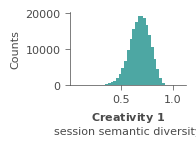

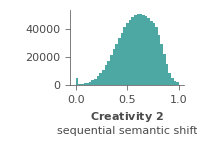

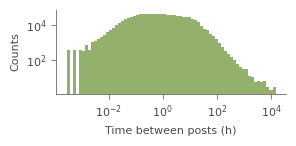

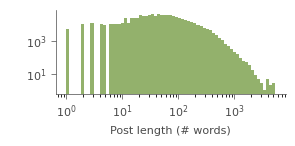

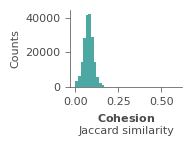

In [25]:
# === FULL HUMAN DATASET PLOTS ===

plt.rcParams.update({'font.size': 8})

# Creativity 1
plot_histogram(creativity_1_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 1}$' + '\nsession semantic diversity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_creativity1.png', transparent=True)

# Creativity 2
plot_histogram(creativity_2_all_human,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 2}$' + '\nsequential semantic shift')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_creativity2.png', transparent=True)

# Time intervals
plot_histogram(time_intervals_all_human,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)')
plt.tight_layout()
#plt.savefig(OUTPUT_DIR / 'all_human_time_intervals.pdf', transparent=True)

# Post lengths
plot_histogram(post_lengths_all_human,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_post_lengths.png', transparent=True)

# Cohesion
plot_histogram(cohesion_all_human,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Cohesion}$' + '\nJaccard similarity')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'all_human_cohesion.png', transparent=True)